# Predicting Diabetes Risk with CDC BRFFS Survey Data
*By: Mayumy Cordova, Hyung Jin Kim, Qiong Zhang, Godsee Joy*

# I. Data Loading and Prep
This section is organized as follows:
1. Loading in 2015 CDC BRFFS, selecting fields used in analysis, and transforming variables
2. Loading in latest 2023 CDC BRFFS, matching fields for analysis per 2015 data, and transforming variables similarly


For variable selection and data cleansing suggestions, this Kaggle notebook was consulted in addition to our team's literature review: https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook

Load packages

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn.preprocessing import OneHotEncoder


import tensorflow as tf
from tensorflow import keras
from keras import metrics
from keras.datasets import fashion_mnist

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, roc_auc_score

tf.get_logger().setLevel('INFO')

## 1. Import 2015 BRFFS Data
- Result: df_selected_2015
- Shape: (441,456, 22)

In [3]:
# mount to GDrive or local file path
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read in the csv file of the starting position of columns, variable name, and field lengths to process original ASCII file.

**Source:** https://www.cdc.gov/brfss/annual_data/2015/llcp_varlayout_15_onecolumn.html

In [4]:
#df_cols_2015 = pd.read_csv('cdc2015_col_specs.csv', delimiter=",")  # change delimiter as needed
df_cols_2015 = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/cdc2015_col_specs.csv', delimiter=",")


In [5]:
df_cols_2015.head()

Starting Column Variable Name  Field Length
0                1        _STATE             2
1               17        FMONTH             2
2               19         IDATE             8
3               19        IMONTH             2
4               21          IDAY             2

In [6]:
# Calculate the colspecs (start and end positions for each field)
df_cols_2015['End Column'] = df_cols_2015['Starting Column'] + df_cols_2015['Field Length'] - 1
colspecs_2015 = list(zip(df_cols_2015['Starting Column'] - 1, df_cols_2015['End Column']))

# Extract column names
column_names_2015 = df_cols_2015['Variable Name'].tolist()

# Display the colspecs and column names to verify
print("Column Specifications:", colspecs_2015)
print("Column Names:", column_names_2015)

Column Specifications: [(0, 2), (16, 18), (18, 26), (18, 20), (20, 22), (22, 26), (31, 35), (35, 45), (35, 45), (62, 63), (63, 64), (64, 65), (65, 66), (66, 67), (67, 68), (68, 70), (70, 72), (72, 74), (74, 75), (75, 76), (76, 77), (77, 78), (78, 79), (79, 80), (82, 83), (83, 85), (89, 90), (90, 92), (92, 94), (94, 96), (96, 97), (97, 98), (98, 99), (99, 100), (100, 101), (101, 102), (102, 103), (103, 104), (104, 105), (105, 106), (106, 107), (107, 108), (108, 109), (109, 110), (110, 111), (111, 112), (112, 113), (113, 114), (114, 115), (115, 116), (116, 117), (117, 119), (119, 120), (156, 157), (157, 158), (158, 159), (167, 168), (168, 169), (169, 170), (170, 171), (171, 172), (172, 174), (174, 176), (176, 177), (177, 181), (181, 185), (185, 186), (186, 187), (187, 188), (188, 189), (189, 190), (190, 191), (191, 192), (192, 193), (193, 194), (194, 195), (195, 196), (196, 198), (198, 199), (199, 202), (202, 204), (204, 206), (206, 208), (208, 211), (211, 214), (214, 217), (217, 220), (

Load in ASCII file from CDC - save it from source and unzip to local file path

**Source:** https://www.cdc.gov/brfss/annual_data/2015/files/LLCP2015ASC.zip

In [7]:
# Path to ASCII file in Google Drive ~ 2 min to run

ascii_file_path = '/content/drive/MyDrive/ColabNotebooks/LLCP2015.ASC'

# Load the ASCII file into a DataFrame
df_2015 = pd.read_fwf(ascii_file_path, colspecs=colspecs_2015, names=column_names_2015)

# Display the first few rows of the DataFrame
df_2015.head()

_STATE  FMONTH    IDATE  IMONTH  IDAY  IYEAR  DISPCODE       SEQNO  \
0       1       1  1292015       1    29   2015      1200  2015000001   
1       1       1  1202015       1    20   2015      1100  2015000002   
2       1       1  2012015       2     1   2015      1200  2015000003   
3       1       1  1142015       1    14   2015      1100  2015000004   
4       1       1  1142015       1    14   2015      1100  2015000005   

         _PSU  CTELENUM  ...  _PAREC1  _PASTAE1  _LMTACT1  _LMTWRK1  _LMTSCL1  \
0  2015000001       1.0  ...        4         2       1.0       1.0       1.0   
1  2015000002       1.0  ...        2         2       3.0       3.0       4.0   
2  2015000003       1.0  ...        9         9       9.0       9.0       9.0   
3  2015000004       1.0  ...        4         2       1.0       1.0       1.0   
4  2015000005       1.0  ...        4         2       1.0       1.0       1.0   

   _RFSEAT2  _RFSEAT3  _FLSHOT6  _PNEUMO2  _AIDTST3  
0         1         1       NaN       NaN       1.0  
1         2         2       NaN       NaN       2.0  
2         9         9       9.0       9.0       NaN  
3         1         1       NaN       NaN       9.0  
4         1         1       NaN       NaN       1.0  

[5 rows x 330 columns]

In [ ]:
# save as csv - entire dataset df
df_2015.to_csv('/content/drive/MyDrive/ColabNotebooks/cdc2015_df.csv', index=False)

In [8]:
df_2015.shape

(441456, 330)

Select only columns to use in potential analysis

**Source 2015 Codebook:** https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf

In [9]:
# select specific columns

df_selected_2015 = df_2015[['DIABETE3',
                  '_RFHYPE5',
                  'TOLDHI2',
                  '_CHOLCHK',
                  '_BMI5',
                  'SMOKE100',
                  'CVDSTRK3',
                  '_MICHD',
                  '_TOTINDA',
                  #'_FRTLT1',
                  #'_VEGLT1', in 2015, but not 2023 so removed
                  '_RFDRHV5',
                  'HLTHPLN1',
                  'MEDCOST',
                  'GENHLTH',
                  'MENTHLTH',
                  'PHYSHLTH',
                  'DIFFWALK',
                  'SEX',
                  '_AGEG5YR',
                  'EDUCA',
                  'INCOME2',
                  '_RACE', # added race and state
                  '_STATE'
                  ]]


df_selected_2015.head()

DIABETE3  _RFHYPE5  TOLDHI2  _CHOLCHK   _BMI5  SMOKE100  CVDSTRK3  _MICHD  \
0       3.0         2      1.0         1  4018.0       1.0         2     2.0   
1       3.0         1      2.0         2  2509.0       1.0         2     2.0   
2       3.0         1      1.0         1  2204.0       NaN         1     NaN   
3       3.0         2      1.0         1  2819.0       2.0         2     2.0   
4       3.0         1      2.0         1  2437.0       2.0         2     2.0   

   _TOTINDA  _RFDRHV5  ...  GENHLTH  MENTHLTH  PHYSHLTH  DIFFWALK  SEX  \
0         2         1  ...      5.0        18      15.0       1.0    2   
1         1         1  ...      3.0        88      88.0       2.0    2   
2         9         9  ...      4.0        88      15.0       NaN    2   
3         2         1  ...      5.0        30      30.0       1.0    2   
4         2         1  ...      5.0        88      20.0       2.0    2   

   _AGEG5YR  EDUCA  INCOME2  _RACE  _STATE  
0         9      4      3.0      1       1  
1         7      6      1.0      1       1  
2        11      4     99.0      1       1  
3         9      4      8.0      1       1  
4         9      5     77.0      1       1  

[5 rows x 22 columns]

In [10]:
df_selected_2015.shape

(441456, 22)

In [11]:
# save as csv - only selected columns
df_selected_2015.to_csv('/content/drive/MyDrive/ColabNotebooks/cdc2015_df_selected.csv', index=False)

## 2. Import 2023 BRFFS Data
- Result: df_selected_2023
- Shape: (433,323, 22)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read in the csv file of the starting position of columns, variable name, and field lengths to process ASCII file.

**Source:** https://www.cdc.gov/brfss/annual_data/2023/llcp_varlayout_23_onecolumn.html

In [ ]:
# read in col specs
df_cols_2023 = pd.read_csv('cdc2023_col_specs.csv', delimiter=",")
# change delimiter as needed

In [ ]:
df_cols_2023.head()

Starting Column Variable Name  Field Length
0                1        _STATE             2
1               17        FMONTH             2
2               19         IDATE             8
3               19        IMONTH             2
4               21          IDAY             2

In [ ]:
# Calculate the colspecs (start and end positions for each field)
df_cols_2023['End Column'] = df_cols_2023['Starting Column'] + df_cols_2023['Field Length'] - 1
colspecs_2023 = list(zip(df_cols_2023['Starting Column'] - 1, df_cols_2023['End Column']))

# Extract column names
column_names_2023 = df_cols_2023['Variable Name'].tolist()

# Display the colspecs and column names to verify
print("Column Specifications:", colspecs_2023)
print("Column Names:", column_names_2023)

Column Specifications: [(0, 2), (16, 18), (18, 26), (18, 20), (20, 22), (22, 26), (31, 35), (35, 45), (35, 45), (62, 63), (63, 64), (64, 65), (65, 66), (66, 67), (67, 68), (68, 70), (70, 71), (71, 72), (72, 73), (73, 74), (74, 75), (75, 76), (76, 77), (77, 78), (78, 79), (79, 80), (80, 81), (81, 82), (84, 85), (85, 87), (87, 88), (100, 101), (101, 103), (103, 105), (105, 107), (107, 109), (109, 110), (110, 111), (111, 112), (112, 113), (113, 115), (115, 118), (118, 121), (121, 123), (123, 126), (126, 129), (129, 132), (132, 133), (133, 134), (134, 135), (135, 136), (136, 137), (137, 138), (138, 139), (139, 140), (140, 141), (141, 142), (142, 143), (143, 144), (144, 145), (145, 146), (146, 147), (147, 148), (148, 149), (149, 151), (185, 186), (186, 187), (187, 188), (196, 197), (197, 198), (198, 199), (199, 200), (200, 201), (201, 203), (203, 205), (205, 206), (206, 210), (210, 214), (214, 215), (215, 216), (216, 217), (217, 218), (218, 219), (219, 220), (220, 222), (222, 224), (224, 22

Again, like for 2015, save ASCII file, unzip to local file path, and load using column specs

**Source:** https://www.cdc.gov/brfss/annual_data/annual_2023.html

In [ ]:
# Path to ASCII file in Google Drive ~ 2 min to run
ascii_file_path = '/content/drive/MyDrive/ColabNotebooks/LLCP2023.ASC'

# Load the ASCII file into a DataFrame
df_2023 = pd.read_fwf(ascii_file_path, colspecs=colspecs_2023, names=column_names_2023)

# Display the first few rows of the DataFrame
df_2023.head()

_STATE  FMONTH    IDATE  IMONTH  IDAY  IYEAR  DISPCODE       SEQNO  \
0       1       1  3012023       3     1   2023      1100  2023000001   
1       1       1  1062023       1     6   2023      1100  2023000002   
2       1       1  3082023       3     8   2023      1100  2023000003   
3       1       1  3062023       3     6   2023      1100  2023000004   
4       1       1  1062023       1     6   2023      1100  2023000005   

         _PSU  CTELENM1  ...  DROCDY4_  _RFBING6  _DRNKWK2  _RFDRHV8  \
0  2023000001       1.0  ...         0         1         0         1   
1  2023000002       1.0  ...         0         1         0         1   
2  2023000003       1.0  ...         0         1         0         1   
3  2023000004       1.0  ...         0         1         0         1   
4  2023000005       1.0  ...         7         1        47         1   

   _FLSHOT7  _PNEUMO3  _AIDTST4  _RFSEAT2  _RFSEAT3  _DRNKDRV  
0       2.0       2.0       2.0         1         1         9  
1       1.0       1.0       2.0         1         1         9  
2       1.0       1.0       2.0         1         1         9  
3       1.0       1.0       1.0         1         1         9  
4       2.0       1.0       2.0         1         1         2  

[5 rows x 350 columns]

In [ ]:
df_2023.shape

(433323, 350)

In [ ]:
# save as csv - entire dataset df
df_2023.to_csv('/content/drive/MyDrive/ColabNotebooks/cdc2023_df.csv', index=False)

Again, select only specific columns to use in analysis.

**2023 Codebook (need to download locally first):** https://www.cdc.gov/brfss/annual_data/annual_2023.html

In [ ]:
# select specific columns
df_selected_2023 = df_2023[['DIABETE4', # was DIABETE3
                  '_RFHYPE6',  # was _RFHYPE5
                  'TOLDHI3', # was TOLDHI2
                  '_CHOLCH3', # was _CHOLCHK'
                  '_BMI5',
                  'SMOKE100',
                  'CVDSTRK3',
                  '_MICHD',
                  '_TOTINDA',
                  #'_FRTLT1', # not avail in 2023
                  #'_VEGLT1', # not avail in 2023
                  '_RFDRHV8', # was '_RFDRHV5',
                  '_HLTHPL1', # was 'HLTHPLN1',
                  'MEDCOST1', # was 'MEDCOST',
                  'GENHLTH',
                  'MENTHLTH',
                  'PHYSHLTH',
                  'DIFFWALK',
                  'SEXVAR', # was 'SEX',
                  '_AGEG5YR',
                  'EDUCA',
                  'INCOME3', # was 'INCOME2'
                  '_RACE', # added race and state
                  '_STATE'
                  ]]

# view first few rows
df_selected_2023.head()

DIABETE4  _RFHYPE6  TOLDHI3  _CHOLCH3   _BMI5  SMOKE100  CVDSTRK3  _MICHD  \
0       1.0         2      2.0         1  3047.0       2.0       2.0     2.0   
1       3.0         2      1.0         1  2856.0       2.0       2.0     2.0   
2       3.0         2      1.0         1  2231.0       1.0       2.0     2.0   
3       3.0         1      2.0         1  2744.0       2.0       2.0     2.0   
4       1.0         2      2.0         1  2585.0       2.0       2.0     2.0   

   _TOTINDA  _RFDRHV8  ...  GENHLTH  MENTHLTH  PHYSHLTH  DIFFWALK  SEXVAR  \
0         2         1  ...      2.0      88.0      88.0       1.0       2   
1         1         1  ...      2.0      88.0      88.0       2.0       2   
2         1         1  ...      4.0       2.0       6.0       1.0       2   
3         1         1  ...      2.0      88.0       2.0       1.0       2   
4         1         1  ...      4.0      88.0      88.0       1.0       2   

   _AGEG5YR  EDUCA  INCOME3  _RACE  _STATE  
0        13    5.0     99.0    1.0       1  
1        13    5.0     99.0    1.0       1  
2        13    4.0      2.0    2.0       1  
3        12    5.0     99.0    1.0       1  
4        12    5.0      7.0    1.0       1  

[5 rows x 22 columns]

In [ ]:
df_selected_2023.shape

(433323, 22)

In [ ]:
# save as csv - only selected columns
df_selected_2023.to_csv('/content/drive/MyDrive/ColabNotebooks/cdc2023_df_selected.csv', index=False)

## 3. Clean Both Datasets

1. Check data types
2. Drop Missing Values
3. Make categorical response questions binary and numeric responses into grouped classes to simplify
4. Make sure all columns are int64

**Column Details for Reference:**

- Diabetes_binary : has diabetes (0,1)

- HighBP : Adults who have been told they have high blood pressure by a doctor, nurse, or other health professional (0,1)

- HighChol : Have you EVER been told by a doctor, nurse or other health professional that your blood cholesterol is high? (0,1)

- CholCheck : Cholesterol check within past five years (0,1)

- BMI : Body Mass Index (BMI)

- Smoker : Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] (0,1)

- Stroke : (Ever told) you had a stroke. (0,1)

- HeartDiseaseorAttack : Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI) (0,1)

- PhysActivity : Adults who reported doing physical activity or exercise during the past 30 days other than their regular job (0,1)

- HvyAlcoholConsump : Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week)(0,1)

- AnyHealthcare : Do you have any kind of health care coverage, including health insurance, prepaid plans such as HMOs, or government plans such as Medicare, or Indian Health Service? (0,1)

- NoDocbcCost : Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? (0,1)

- GenHlth : Would you say that in general your health is: rate (1 ~ 5)

- MentHlth : Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good? (0 ~ 30)

- PhysHlth : Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? (0 ~ 30)

- DiffWalk : Do you have serious difficulty walking or climbing stairs? (0,1)

- Sex : Indicate sex of respondent (0,1) (Male)

Age : Fourteen-level age category (1 ~ 13) 5 year buckets 18 to 80+

Education : What is the highest grade or year of school you completed? (1 ~ 6)
- 1 = Never attended school or only kindergarten
- 2 = Grades 1 through 8 (Elementary)
- 3 = Grades 9 through 11 (Some high school)
- 4 = Grade 12 or GED (High school graduate)
- 5 = College 1 year to 3 years (Some college or technical school)
- 6 = College 4 years or more (College graduate)

Income : Is your annual household income from all sources (1 ~ 8) Less than 10K to 75K or more

### Clean and Process 2015 Data
- Result: cdc2015_df_cleaned_12062024.csv
- Shape: (262,418, 25)

In [ ]:
# simplify df name for ease
# read in df_selected_2015 file
df_2015 = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/cdc2015_df_selected.csv')

In [ ]:
# Show Unique Values for Each Variable
for column in df_2015.columns:
    unique_values = df_2015[column].unique()
    print(f"Column: {column}")
    print(f"Unique values ({len(unique_values)}): {unique_values}")
    print("-" * 40)

Column: DIABETE3
Unique values (7): [ 3.  1.  4.  2.  7. nan  9.]
----------------------------------------
Column: _RFHYPE5
Unique values (3): [2 1 9]
----------------------------------------
Column: TOLDHI2
Unique values (5): [ 1.  2. nan  7.  9.]
----------------------------------------
Column: _CHOLCHK
Unique values (4): [1 2 9 3]
----------------------------------------
Column: _BMI5
Unique values (3737): [4018. 2509. 2204. ... 6322. 4174. 4159.]
----------------------------------------
Column: SMOKE100
Unique values (5): [ 1. nan  2.  7.  9.]
----------------------------------------
Column: CVDSTRK3
Unique values (4): [2 1 7 9]
----------------------------------------
Column: _MICHD
Unique values (3): [ 2. nan  1.]
----------------------------------------
Column: _TOTINDA
Unique values (3): [2 1 9]
----------------------------------------
Column: _RFDRHV5
Unique values (3): [1 9 2]
----------------------------------------
Column: HLTHPLN1
Unique values (4): [1 2 7 9]
-------------

In [ ]:
# Recode Data

def recode_column(column, mapping):
    """
    Recode a column based on a mapping.

    Parameters:
        column (pd.Series): The column to recode.
        mapping (dict): Dictionary defining how to map old values to new ones.

    Returns:
        pd.Series: Recoded column.
    """
    return column.map(mapping)

# Define mappings for each column
recode_mappings = {
    "DIABETE3": {1: 1, 4:1, 2: 0, 3: 0},  # Combine 1,4=Yes; 2,3=No
    "_RFHYPE5": {1: 0, 2: 1},  # 1= No High BP; 2=yes High BP
    "TOLDHI2": {1: 1, 2: 0},  # 1=High Cholesterol; 2=No
    "_CHOLCHK": {1: 1, 2: 0, 3: 0},  # 1=Yes; 2,3=No
    "_BMI5" : None, #No mapping, handel separtely
    "SMOKE100": {1: 1, 2: 0},  # 1=Yes; 2=No
    "CVDSTRK3": {1: 1, 2: 0},  # 1=Yes; 2=No
    "_MICHD": {1: 1, 2: 0},  # 1=Yes; 2=No
    "_TOTINDA": {1: 1, 2: 0},  # 1=Yes; 2=No
    "_RFDRHV5": {1: 0, 2: 1},  # 1=No; 2=Yes
    "HLTHPLN1": {1: 1, 2: 0},  # 1=Yes; 2=No
    "MEDCOST": {1: 1, 2: 0},  # 1=Yes; 2=No
    "GENHLTH": {1: 1, 2: 2, 3: 3, 4: 4, 5: 5},  # Recode 1-5 as-is
    "MENTHLTH": None,  # No mapping; handle separately
    "PHYSHLTH": None,  # No mapping; handle separately
    "DIFFWALK": {1: 1, 2: 0},  # 1=Yes; 2=No
    "SEX": {1: 1, 2: 0},  # 1=Male; 2=Female
    "_AGEG5YR": None,  # No mapping; handle separately
    "EDUCA": {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6},  # Remove 9
    "INCOME2": {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8},  # Combine 8-11=8
}


# Apply recoding to each column
for col, mapping in recode_mappings.items():
    if col in df_2015.columns:
        if mapping:  # If a mapping is defined
            df_2015[col] = recode_column(df_2015[col], mapping)


# Show Unique Values for Each Variable
for column in df_2015.columns:
    unique_values = df_2015[column].unique()
    print(f"Column: {column}")
    print(f"Unique values ({len(unique_values)}): {unique_values}")
    print("-" * 40)


Column: DIABETE3
Unique values (3): [ 0.  1. nan]
----------------------------------------
Column: _RFHYPE5
Unique values (3): [ 1.  0. nan]
----------------------------------------
Column: TOLDHI2
Unique values (3): [ 1.  0. nan]
----------------------------------------
Column: _CHOLCHK
Unique values (3): [ 1.  0. nan]
----------------------------------------
Column: _BMI5
Unique values (3737): [4018. 2509. 2204. ... 6322. 4174. 4159.]
----------------------------------------
Column: SMOKE100
Unique values (3): [ 1. nan  0.]
----------------------------------------
Column: CVDSTRK3
Unique values (3): [ 0.  1. nan]
----------------------------------------
Column: _MICHD
Unique values (3): [ 0. nan  1.]
----------------------------------------
Column: _TOTINDA
Unique values (3): [ 0.  1. nan]
----------------------------------------
Column: _RFDRHV5
Unique values (3): [ 0. nan  1.]
----------------------------------------
Column: HLTHPLN1
Unique values (3): [ 1.  0. nan]
---------------

In [ ]:
# Other unspecific values will be recoded as NaN, so dropping
df_2015 = df_2015.dropna()

# Show Unique Values for Each Variable
for column in df_2015.columns:
    unique_values = df_2015[column].unique()
    print(f"Column: {column}")
    print(f"Unique values ({len(unique_values)}): {unique_values}")
    print("-" * 40)

Column: DIABETE3
Unique values (2): [0. 1.]
----------------------------------------
Column: _RFHYPE5
Unique values (2): [1. 0.]
----------------------------------------
Column: TOLDHI2
Unique values (2): [1. 0.]
----------------------------------------
Column: _CHOLCHK
Unique values (2): [1. 0.]
----------------------------------------
Column: _BMI5
Unique values (3343): [4018. 2509. 2819. ... 1444. 4723. 6076.]
----------------------------------------
Column: SMOKE100
Unique values (2): [1. 0.]
----------------------------------------
Column: CVDSTRK3
Unique values (2): [0. 1.]
----------------------------------------
Column: _MICHD
Unique values (2): [0. 1.]
----------------------------------------
Column: _TOTINDA
Unique values (2): [0. 1.]
----------------------------------------
Column: _RFDRHV5
Unique values (2): [0. 1.]
----------------------------------------
Column: HLTHPLN1
Unique values (2): [1. 0.]
----------------------------------------
Column: MEDCOST
Unique values (2):

In [ ]:
# Handle Exclusions
df_2015['MENTHLTH'].mask(df_2015['MENTHLTH'] == 88, 0, inplace = True)
df_2015['PHYSHLTH'].mask(df_2015['PHYSHLTH'] == 88, 0, inplace = True)

df_2015 = df_2015[
    (df_2015["MENTHLTH"] <= 30) & # exclude 77 and 99 which are NA
    (df_2015["PHYSHLTH"] <= 30) & # exclude 77 and 99 which are NA codes
    (df_2015["_AGEG5YR"] != 14)   # Exclude rows where _AGEG5YR = 14
]

# Show Unique Values for Each Variable
for column in df_2015.columns:
    unique_values = df_2015[column].unique()
    print(f"Column: {column}")
    print(f"Unique values ({len(unique_values)}): {unique_values}")
    print("-" * 40)

<ipython-input-57-7a841aa4c196>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_2015['MENTHLTH'].mask(df_2015['MENTHLTH'] == 88, 0, inplace = True)
<ipython-input-57-7a841aa4c196>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

Column: DIABETE3
Unique values (2): [0. 1.]
----------------------------------------
Column: _RFHYPE5
Unique values (2): [1. 0.]
----------------------------------------
Column: TOLDHI2
Unique values (2): [1. 0.]
----------------------------------------
Column: _CHOLCHK
Unique values (2): [1. 0.]
----------------------------------------
Column: _BMI5
Unique values (3309): [4018. 2509. 2819. ... 5035. 4723. 6076.]
----------------------------------------
Column: SMOKE100
Unique values (2): [1. 0.]
----------------------------------------
Column: CVDSTRK3
Unique values (2): [0. 1.]
----------------------------------------
Column: _MICHD
Unique values (2): [0. 1.]
----------------------------------------
Column: _TOTINDA
Unique values (2): [0. 1.]
----------------------------------------
Column: _RFDRHV5
Unique values (2): [0. 1.]
----------------------------------------
Column: HLTHPLN1
Unique values (2): [1. 0.]
----------------------------------------
Column: MEDCOST
Unique values (2):

In [ ]:
# Rename all columns in 2023 to have same column names in 2015

column_mapping = {
    "DIABETE3": "Diabetes_binary",
    "_RFHYPE5": "HighBP",
    "TOLDHI2": "HighChol",
    "_CHOLCHK": "CholCheck",
    "_BMI5": "BMI",
    "SMOKE100": "Smoker",
    "CVDSTRK3": "Stroke",
    "_MICHD": "HeartDiseaseorAttack",
    "_TOTINDA": "PhysActivity",
    "_RFDRHV5": "HvyAlcoholConsump",
    "HLTHPLN1": "AnyHealthcare",
    "MEDCOST": "NoDocbcCost",
    "GENHLTH": "GenHlth",
    "MENTHLTH": "MentHlth",
    "PHYSHLTH": "PhysHlth",
    "DIFFWALK": "DiffWalk",
    "SEX": "Sex",
    "_AGEG5YR": "Age",
    "EDUCA": "Education",
    "INCOME2": "Income",
    "_RACE": "Race",
    "_STATE": "State",
}

# Rename Columns in the 2023 Dataset
df_2015.rename(columns = column_mapping, inplace = True)

# Verify Renamed Columns
print(df_2015.columns)


Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'HvyAlcoholConsump',
       'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth',
       'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'Race', 'State'],
      dtype='object')


Logic for changing numeric fields to categorical or binary:
1. Recategory BMI to classes: <18.5=Underweight, 18.5-24.9=Normal, 25-29.9=Overweight, >=30=Obesity. Maybe we can do binary, <25=low risk BMI=0, others= high risk BMI=1
2. Recode MentHlth to classes: <=10 days= Mild=0, 11-20=Moderate=1, 20-30=Severe=2
3. Recode PhysHlth to classes: <=10 days= Mild=0, 10-20=Moderate=1, 20-30=Severe=2

In [ ]:
# Create New Variables
df_2015['BMI'] = df_2015['BMI'].div(100).round(0)  # to match 2015 data, divided by 100 and rounded to whole num
df_2015["BMI_class"] = df_2015["BMI"].apply(lambda x: 1 if x >= 25 else 0)
df_2015["MentHlth_class"] = pd.cut(df_2015["MentHlth"], bins=[-1, 10, 20, 30], labels=[0, 1, 2], right=True)
df_2015["PhysHlth_class"] = pd.cut(df_2015["PhysHlth"], bins=[-1, 10, 20, 30], labels=[0, 1, 2], right=True)

# Check the Recoded DataFrame
print(df_2015[['BMI', 'BMI_class', 'MentHlth', 'MentHlth_class', 'PhysHlth', 'PhysHlth_class']].head())


    BMI  BMI_class  MentHlth MentHlth_class  PhysHlth PhysHlth_class
0  40.0          1        18              1      15.0              1
1  25.0          1         0              0       0.0              0
3  28.0          1        30              2      30.0              2
5  27.0          1         0              0       0.0              0
6  24.0          0         3              0       0.0              0


In [ ]:
df_2015 = df_2015.astype('int64')

#Display the data type
print('Data type of each column :\n',df_2015.dtypes)
print('-'*20)

# Data has no missing values
# print the shape of data
print('The shape of data :\n', df_2015.shape)
print('-'*20)

Data type of each column :
 Diabetes_binary         int64
HighBP                  int64
HighChol                int64
CholCheck               int64
BMI                     int64
Smoker                  int64
Stroke                  int64
HeartDiseaseorAttack    int64
PhysActivity            int64
HvyAlcoholConsump       int64
AnyHealthcare           int64
NoDocbcCost             int64
GenHlth                 int64
MentHlth                int64
PhysHlth                int64
DiffWalk                int64
Sex                     int64
Age                     int64
Education               int64
Income                  int64
Race                    int64
State                   int64
BMI_class               int64
MentHlth_class          int64
PhysHlth_class          int64
dtype: object
--------------------
The shape of data :
 (262418, 25)
--------------------


In [ ]:
# Show Unique Values for Each Variable

for column in df_2015.columns:
    unique_values = df_2015[column].unique()
    print(f"Column: {column}")
    print(f"Unique values ({len(unique_values)}): {unique_values}")
    print("-" * 40)

Column: Diabetes_binary
Unique values (2): [0 1]
----------------------------------------
Column: HighBP
Unique values (2): [1 0]
----------------------------------------
Column: HighChol
Unique values (2): [1 0]
----------------------------------------
Column: CholCheck
Unique values (2): [1 0]
----------------------------------------
Column: BMI
Unique values (85): [40 25 28 27 24 30 34 26 33 21 23 22 38 19 32 37 31 29 20 35 45 39 47 18
 36 43 55 49 42 17 16 41 44 50 59 48 52 46 54 53 57 14 15 51 58 63 61 56
 60 74 62 64 13 66 73 85 67 65 70 82 79 92 68 72 88 96 81 71 75 12 77 69
 76 87 89 84 95 98 91 86 83 80 90 78 97]
----------------------------------------
Column: Smoker
Unique values (2): [1 0]
----------------------------------------
Column: Stroke
Unique values (2): [0 1]
----------------------------------------
Column: HeartDiseaseorAttack
Unique values (2): [0 1]
----------------------------------------
Column: PhysActivity
Unique values (2): [0 1]
--------------------------

In [ ]:
# save as csv
df_2015.to_csv('/content/drive/MyDrive/ColabNotebooks/cdc2015_df_cleaned_12062024.csv', index=False)

### Clean and Process 2023 Data
- Result: cdc2023_df_cleaned_12062024.csv
- Shape: (261,545, 25)

In [ ]:
# simplify df name for ease
# read in df_selected_2023 file
df_2023 = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/cdc2023_df_selected.csv')

In [ ]:
# Show Unique Values for Each Variable
for column in df_2023.columns:
    unique_values = df_2023[column].unique()
    print(f"Column: {column}")
    print(f"Unique values ({len(unique_values)}): {unique_values}")
    print("-" * 40)

Column: DIABETE4
Unique values (7): [ 1.  3.  2.  7.  4.  9. nan]
----------------------------------------
Column: _RFHYPE6
Unique values (3): [2 1 9]
----------------------------------------
Column: TOLDHI3
Unique values (5): [ 2.  1. nan  7.  9.]
----------------------------------------
Column: _CHOLCH3
Unique values (4): [1 3 9 2]
----------------------------------------
Column: _BMI5
Unique values (4100): [3047. 2856. 2231. ... 4832. 6035. 3440.]
----------------------------------------
Column: SMOKE100
Unique values (5): [ 2.  1. nan  7.  9.]
----------------------------------------
Column: CVDSTRK3
Unique values (5): [ 2.  1.  7.  9. nan]
----------------------------------------
Column: _MICHD
Unique values (3): [ 2.  1. nan]
----------------------------------------
Column: _TOTINDA
Unique values (3): [2 1 9]
----------------------------------------
Column: _RFDRHV8
Unique values (3): [1 9 2]
----------------------------------------
Column: _HLTHPL1
Unique values (3): [1 2 9]
---

In [ ]:
# Recode Data

def recode_column(column, mapping):
    """
    Recode a column based on a mapping.

    Parameters:
        column (pd.Series): The column to recode.
        mapping (dict): Dictionary defining how to map old values to new ones.

    Returns:
        pd.Series: Recoded column.
    """
    return column.map(mapping)

# Define mappings for each column
recode_mappings = {
    "DIABETE4": {1: 1, 4:1, 2: 0, 3: 0},  # Combine 1,4=Yes; 2,3=No
    "_RFHYPE6": {1: 0, 2: 1},  # 1= No High BP; 2=yes High BP
    "TOLDHI3": {1: 1, 2: 0},  # 1=High Cholesterol; 2=No
    "_CHOLCH3": {1: 1, 2: 0, 3: 0},  # 1=Yes; 2,3=No
    "_BMI5" : None, #No mapping, handel separtely
    "SMOKE100": {1: 1, 2: 0},  # 1=Yes; 2=No
    "CVDSTRK3": {1: 1, 2: 0},  # 1=Yes; 2=No
    "_MICHD": {1: 1, 2: 0},  # 1=Yes; 2=No
    "_TOTINDA": {1: 1, 2: 0},  # 1=Yes; 2=No
    "_RFDRHV8": {1: 0, 2: 1},  # 1=No; 2=Yes
    "_HLTHPL1": {1: 1, 2: 0},  # 1=Yes; 2=No
    "MEDCOST1": {1: 1, 2: 0},  # 1=Yes; 2=No
    "GENHLTH": {1: 1, 2: 2, 3: 3, 4: 4, 5: 5},  # Recode 1-5 as-is
    "MENTHLTH": None,  # No mapping; handle separately
    "PHYSHLTH": None,  # No mapping; handle separately
    "DIFFWALK": {1: 1, 2: 0},  # 1=Yes; 2=No
    "SEXVAR": {1: 1, 2: 0},  # 1=Male; 2=Female
    "_AGEG5YR": None,  # No mapping; handle separately
    "EDUCA": {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6},  # Remove 9
    "INCOME3": {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 8, 10: 8, 11: 8},  # Combine 8-11=8
}


# Apply recoding to each column
for col, mapping in recode_mappings.items():
    if col in df_2023.columns:
        if mapping:  # If a mapping is defined
            df_2023[col] = recode_column(df_2023[col], mapping)


# Show Unique Values for Each Variable
for column in df_2023.columns:
    unique_values = df_2023[column].unique()
    print(f"Column: {column}")
    print(f"Unique values ({len(unique_values)}): {unique_values}")
    print("-" * 40)


Column: DIABETE4
Unique values (3): [ 1.  0. nan]
----------------------------------------
Column: _RFHYPE6
Unique values (3): [ 1.  0. nan]
----------------------------------------
Column: TOLDHI3
Unique values (3): [ 0.  1. nan]
----------------------------------------
Column: _CHOLCH3
Unique values (3): [ 1.  0. nan]
----------------------------------------
Column: _BMI5
Unique values (4100): [3047. 2856. 2231. ... 4832. 6035. 3440.]
----------------------------------------
Column: SMOKE100
Unique values (3): [ 0.  1. nan]
----------------------------------------
Column: CVDSTRK3
Unique values (3): [ 0.  1. nan]
----------------------------------------
Column: _MICHD
Unique values (3): [ 0.  1. nan]
----------------------------------------
Column: _TOTINDA
Unique values (3): [ 0.  1. nan]
----------------------------------------
Column: _RFDRHV8
Unique values (3): [ 0. nan  1.]
----------------------------------------
Column: _HLTHPL1
Unique values (3): [ 1.  0. nan]
---------------

In [ ]:
# Other unspecific values will be recoded as NaN, so dropping
df_2023 = df_2023.dropna()

# Show Unique Values for Each Variable
for column in df_2023.columns:
    unique_values = df_2023[column].unique()
    print(f"Column: {column}")
    print(f"Unique values ({len(unique_values)}): {unique_values}")
    print("-" * 40)

Column: DIABETE4
Unique values (2): [0. 1.]
----------------------------------------
Column: _RFHYPE6
Unique values (2): [1. 0.]
----------------------------------------
Column: TOLDHI3
Unique values (2): [1. 0.]
----------------------------------------
Column: _CHOLCH3
Unique values (2): [1. 0.]
----------------------------------------
Column: _BMI5
Unique values (3706): [2231. 2585. 3018. ... 4832. 6035. 3440.]
----------------------------------------
Column: SMOKE100
Unique values (2): [1. 0.]
----------------------------------------
Column: CVDSTRK3
Unique values (2): [0. 1.]
----------------------------------------
Column: _MICHD
Unique values (2): [0. 1.]
----------------------------------------
Column: _TOTINDA
Unique values (2): [1. 0.]
----------------------------------------
Column: _RFDRHV8
Unique values (2): [0. 1.]
----------------------------------------
Column: _HLTHPL1
Unique values (2): [1. 0.]
----------------------------------------
Column: MEDCOST1
Unique values (2)

In [ ]:
# Handle Exclusions
df_2023['MENTHLTH'].mask(df_2023['MENTHLTH'] == 88, 0, inplace = True)
df_2023['PHYSHLTH'].mask(df_2023['PHYSHLTH'] == 88, 0, inplace = True)

df_2023 = df_2023[
    (df_2023["MENTHLTH"] <= 30) & # exclude 77 and 99 which are NA
    (df_2023["PHYSHLTH"] <= 30) & # exclude 77 and 99 which are NA codes
    (df_2023["_AGEG5YR"] != 14)   # Exclude rows where _AGEG5YR = 14
]

# Show Unique Values for Each Variable
for column in df_2023.columns:
    unique_values = df_2023[column].unique()
    print(f"Column: {column}")
    print(f"Unique values ({len(unique_values)}): {unique_values}")
    print("-" * 40)

<ipython-input-46-d03607b6ac6a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_2023['MENTHLTH'].mask(df_2023['MENTHLTH'] == 88, 0, inplace = True)
<ipython-input-46-d03607b6ac6a>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

Column: DIABETE4
Unique values (2): [0. 1.]
----------------------------------------
Column: _RFHYPE6
Unique values (2): [1. 0.]
----------------------------------------
Column: TOLDHI3
Unique values (2): [1. 0.]
----------------------------------------
Column: _CHOLCH3
Unique values (2): [1. 0.]
----------------------------------------
Column: _BMI5
Unique values (3676): [2231. 2585. 3018. ... 4832. 6035. 3440.]
----------------------------------------
Column: SMOKE100
Unique values (2): [1. 0.]
----------------------------------------
Column: CVDSTRK3
Unique values (2): [0. 1.]
----------------------------------------
Column: _MICHD
Unique values (2): [0. 1.]
----------------------------------------
Column: _TOTINDA
Unique values (2): [1. 0.]
----------------------------------------
Column: _RFDRHV8
Unique values (2): [0. 1.]
----------------------------------------
Column: _HLTHPL1
Unique values (2): [1. 0.]
----------------------------------------
Column: MEDCOST1
Unique values (2)

In [ ]:
# Rename all columns in 2023 to have same column names in 2015

column_mapping = {
    "DIABETE4": "Diabetes_binary",
    "_RFHYPE6": "HighBP",
    "TOLDHI3": "HighChol",
    "_CHOLCH3": "CholCheck",
    "_BMI5": "BMI",
    "SMOKE100": "Smoker",
    "CVDSTRK3": "Stroke",
    "_MICHD": "HeartDiseaseorAttack",
    "_TOTINDA": "PhysActivity",
    "_RFDRHV8": "HvyAlcoholConsump",
    "_HLTHPL1": "AnyHealthcare",
    "MEDCOST1": "NoDocbcCost",
    "GENHLTH": "GenHlth",
    "MENTHLTH": "MentHlth",
    "PHYSHLTH": "PhysHlth",
    "DIFFWALK": "DiffWalk",
    "SEXVAR": "Sex",
    "_AGEG5YR": "Age",
    "EDUCA": "Education",
    "INCOME3": "Income",
    "_RACE": "Race",
    "_STATE": "State",
}

# Rename Columns in the 2023 Dataset
df_2023.rename(columns = column_mapping, inplace = True)

# Verify Renamed Columns
print(df_2023.columns)


Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'HvyAlcoholConsump',
       'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth',
       'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'Race', 'State'],
      dtype='object')


In [ ]:
# Create New Variables
df_2023['BMI'] = df_2023['BMI'].div(100).round(0) # to match 2015 data, divided by 100 and rounded to whole num
df_2023["BMI_class"] = (df_2023["BMI"]).apply(lambda x: 1 if x >= 25 else 0)
df_2023["MentHlth_class"] = pd.cut(df_2023["MentHlth"], bins=[-1, 10, 20, 30], labels=[0, 1, 2], right = True)
df_2023["PhysHlth_class"] = pd.cut(df_2023["PhysHlth"], bins=[-1, 10, 20, 30], labels=[0, 1, 2], right = True)

# Check the Recoded DataFrame
print(df_2023[['BMI', 'BMI_class', 'MentHlth', 'MentHlth_class', 'PhysHlth', 'PhysHlth_class']].head())


    BMI  BMI_class  MentHlth MentHlth_class  PhysHlth PhysHlth_class
2  22.0          0       2.0              0       6.0              0
4  26.0          1       0.0              0       0.0              0
5  30.0          1       3.0              0       2.0              0
8  33.0          1       0.0              0       5.0              0
9  23.0          0       0.0              0       0.0              0


In [ ]:
df_2023 = df_2023.astype('int64')

#Display the data type
print('Data type of each column :\n',df_2023.dtypes)
print('-'*20)

# Data has no missing values
# print the shape of data
print('The shape of data :\n', df_2023.shape)
print('-'*20)

Data type of each column :
 Diabetes_binary         int64
HighBP                  int64
HighChol                int64
CholCheck               int64
BMI                     int64
Smoker                  int64
Stroke                  int64
HeartDiseaseorAttack    int64
PhysActivity            int64
HvyAlcoholConsump       int64
AnyHealthcare           int64
NoDocbcCost             int64
GenHlth                 int64
MentHlth                int64
PhysHlth                int64
DiffWalk                int64
Sex                     int64
Age                     int64
Education               int64
Income                  int64
Race                    int64
State                   int64
BMI_class               int64
MentHlth_class          int64
PhysHlth_class          int64
dtype: object
--------------------
The shape of data :
 (261545, 25)
--------------------


In [ ]:
# Show Unique Values for Each Variable

for column in df_2023.columns:
    unique_values = df_2023[column].unique()
    print(f"Column: {column}")
    print(f"Unique values ({len(unique_values)}): {unique_values}")
    print("-" * 40)

Column: Diabetes_binary
Unique values (2): [0 1]
----------------------------------------
Column: HighBP
Unique values (2): [1 0]
----------------------------------------
Column: HighChol
Unique values (2): [1 0]
----------------------------------------
Column: CholCheck
Unique values (2): [1 0]
----------------------------------------
Column: BMI
Unique values (85): [ 22  26  30  33  23  42  24  28  29  27  36  25  38  44  31  32  52  34
  20  37  40  19  35  46  41  47  21  43  17  49  18  45  39  48  16  15
  50  54  13  56  62  77  51  68  53  55  67  70  14  57  59  58  66  60
  65  72  82  61  64  76  12  83  75  71  63  73  74  84  69  87 100  78
  95  89  80  79  81  97  91  86  88  92  90  94  85]
----------------------------------------
Column: Smoker
Unique values (2): [1 0]
----------------------------------------
Column: Stroke
Unique values (2): [0 1]
----------------------------------------
Column: HeartDiseaseorAttack
Unique values (2): [0 1]
---------------------------

In [ ]:
# save as csv
df_2023.to_csv('/content/drive/MyDrive/ColabNotebooks/cdc2023_df_cleaned_12062024.csv', index=False)

# II. EDA

In [ ]:
# Load cleaned data
df_2015 = pd.read_csv('cdc2015_df_cleaned_12062024.csv')
print(df_2015.shape)

(262418, 25)


In [ ]:
display(df_2015.head())

Diabetes_binary  HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  \
0                0       1         1          1   40       1       0   
1                0       0         0          0   25       1       0   
2                0       1         1          1   28       0       0   
3                0       1         0          1   27       0       0   
4                0       1         1          1   24       0       0   

   HeartDiseaseorAttack  PhysActivity  HvyAlcoholConsump  ...  DiffWalk  Sex  \
0                     0             0                  0  ...         1    0   
1                     0             1                  0  ...         0    0   
2                     0             0                  0  ...         1    0   
3                     0             1                  0  ...         0    0   
4                     0             1                  0  ...         0    0   

   Age  Education  Income  Race  State  BMI_class  MentHlth_class  \
0    9          4       3     1      1          1               1   
1    7          6       1     1      1          1               0   
2    9          4       8     1      1          1               2   
3   11          3       6     1      1          1               0   
4   11          5       4     7      1          0               0   

   PhysHlth_class  
0               1  
1               0  
2               2  
3               0  
4               0  

[5 rows x 25 columns]

In [ ]:
# print column names for df_2015
print(df_2015.columns)

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'HvyAlcoholConsump',
       'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth',
       'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'Race', 'State',
       'BMI_class', 'MentHlth_class', 'PhysHlth_class'],
      dtype='object')


In [ ]:
# Load Data
df_2023 = pd.read_csv('cdc2023_df_cleaned_12062024.csv') # already cleaned and processed version

# show head of df
df_2023.head()

Diabetes_binary  HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  \
0                0       1         1          1   22       1       0   
1                1       1         0          1   26       0       0   
2                0       1         1          1   30       0       0   
3                0       1         1          1   33       0       0   
4                1       1         1          1   23       1       0   

   HeartDiseaseorAttack  PhysActivity  HvyAlcoholConsump  ...  DiffWalk  Sex  \
0                     0             1                  0  ...         1    0   
1                     0             1                  0  ...         1    0   
2                     0             1                  0  ...         0    0   
3                     0             0                  0  ...         1    0   
4                     1             1                  0  ...         0    1   

   Age  Education  Income  Race  State  BMI_class  MentHlth_class  \
0   13          4       2     2      1          0               0   
1   12          5       7     1      1          1               0   
2    9          5       7     2      1          1               0   
3   13          5       6     2      1          1               0   
4   12          4       7     1      1          0               0   

   PhysHlth_class  
0               0  
1               0  
2               0  
3               0  
4               0  

[5 rows x 25 columns]

In [ ]:
# show shape of 2023 df
print(df_2023.shape)

(261545, 25)


## 1. EDA of 2015 Dataset

1. Our dataset is not balanced, with much more data points in non-diabetic class. Will need to balance this in training set.
2. Most people have Cholcheck, HealthCare, are able to see doctors without cost being a barrier, and have only mild mental and physical health days.
3. Most people do not have stroke, heart disease / heart attacks, consume alcohol heavily, or have difficulty walking.

### EDA: Univariate

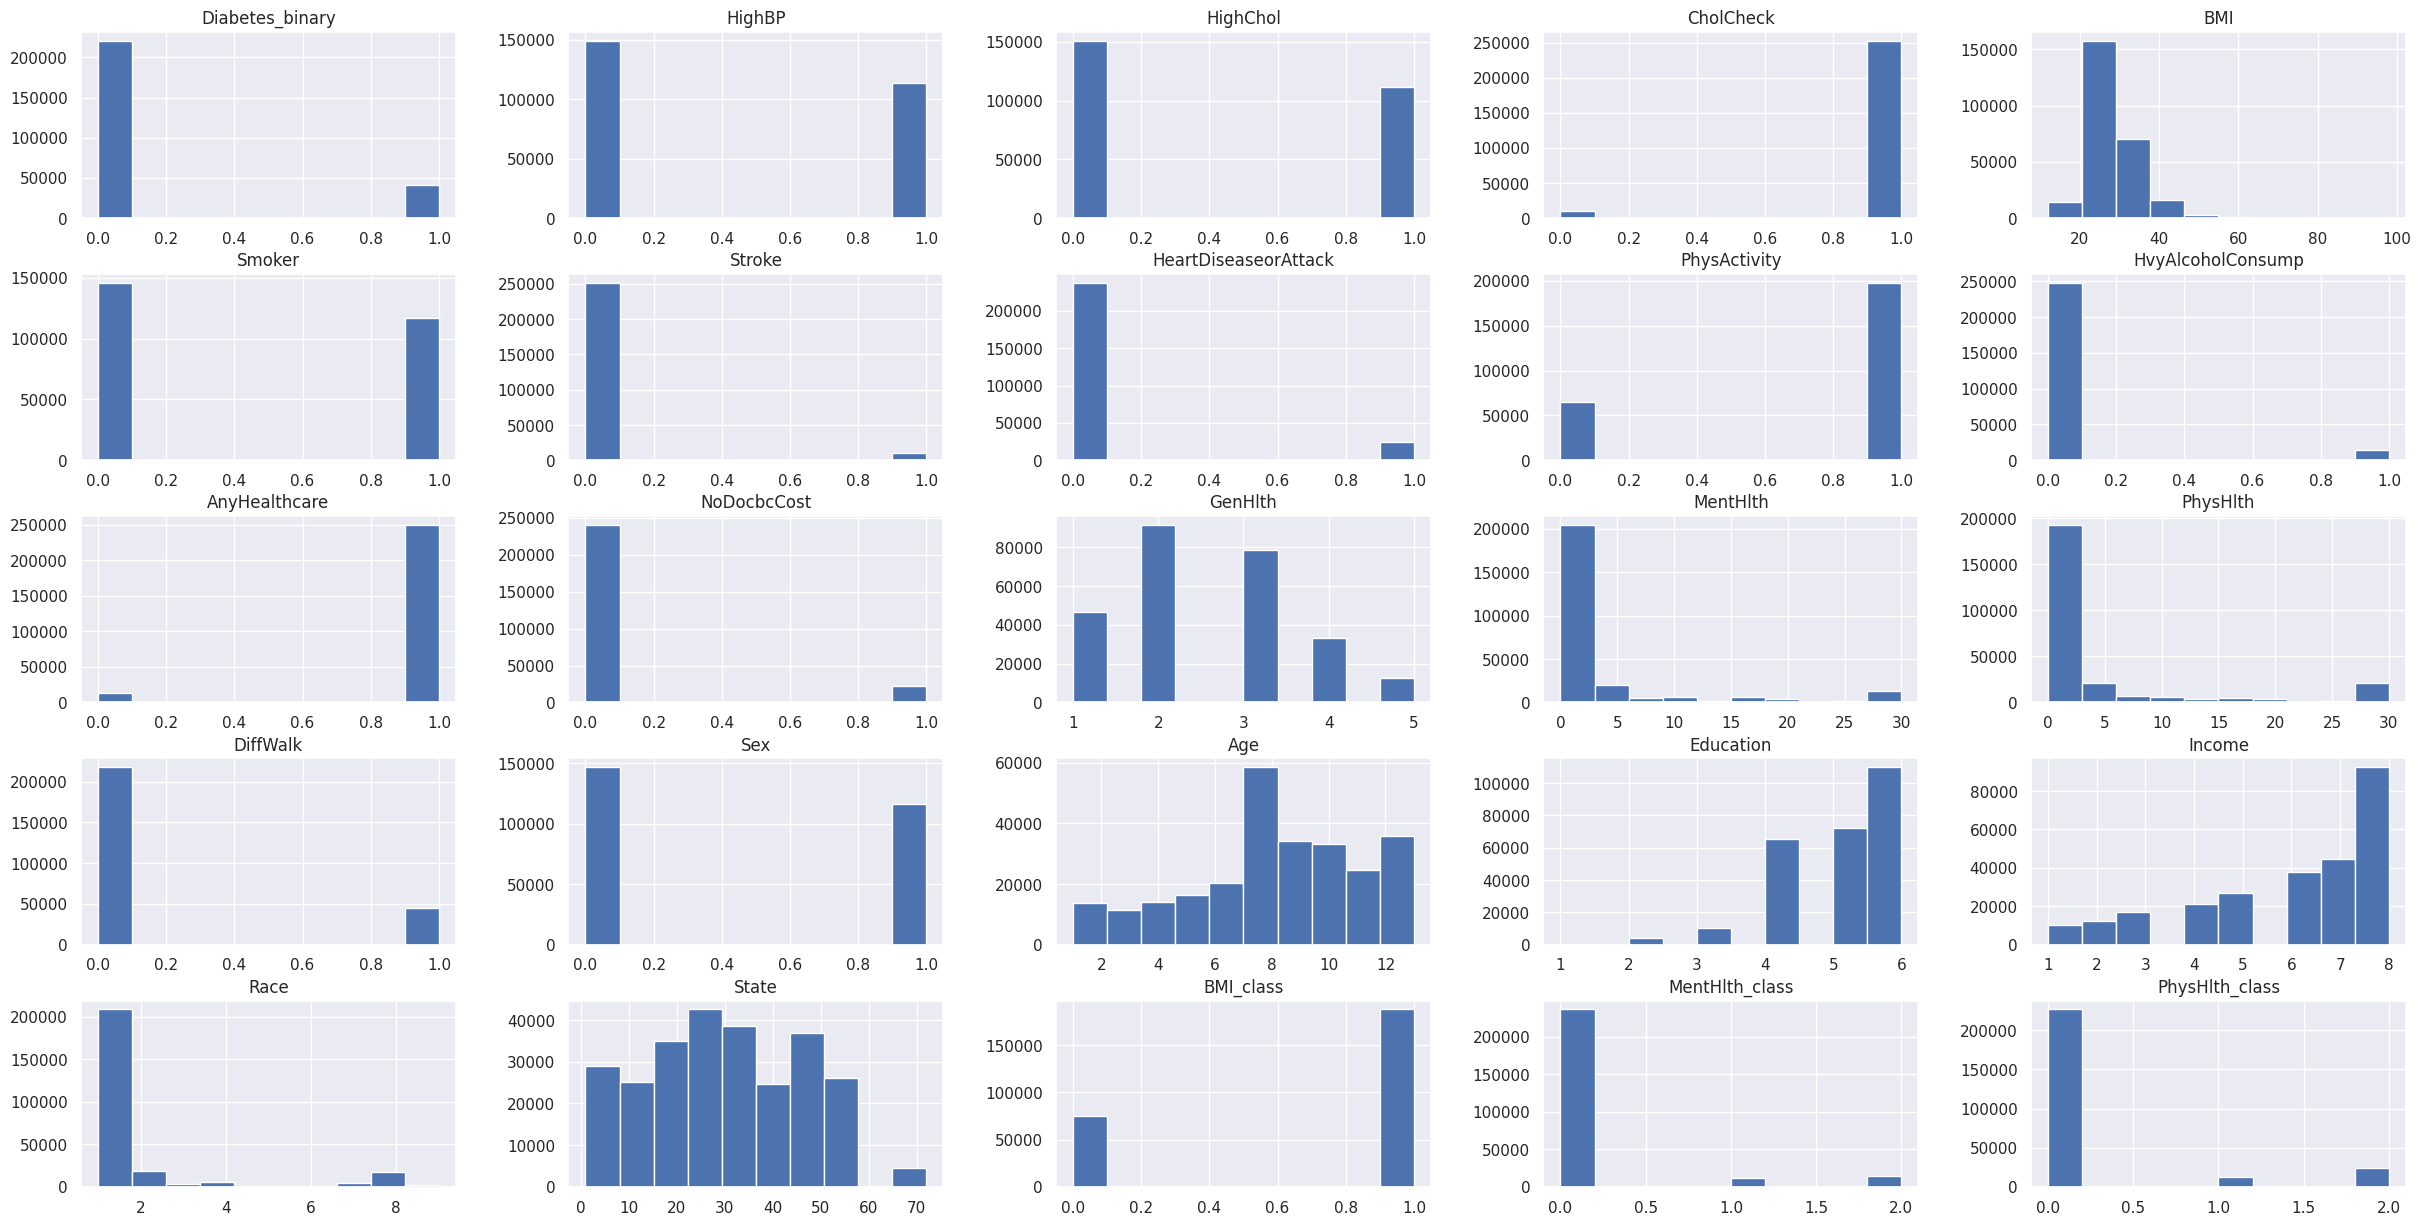

In [ ]:
# EDA: Univariate
df_2015.hist(figsize=(30, 15))
plt.show()

Diabetes_binary
0    220756
1     41662
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Diabeties Diagnosis Classes')

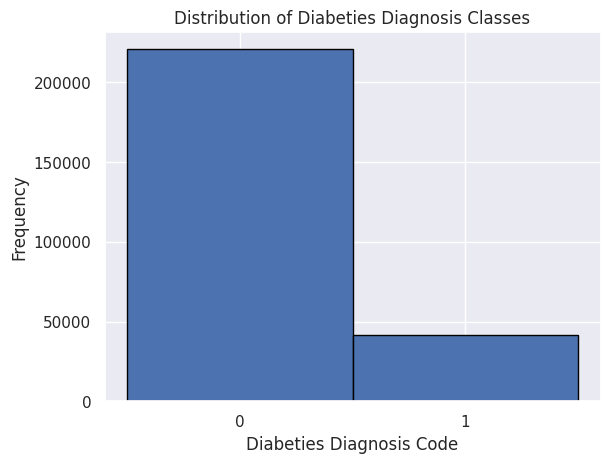

In [ ]:
# Very unbalanced data, we need to balance it in training
print(df_2015['Diabetes_binary'].value_counts())
plt.hist(df_2015['Diabetes_binary'], bins = np.arange(-0.5, 2, 1), edgecolor = 'black')
plt.xticks(np.arange(0, 2, 1))
plt.xlabel('Diabeties Diagnosis Code')
plt.ylabel('Frequency')
plt.title('Distribution of Diabeties Diagnosis Classes')

### EDA: Bivariate

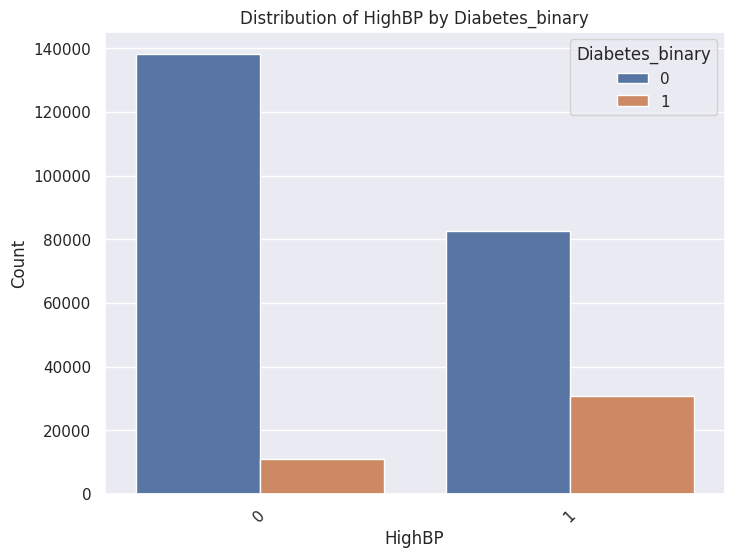

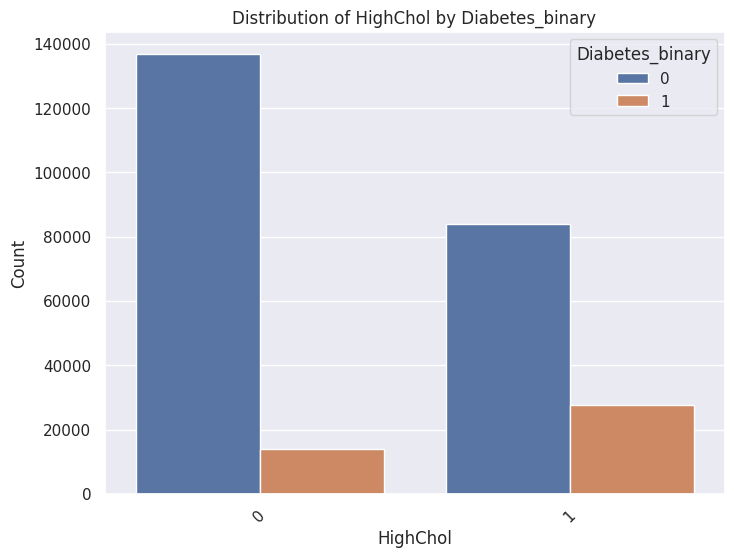

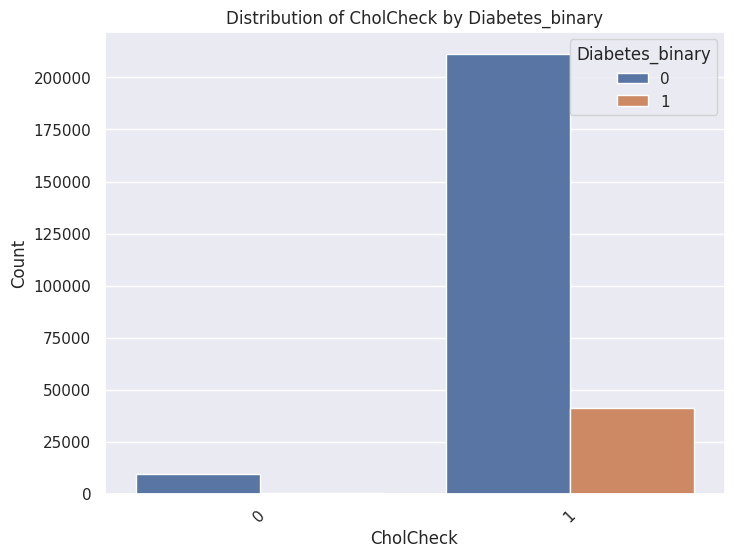

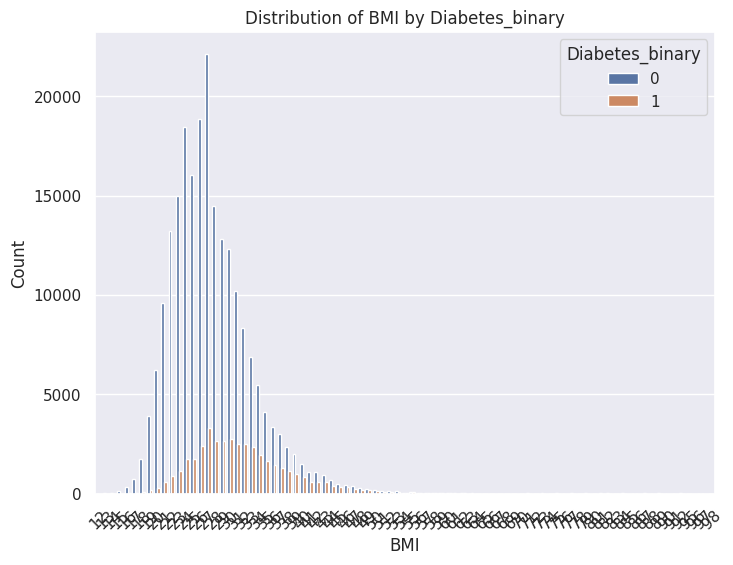

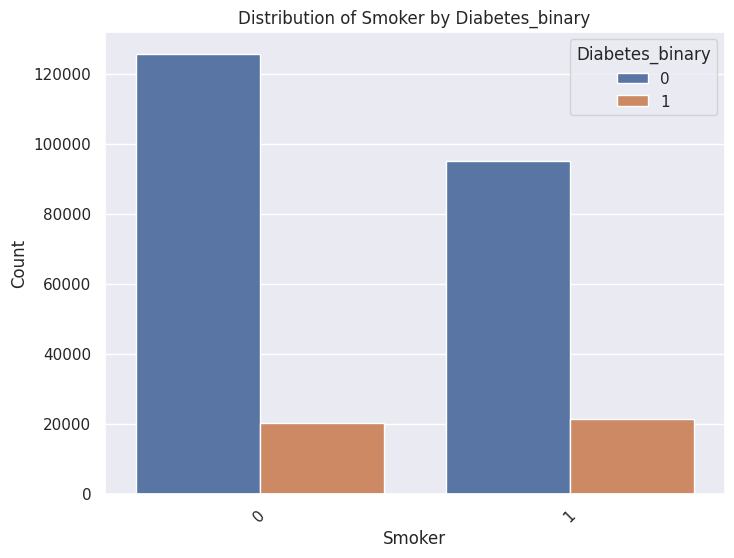

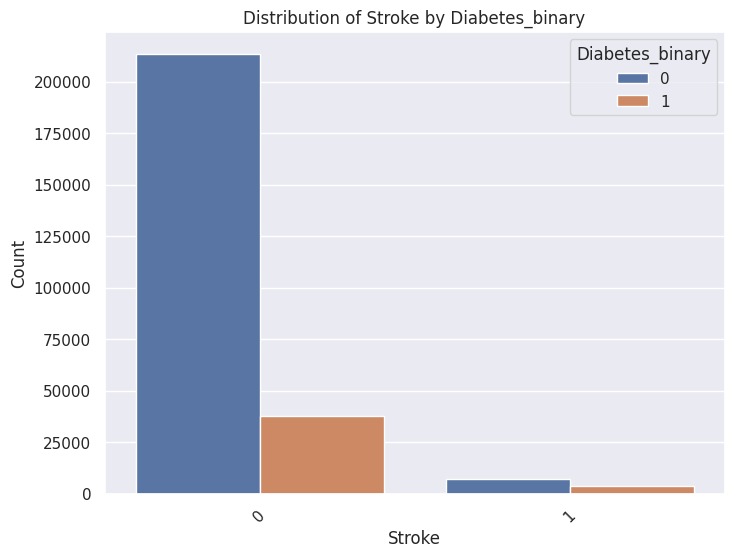

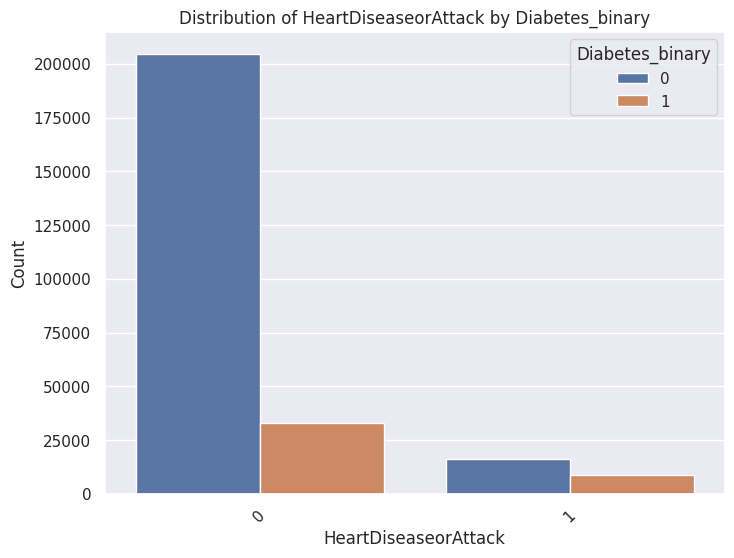

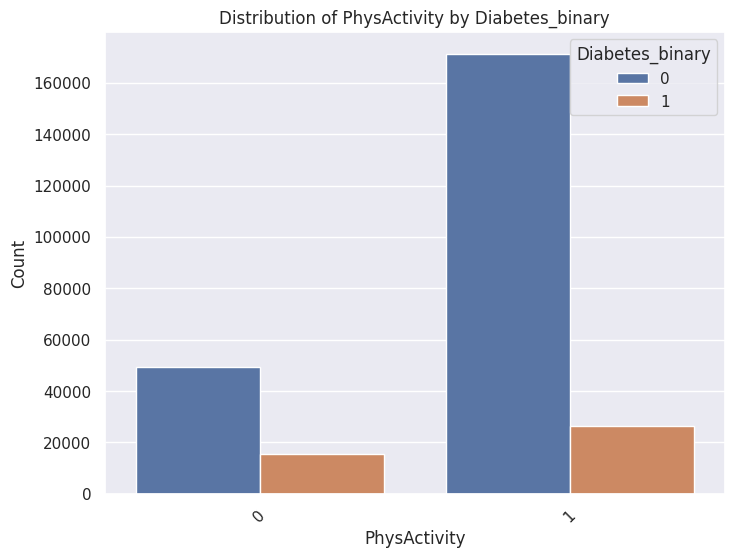

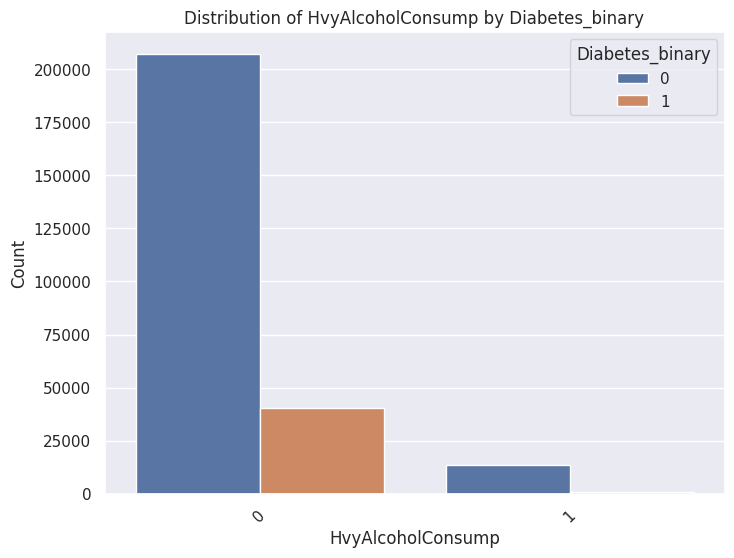

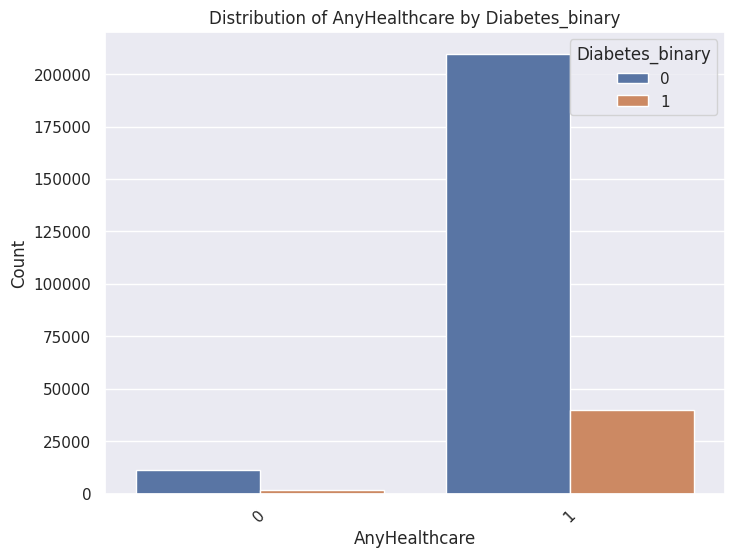

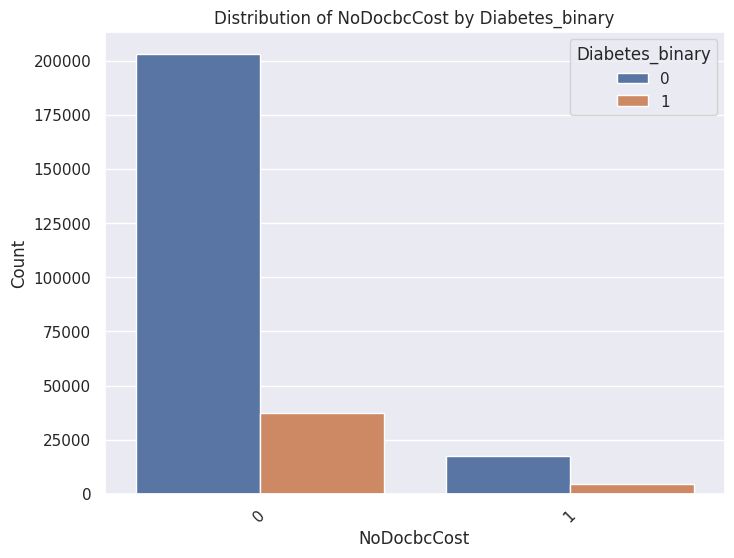

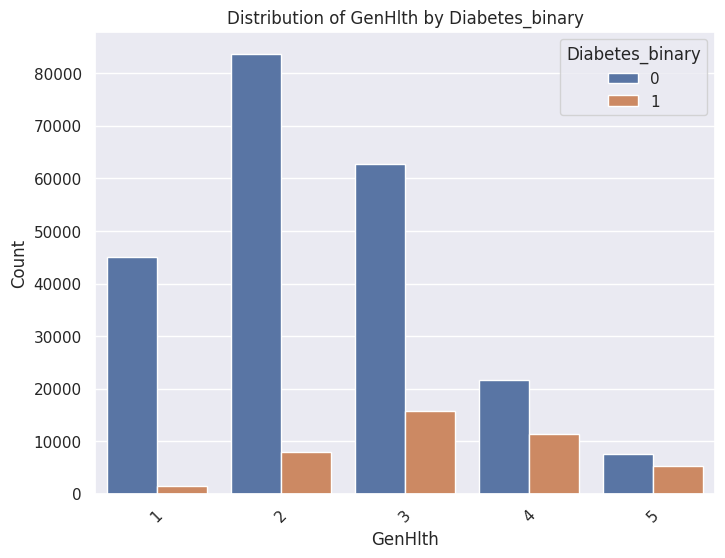

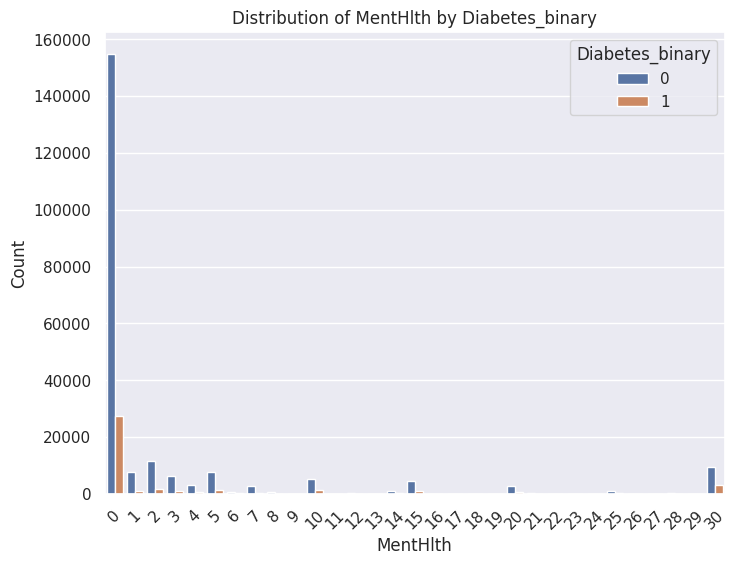

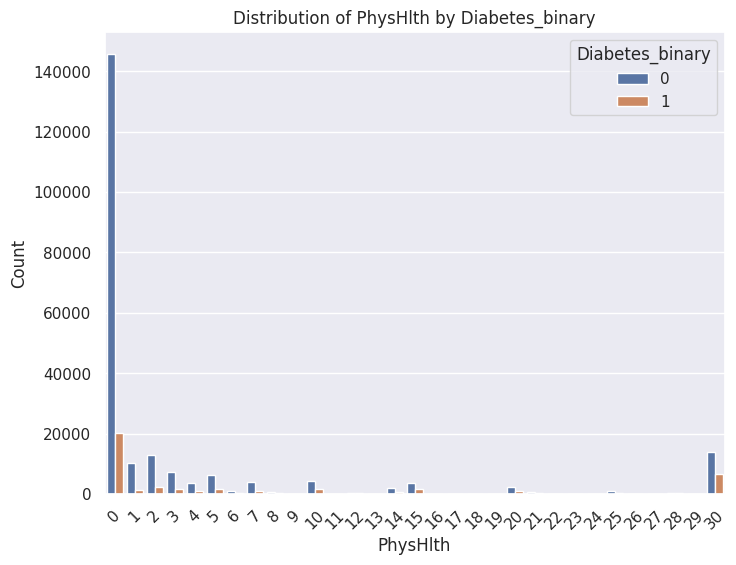

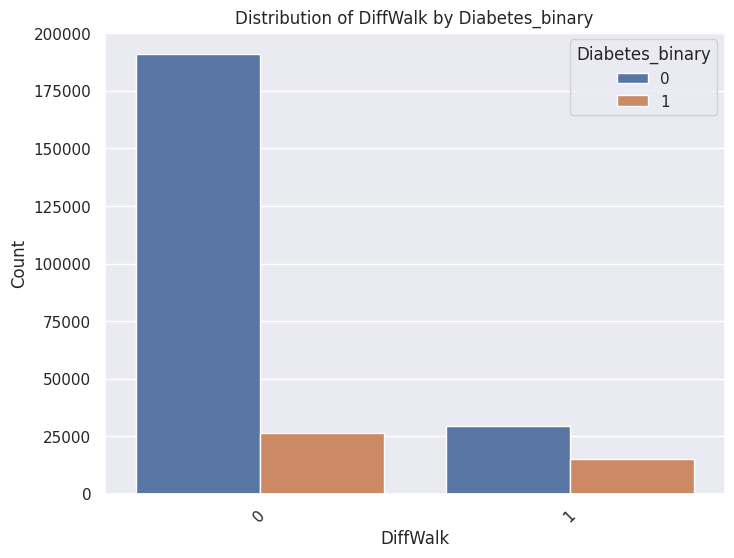

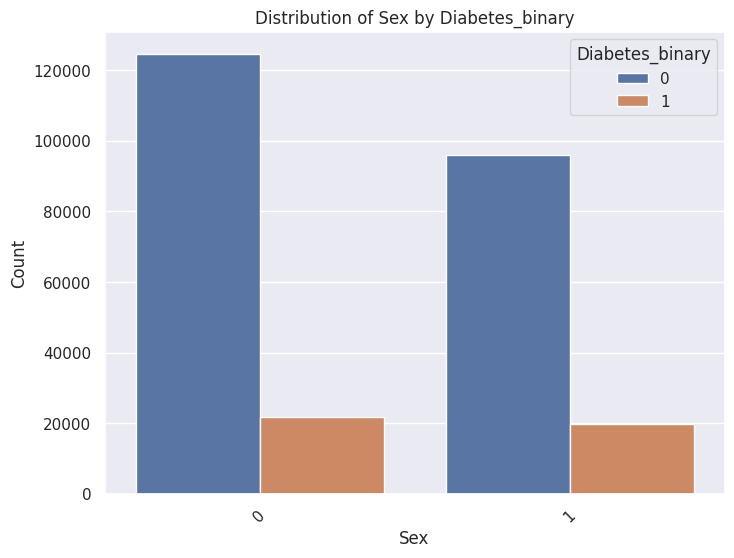

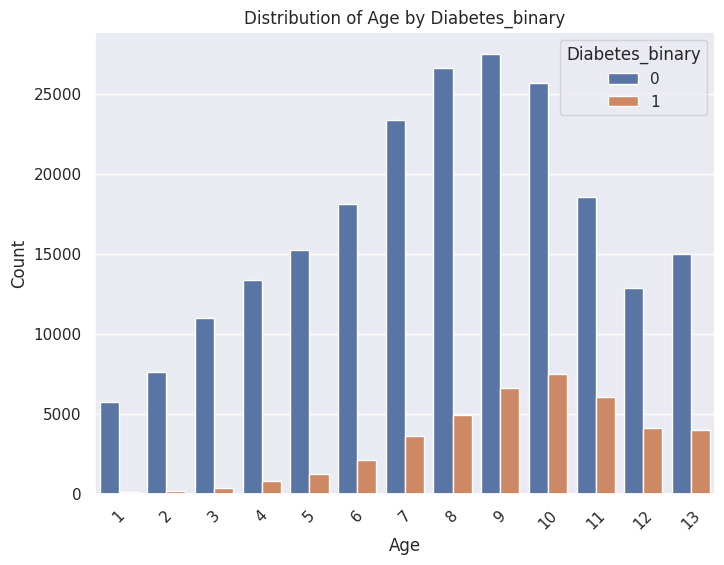

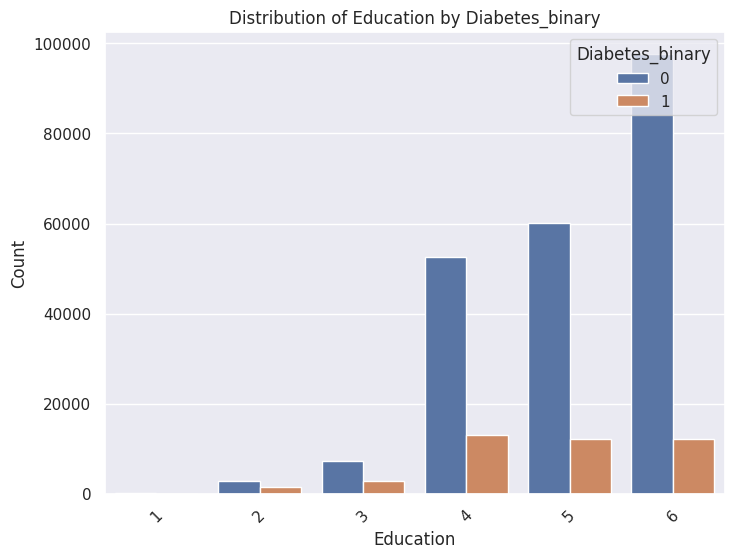

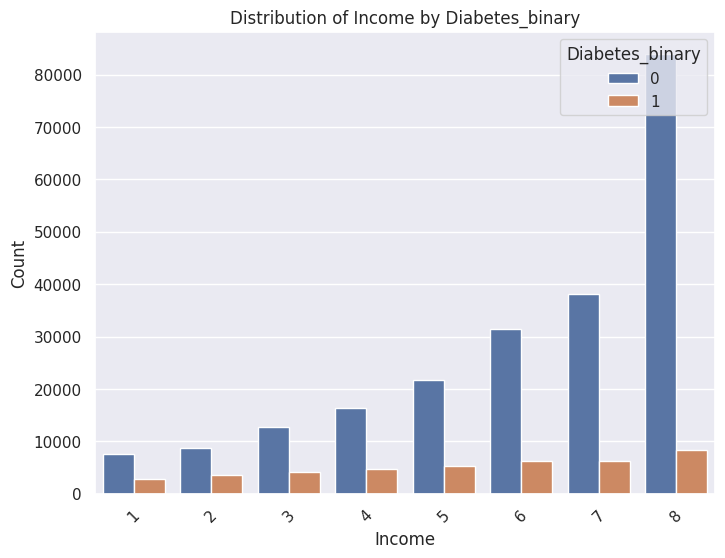

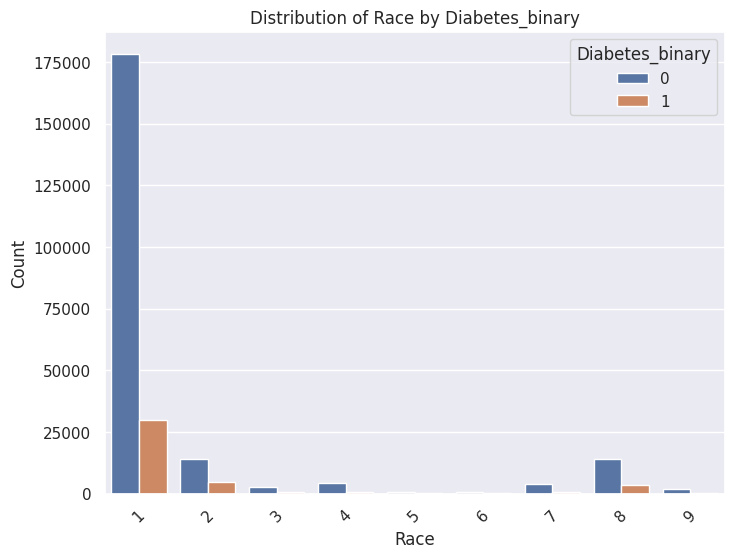

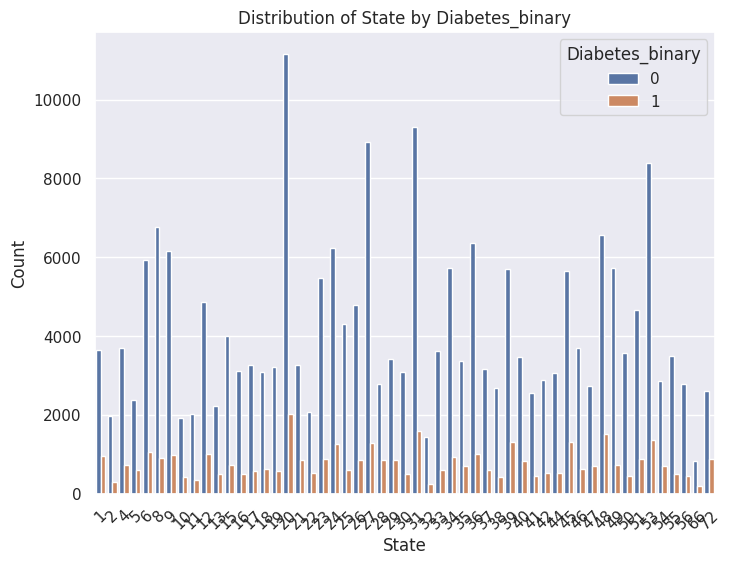

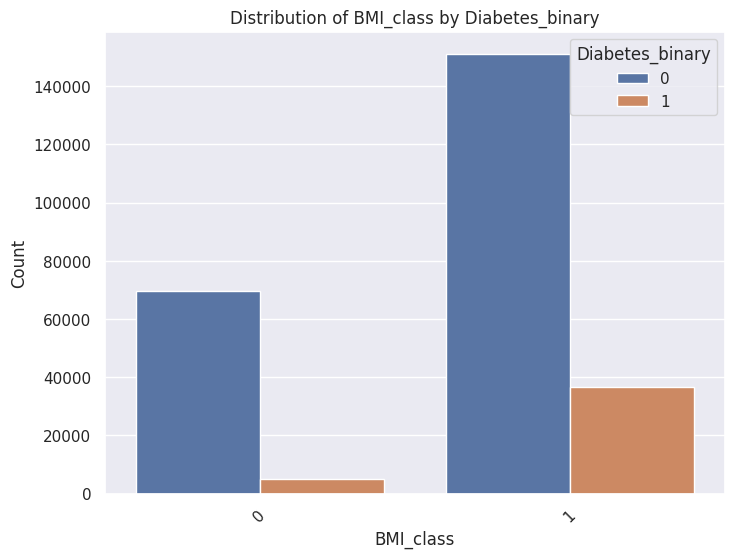

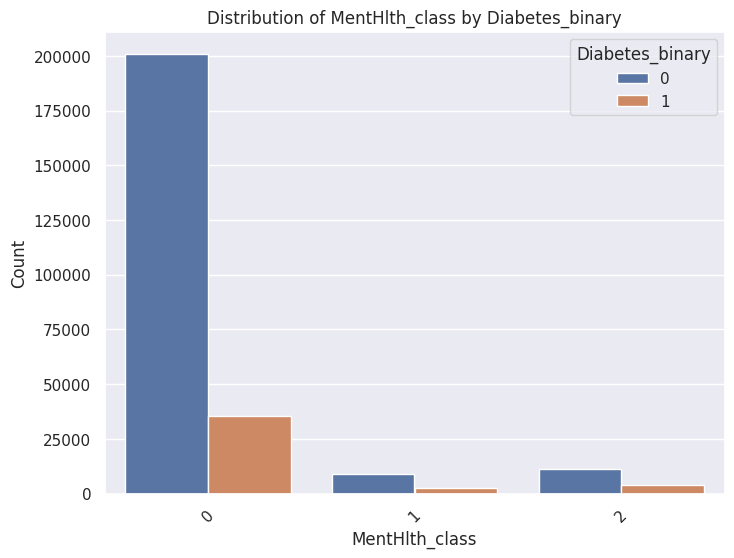

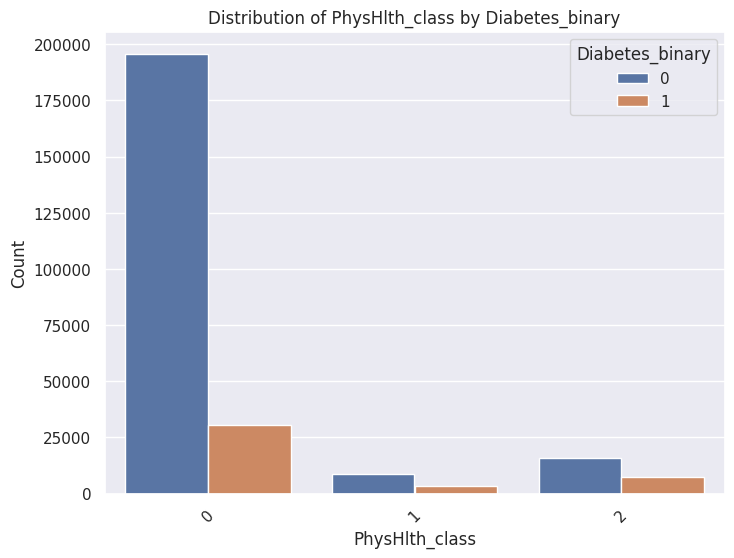

In [ ]:
# EDA: Bivariate
# List of categorical variables you want to pair with Diabetes_binary
categorical_columns = [col for col in df_2015.columns]

# Drop Diabetes_binary from the list, as it will be paired with all other categorical variables
categorical_columns.remove('Diabetes_binary')

# Create pairwise count plots
for cat_col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=cat_col, hue='Diabetes_binary', data=df_2015)
    plt.title(f'Distribution of {cat_col} by Diabetes_binary')
    plt.xlabel(cat_col)
    plt.ylabel('Count')
    plt.legend(title='Diabetes_binary', loc='upper right')
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.show()

### EDA: Association Test Using Chi-Square, Cramer's V
- Cramer's V measures the strength of the relationship between two categorical variables.

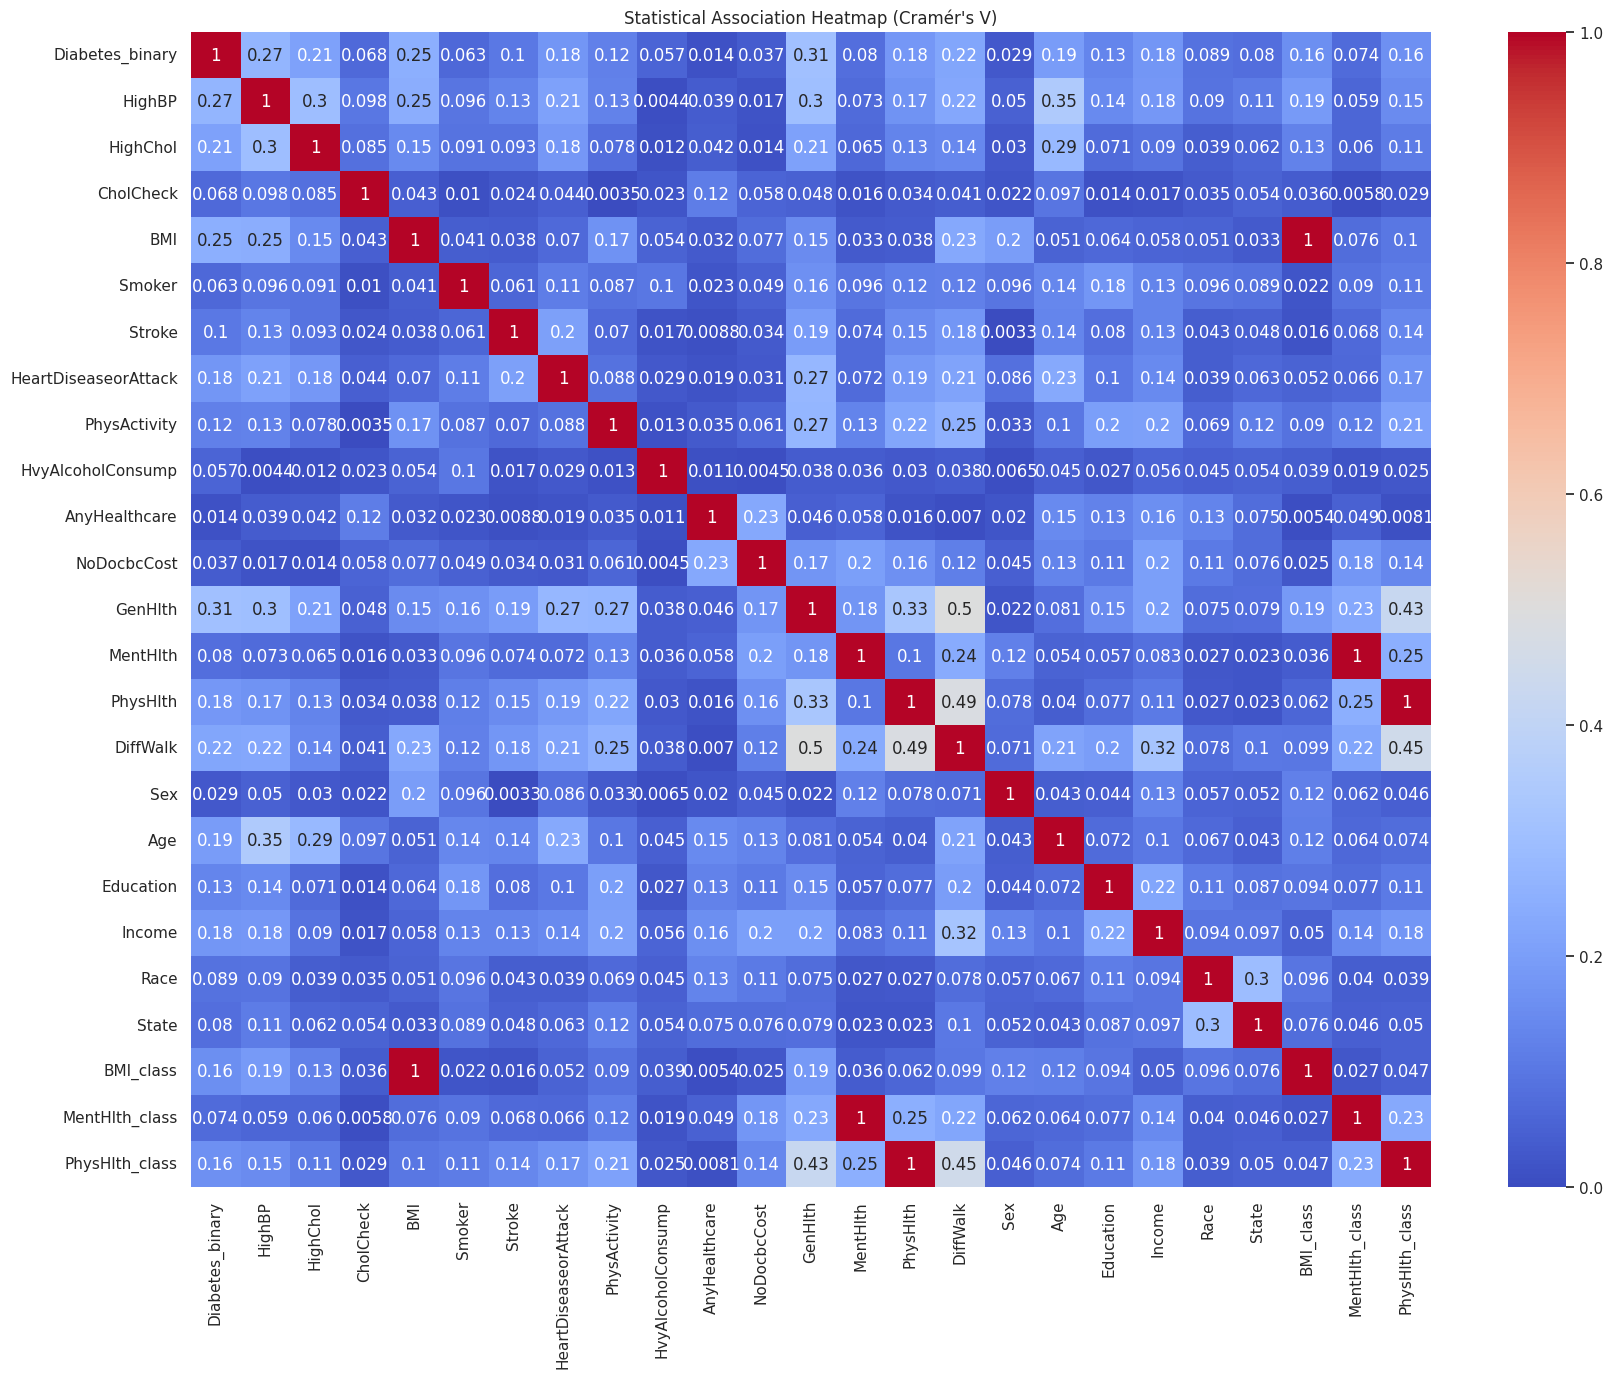

In [ ]:
# EDA: Association Test Chi-Square, Cremer's V
from scipy.stats import chi2_contingency

# Function to compute Cramér's V
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Initialize a matrix to store Cramér's V values for association strength
assoc_matrix = pd.DataFrame(index=df_2015.columns, columns=df_2015.columns)

# Calculate Cramér’s V for all pairs based on Chi-square tests
for col1 in df_2015.columns:
    for col2 in df_2015.columns:
        if col1 == col2:
            assoc_matrix.loc[col1, col2] = 1  # Perfect association with self
        else:
            # Perform Chi-square test of independence
            assoc_matrix.loc[col1, col2] = cramers_v(df_2015[col1], df_2015[col2])

# Convert to float for visualization
assoc_matrix = assoc_matrix.astype(float)

# Plotting heatmap for Cramér’s V values
plt.figure(figsize=(20, 15))
sns.heatmap(assoc_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Statistical Association Heatmap (Cramér's V)")
plt.show()

## 2. EDA of 2023 Dataset

In [53]:
# load in data cleaned from previous section
# set you file path where data saved
DATA_PATH = "" # replace with your path
# Load Data
#df = pd.read_csv('cdc2023_df_cleaned_12062024.csv')
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/cdc2023_df_cleaned_12062024.csv')

# show head of df
df.head()

Diabetes_binary  HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  \
0                0       1         1          1   22       1       0   
1                1       1         0          1   26       0       0   
2                0       1         1          1   30       0       0   
3                0       1         1          1   33       0       0   
4                1       1         1          1   23       1       0   

   HeartDiseaseorAttack  PhysActivity  HvyAlcoholConsump  ...  DiffWalk  Sex  \
0                     0             1                  0  ...         1    0   
1                     0             1                  0  ...         1    0   
2                     0             1                  0  ...         0    0   
3                     0             0                  0  ...         1    0   
4                     1             1                  0  ...         0    1   

   Age  Education  Income  Race  State  BMI_class  MentHlth_class  \
0   13          4       2     2      1          0               0   
1   12          5       7     1      1          1               0   
2    9          5       7     2      1          1               0   
3   13          5       6     2      1          1               0   
4   12          4       7     1      1          0               0   

   PhysHlth_class  
0               0  
1               0  
2               0  
3               0  
4               0  

[5 rows x 25 columns]

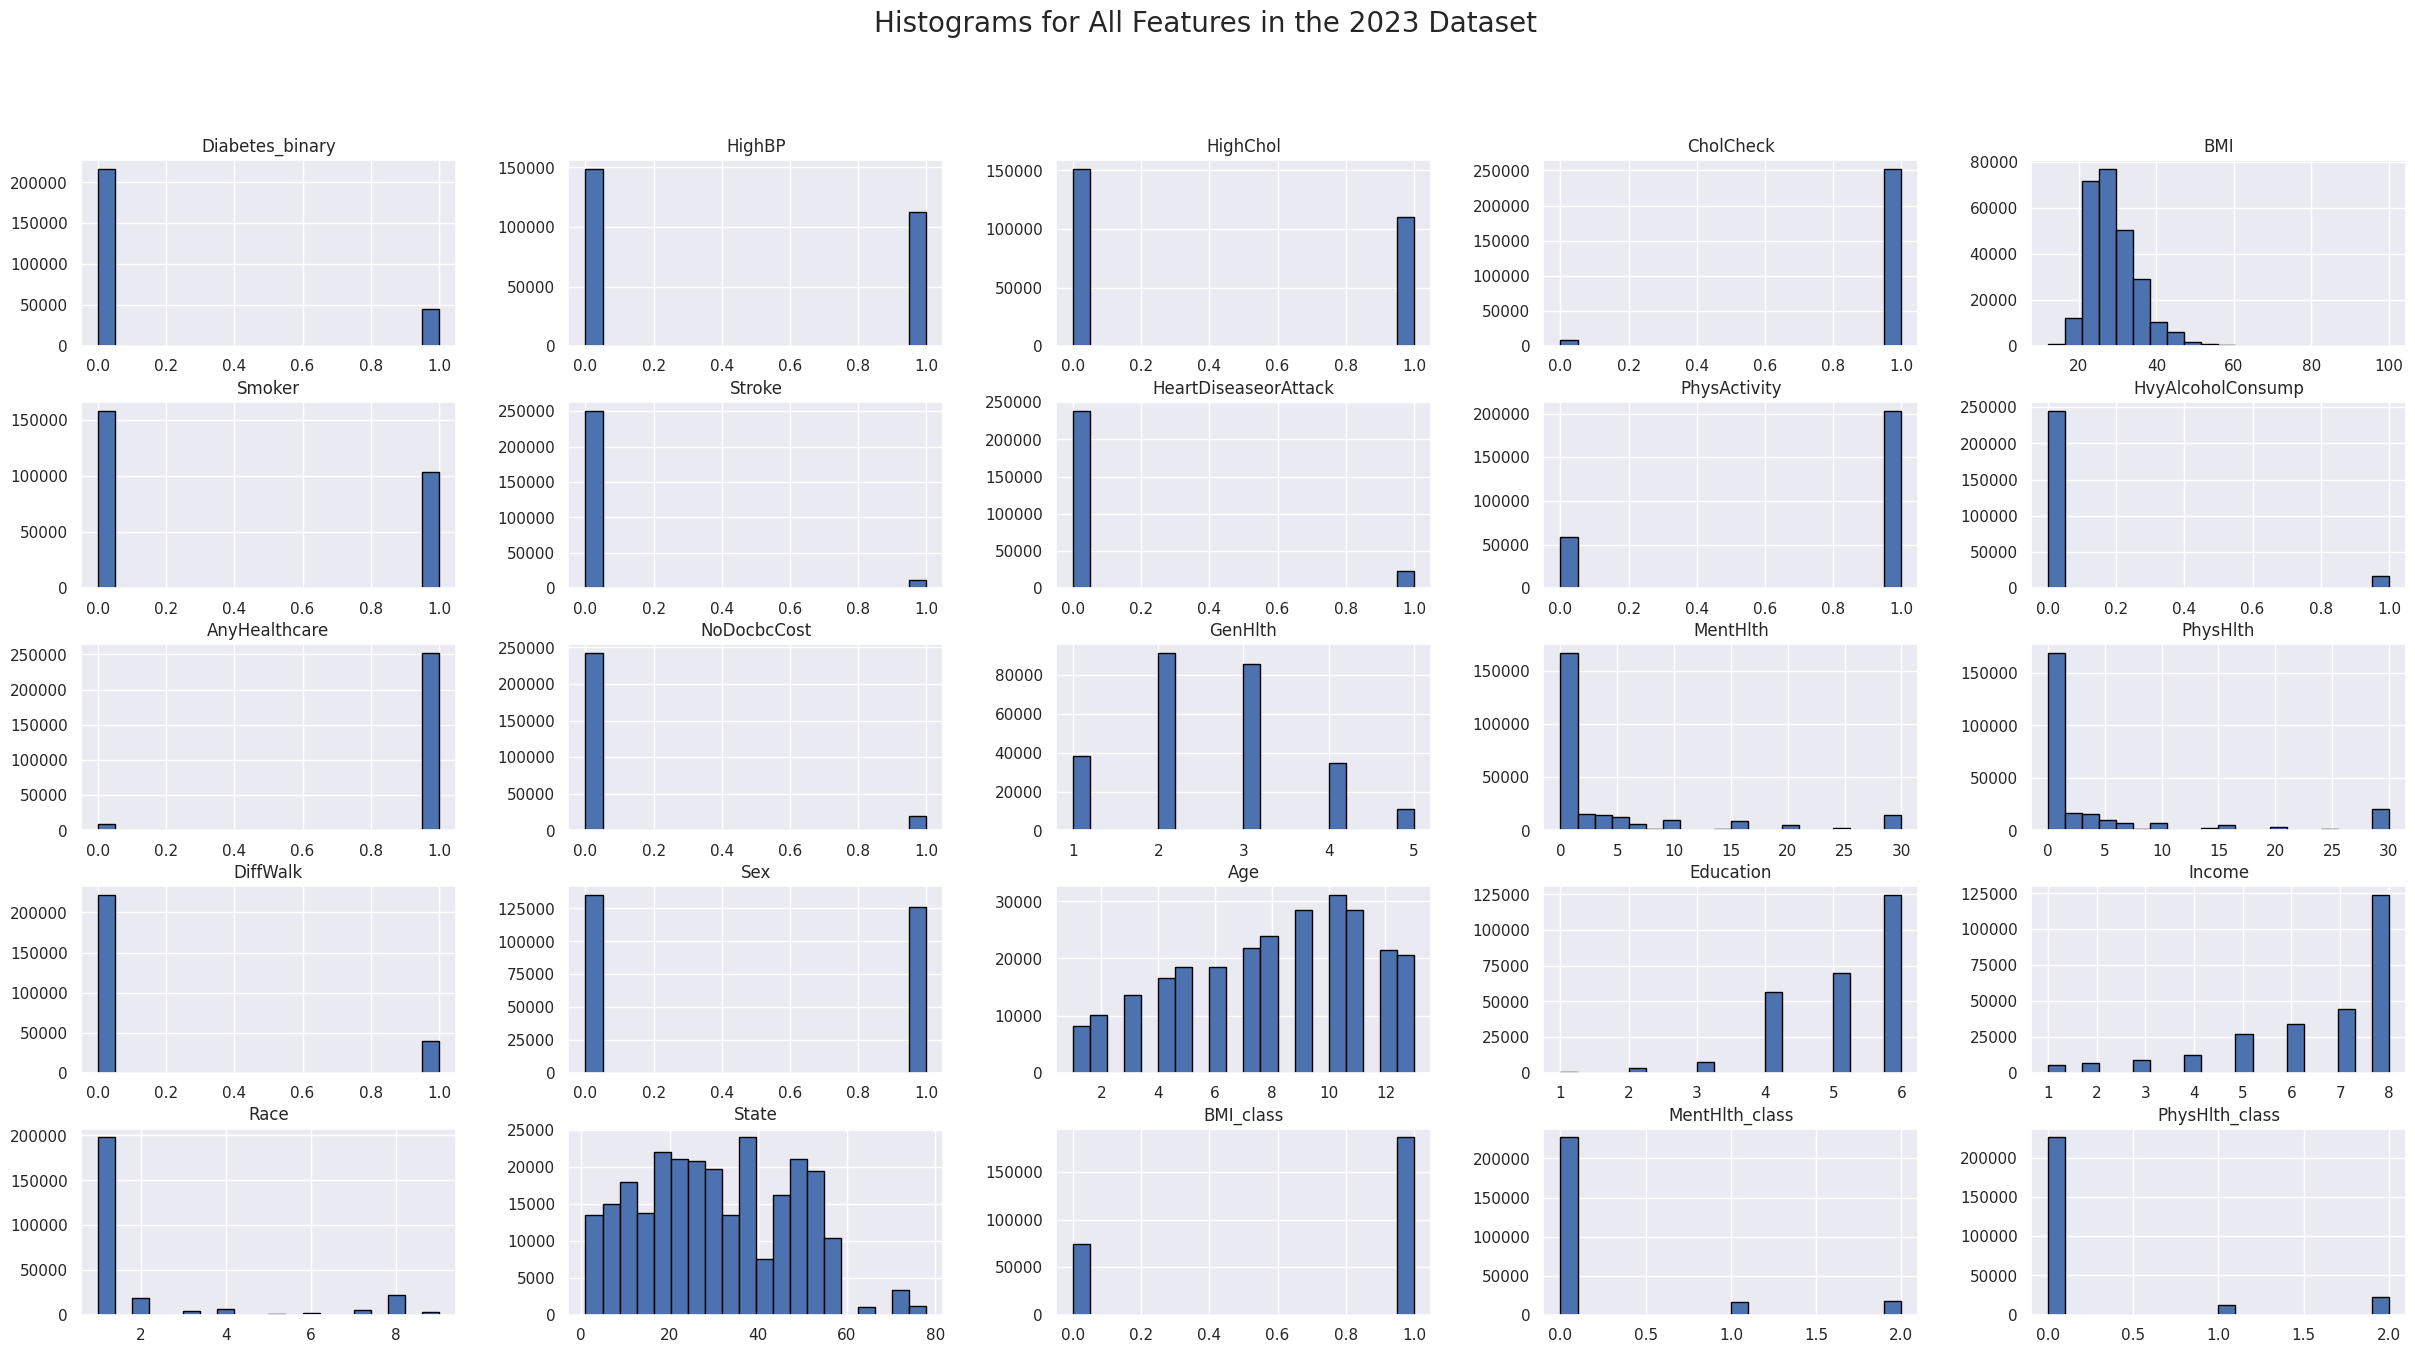

In [54]:
# EDA: Univariate Analysis for 2023 Dataset
df.hist(figsize=(30, 15), bins=20, edgecolor='black')
plt.suptitle("Histograms for All Features in the 2023 Dataset", fontsize=20)
plt.show()

### EDA Bivariate

Class Distribution in 'Diabetes_binary':
Diabetes_binary
0    216724
1     44821
Name: count, dtype: int64


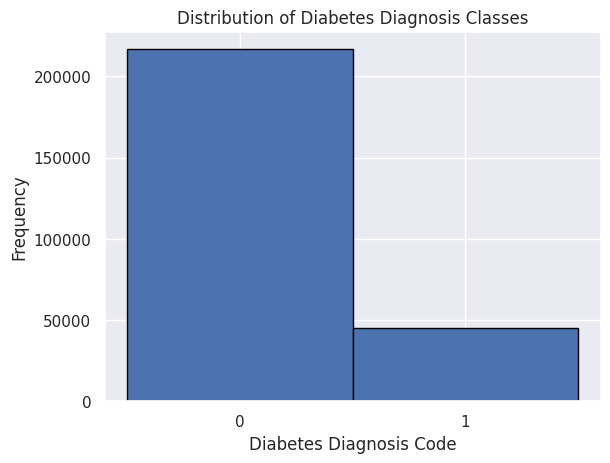

In [55]:
# Check for class imbalance in the 2023 dataset
if 'Diabetes_binary' in df.columns:  # Ensure the column exists in the dataset
    print("Class Distribution in 'Diabetes_binary':")
    print(df['Diabetes_binary'].value_counts())

    # Plotting the distribution
    plt.hist(df['Diabetes_binary'], bins=np.arange(-0.5, 2, 1), edgecolor='black')
    plt.xticks(np.arange(0, 2, 1) , labels=['0', '1'])
    plt.xlabel('Diabetes Diagnosis Code')
    plt.ylabel('Frequency')
    plt.title('Distribution of Diabetes Diagnosis Classes')
    plt.show()
else:
    print("'Diabetes_binary' column not found in the dataset.")

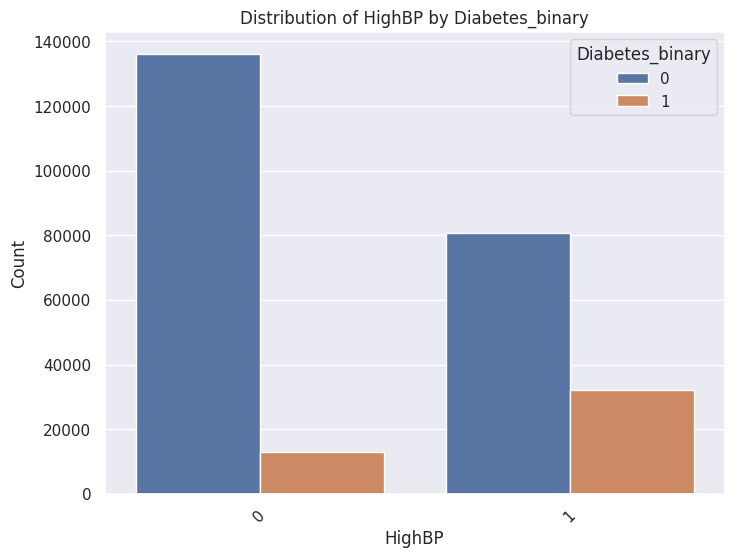

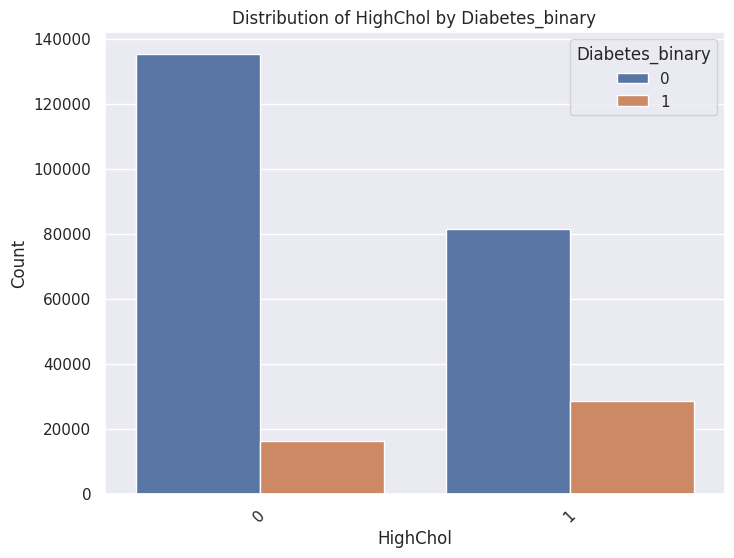

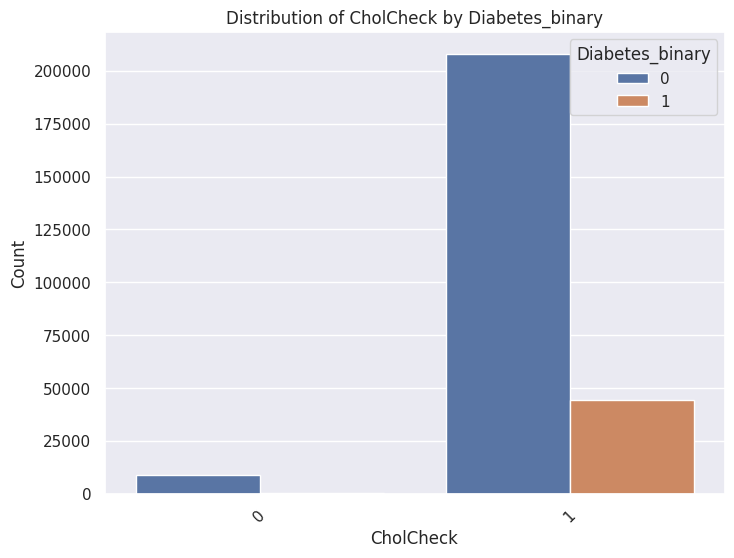

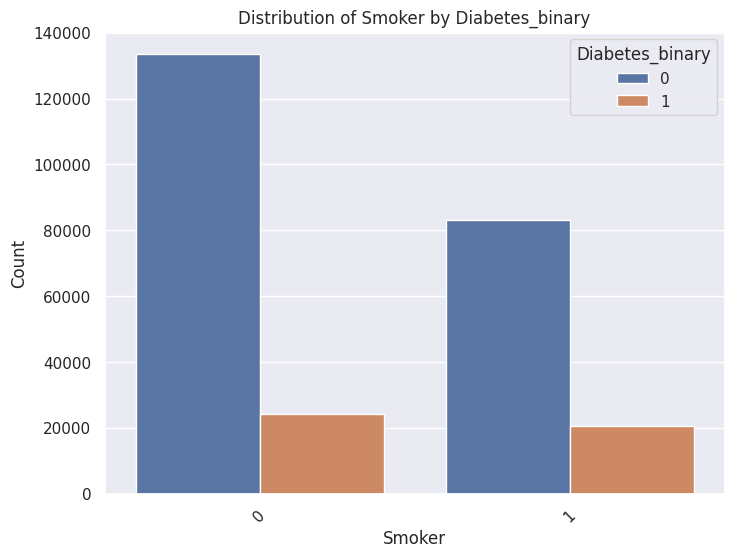

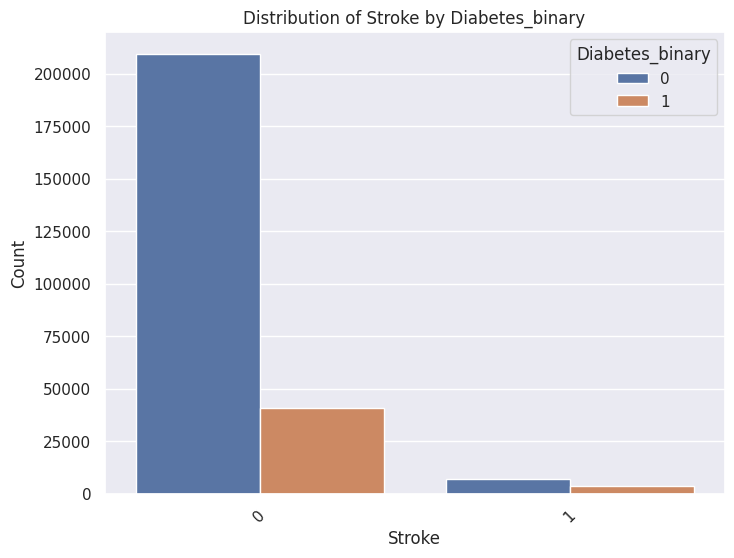

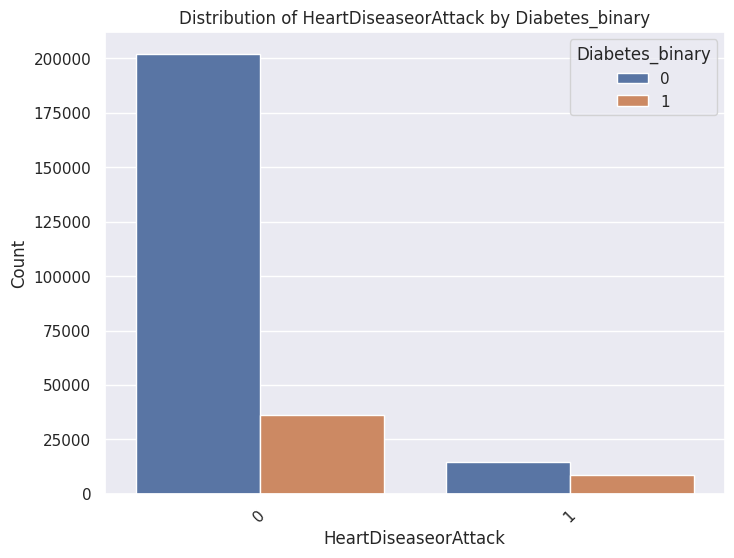

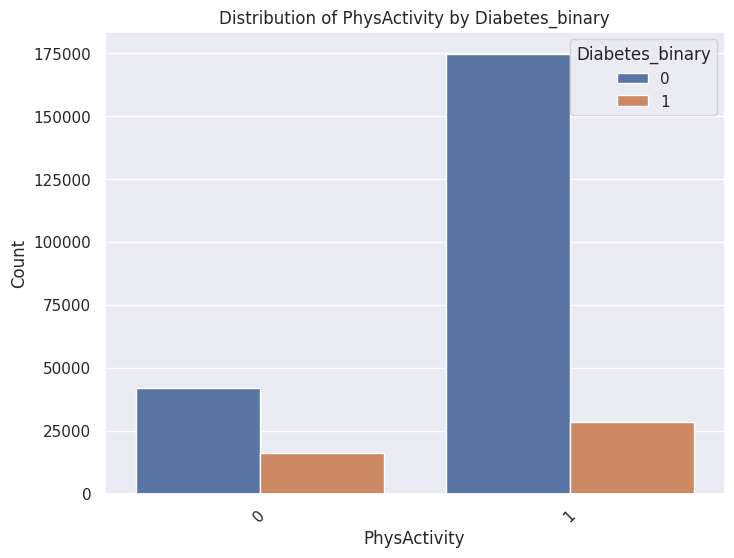

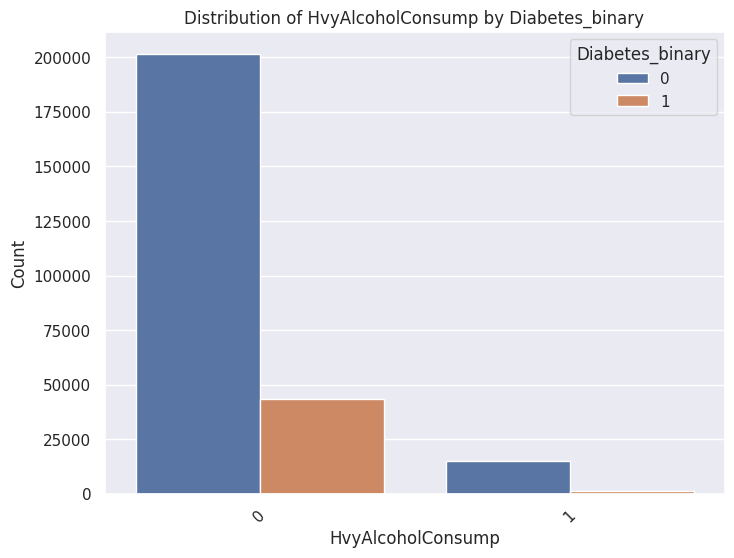

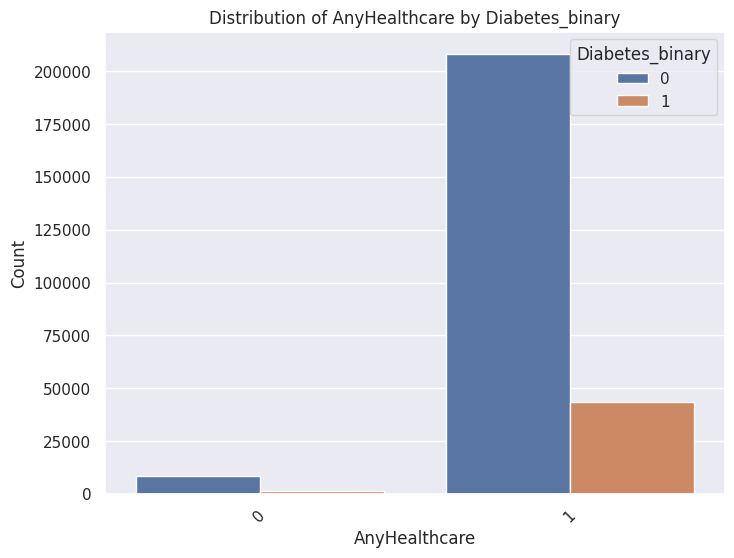

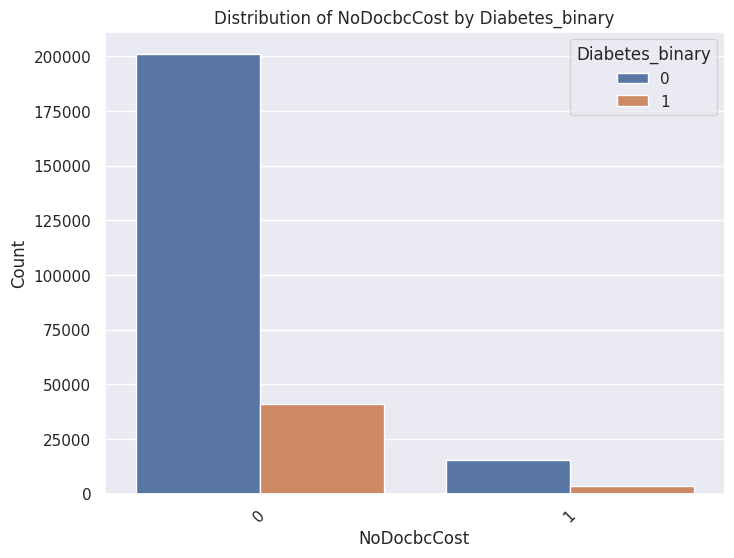

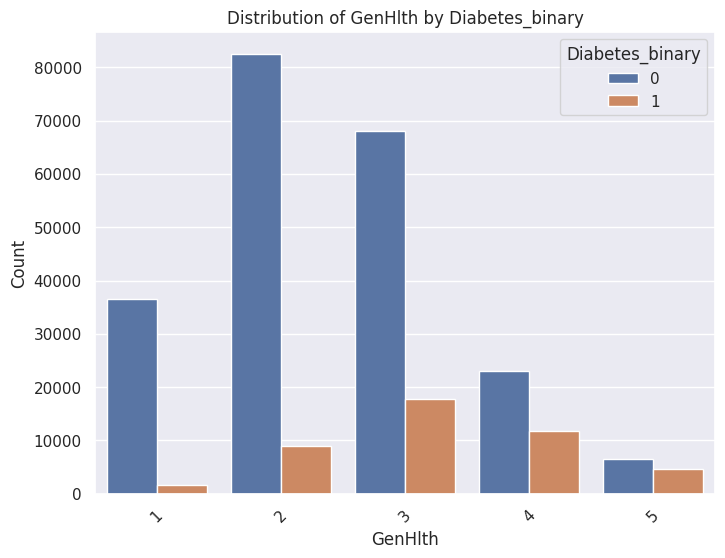

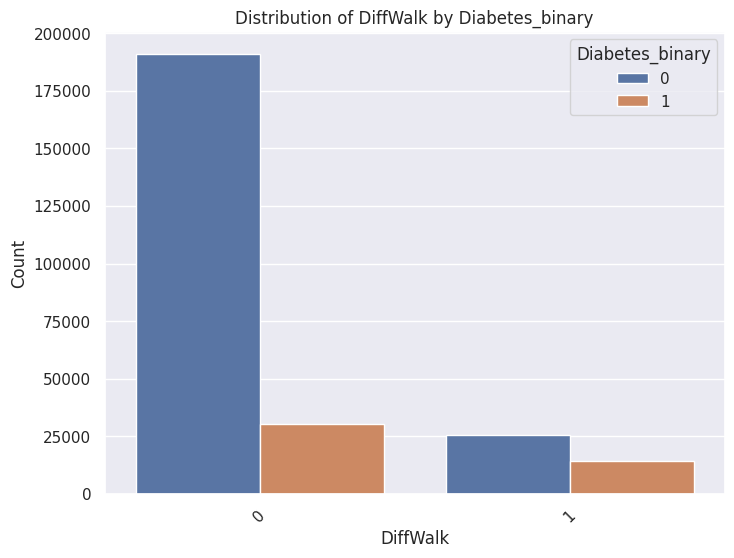

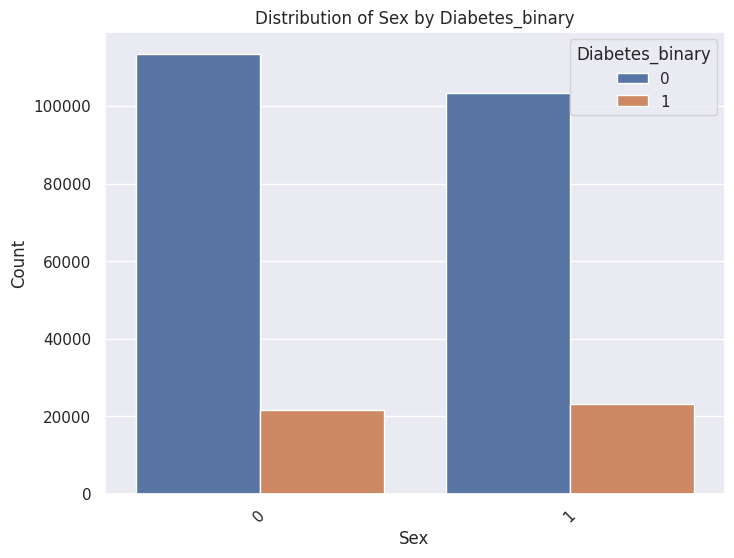

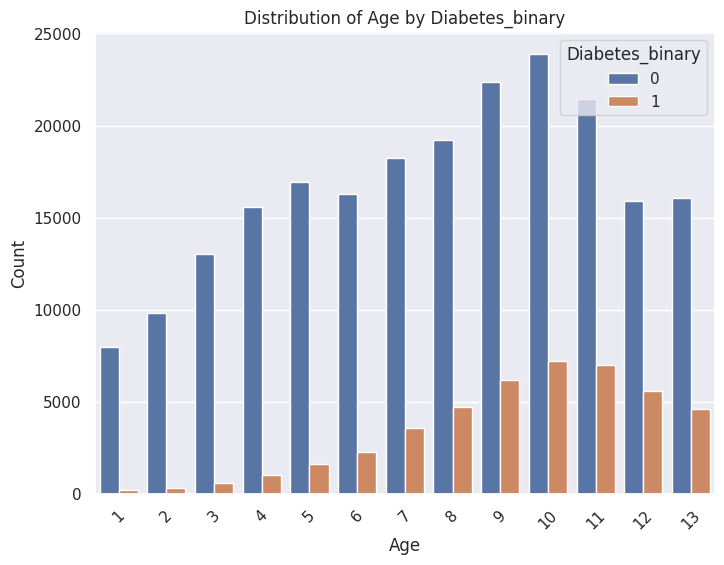

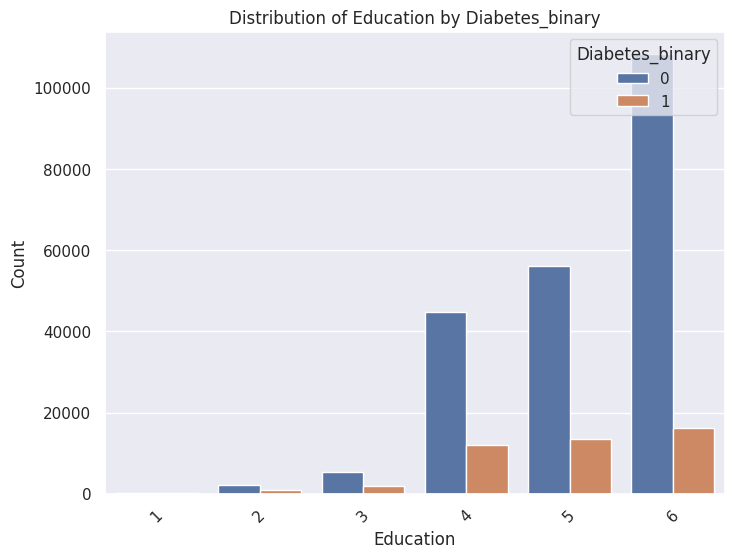

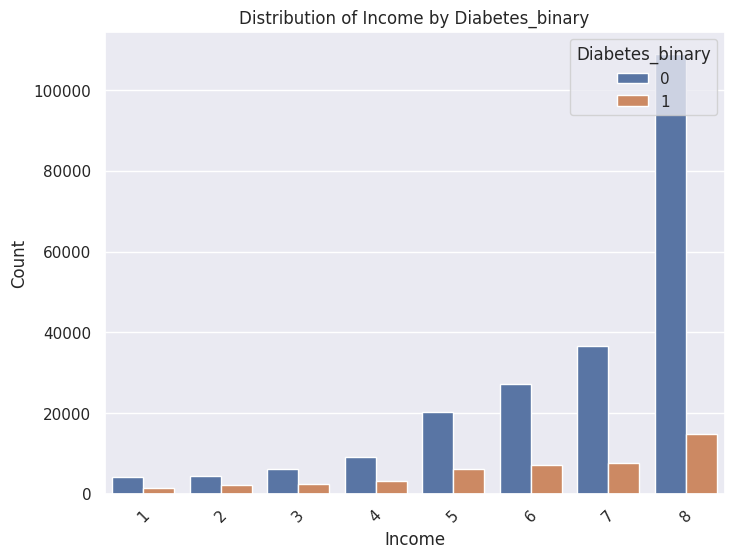

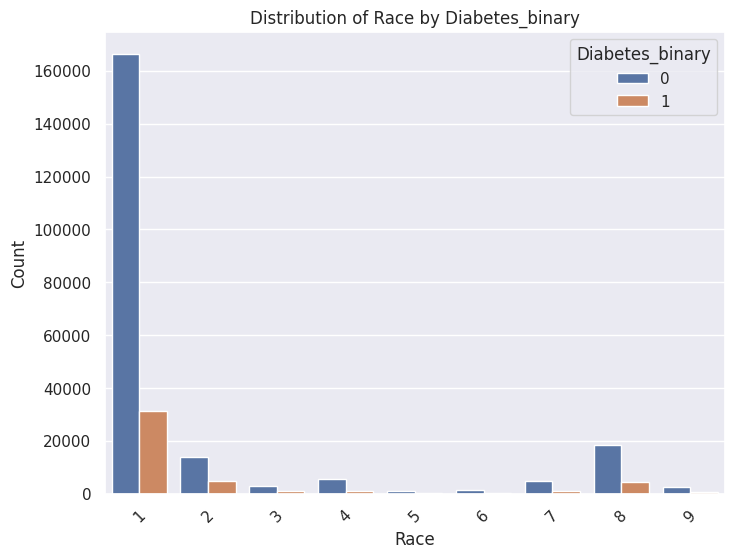

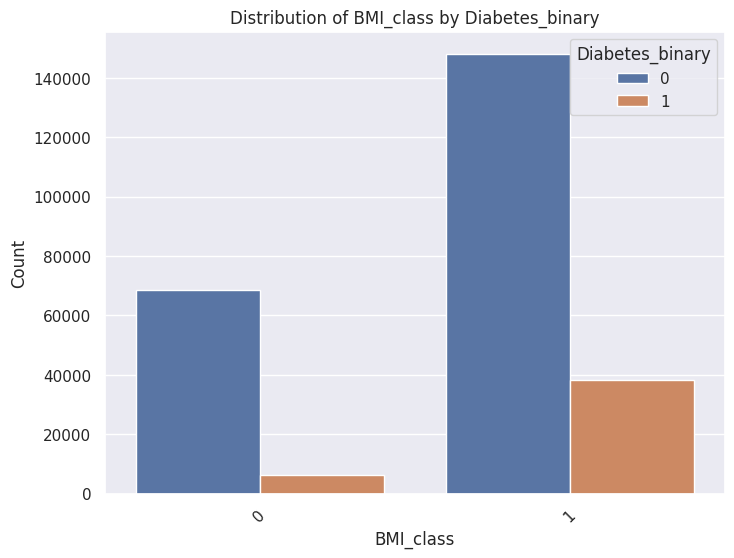

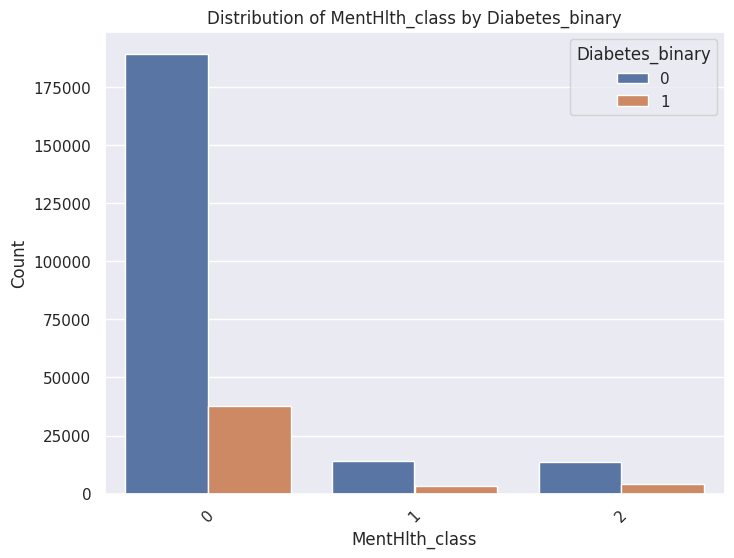

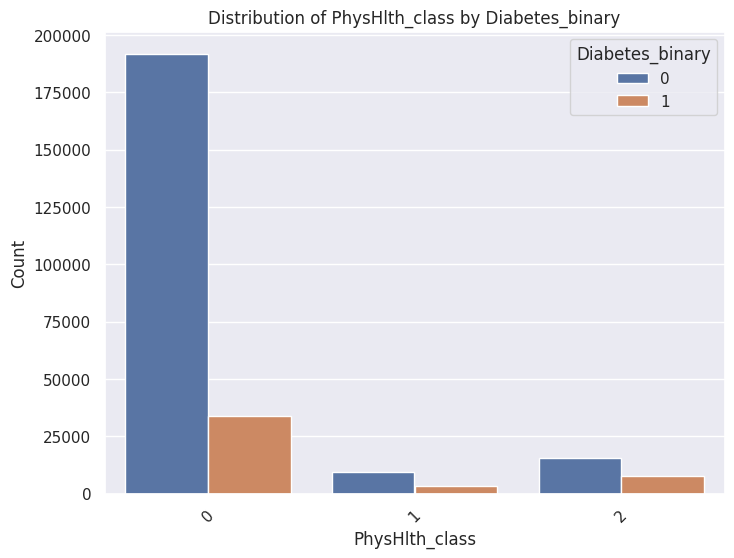

In [56]:
# List of categorical variables to pair with 'Diabetes_binary'
categorical_columns = [col for col in df.columns if df[col].dtype == 'object' or df[col].nunique() < 20]

# Drop 'Diabetes_binary' from the list, as it will be used for grouping
if 'Diabetes_binary' in categorical_columns:
    categorical_columns.remove('Diabetes_binary')

# Create pairwise count plots for each categorical variable vs 'Diabetes_binary'
for cat_col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=cat_col, hue='Diabetes_binary', data=df)
    plt.title(f'Distribution of {cat_col} by Diabetes_binary')
    plt.xlabel(cat_col)
    plt.ylabel('Count')
    plt.legend(title='Diabetes_binary', loc='upper right')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()


# III. Data Pre-processing for Modeling

In [ ]:
# Remove BMI as we have categorical coding binary 1 if BMI >=25 aka overweight
# and not going to use state
# Remove mental and physical health raw variables as they are also coded into 3-class vars

columns = ['BMI', 'MentHlth', 'PhysHlth', 'State']
df_2015 = df_2015.drop(columns, axis= 1)
df_2023 = df_2023.drop(columns , axis= 1 )

#Display the data type
print('Data type of each column :\n',df_2015.dtypes)
print('-'*20)

# Data has no missing values
#print the shape of data
print('The shape of data :\n', df_2015.shape)
print('-'*20)

Data type of each column :
 Diabetes_binary         int64
HighBP                  int64
HighChol                int64
CholCheck               int64
Smoker                  int64
Stroke                  int64
HeartDiseaseorAttack    int64
PhysActivity            int64
HvyAlcoholConsump       int64
AnyHealthcare           int64
NoDocbcCost             int64
GenHlth                 int64
DiffWalk                int64
Sex                     int64
Age                     int64
Education               int64
Income                  int64
Race                    int64
BMI_class               int64
MentHlth_class          int64
PhysHlth_class          int64
dtype: object
--------------------
The shape of data :
 (262418, 21)
--------------------


In [ ]:
#Display the data type
print('Data type of each column :\n',df_2023.dtypes)
print('-'*20)

# Data has no missing values
#print the shape of data
print('The shape of data :\n', df_2023.shape)
print('-'*20)

Data type of each column :
 Diabetes_binary         int64
HighBP                  int64
HighChol                int64
CholCheck               int64
Smoker                  int64
Stroke                  int64
HeartDiseaseorAttack    int64
PhysActivity            int64
HvyAlcoholConsump       int64
AnyHealthcare           int64
NoDocbcCost             int64
GenHlth                 int64
DiffWalk                int64
Sex                     int64
Age                     int64
Education               int64
Income                  int64
Race                    int64
BMI_class               int64
MentHlth_class          int64
PhysHlth_class          int64
dtype: object
--------------------
The shape of data :
 (261545, 21)
--------------------


### 2015: Convert Categorical Variables to Dummy Variables via One-Hot Encoding

In [ ]:
# Recode categorical variables into multiple dummy variables by using One-Hot Encoder

# Define the categorical columns to encode
categorical_columns = ['GenHlth', 'MentHlth_class', 'PhysHlth_class', 'Age', 'Education', 'Income']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(drop = None, sparse_output = False)

# Apply one-hot encoding to the specified categorical columns
encoded_data = encoder.fit_transform(df_2015[categorical_columns])

# Get the column names for the one-hot encoded variables
encoded_columns = encoder.get_feature_names_out(categorical_columns)

# Create a new DataFrame for the encoded data
encoded_df = pd.DataFrame(encoded_data, columns = encoded_columns, index = df_2015.index)

# Merge the one-hot encoded variables back into the dataset
df_2015 = pd.concat([df_2015, encoded_df], axis = 1)

# Display the first few rows of the updated DataFrame
df_2015.head()

Diabetes_binary  HighBP  HighChol  CholCheck  Smoker  Stroke  \
0                0       1         1          1       1       0   
1                0       0         0          0       1       0   
2                0       1         1          1       0       0   
3                0       1         0          1       0       0   
4                0       1         1          1       0       0   

   HeartDiseaseorAttack  PhysActivity  HvyAlcoholConsump  AnyHealthcare  ...  \
0                     0             0                  0              1  ...   
1                     0             1                  0              0  ...   
2                     0             0                  0              1  ...   
3                     0             1                  0              1  ...   
4                     0             1                  0              1  ...   

   Education_5  Education_6  Income_1  Income_2  Income_3  Income_4  Income_5  \
0          0.0          0.0       0.0       0.0       1.0       0.0       0.0   
1          0.0          1.0       1.0       0.0       0.0       0.0       0.0   
2          0.0          0.0       0.0       0.0       0.0       0.0       0.0   
3          0.0          0.0       0.0       0.0       0.0       0.0       0.0   
4          1.0          0.0       0.0       0.0       0.0       1.0       0.0   

   Income_6  Income_7  Income_8  
0       0.0       0.0       0.0  
1       0.0       0.0       0.0  
2       0.0       0.0       1.0  
3       1.0       0.0       0.0  
4       0.0       0.0       0.0  

[5 rows x 59 columns]

In [ ]:
df_2015 = df_2015.astype('int64')

#Display the data type
print('Data type of each column :\n',df_2015.dtypes)
print('-'*20)

# Data has no missing values
#print the shape of data
print('The shape of data :\n', df_2015.shape)
print('-'*20)

Data type of each column :
 Diabetes_binary         int64
HighBP                  int64
HighChol                int64
CholCheck               int64
Smoker                  int64
Stroke                  int64
HeartDiseaseorAttack    int64
PhysActivity            int64
HvyAlcoholConsump       int64
AnyHealthcare           int64
NoDocbcCost             int64
GenHlth                 int64
DiffWalk                int64
Sex                     int64
Age                     int64
Education               int64
Income                  int64
Race                    int64
BMI_class               int64
MentHlth_class          int64
PhysHlth_class          int64
GenHlth_1               int64
GenHlth_2               int64
GenHlth_3               int64
GenHlth_4               int64
GenHlth_5               int64
MentHlth_class_0        int64
MentHlth_class_1        int64
MentHlth_class_2        int64
PhysHlth_class_0        int64
PhysHlth_class_1        int64
PhysHlth_class_2        int64
Age_1       

In [ ]:
# Show Unique Values for Each Variable
for column in df_2015.columns:
    unique_values = df_2015[column].unique()
    print(f"Column: {column}")
    print(f"Unique values ({len(unique_values)}): {unique_values}")
    print("-" * 40)

Column: Diabetes_binary
Unique values (2): [0 1]
----------------------------------------
Column: HighBP
Unique values (2): [1 0]
----------------------------------------
Column: HighChol
Unique values (2): [1 0]
----------------------------------------
Column: CholCheck
Unique values (2): [1 0]
----------------------------------------
Column: Smoker
Unique values (2): [1 0]
----------------------------------------
Column: Stroke
Unique values (2): [0 1]
----------------------------------------
Column: HeartDiseaseorAttack
Unique values (2): [0 1]
----------------------------------------
Column: PhysActivity
Unique values (2): [0 1]
----------------------------------------
Column: HvyAlcoholConsump
Unique values (2): [0 1]
----------------------------------------
Column: AnyHealthcare
Unique values (2): [1 0]
----------------------------------------
Column: NoDocbcCost
Unique values (2): [0 1]
----------------------------------------
Column: GenHlth
Unique values (5): [5 3 2 4 1]
-----

### 2023: Convert Categorical Variable to Dummy Variables via One-Hot Encoding

In [ ]:
# Recode categorical variables into multiple dummy variables by using One-Hot Encoder

# Define the categorical columns to encode
categorical_columns = ['GenHlth','MentHlth_class','PhysHlth_class', 'Age', 'Education', 'Income']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(drop = None, sparse_output = False)

# Apply one-hot encoding to the specified categorical columns
encoded_data = encoder.fit_transform(df_2023[categorical_columns])

# Get the column names for the one-hot encoded variables
encoded_columns = encoder.get_feature_names_out(categorical_columns)

# Create a new DataFrame for the encoded data
encoded_df = pd.DataFrame(encoded_data, columns = encoded_columns, index = df_2023.index)

# Merge the one-hot encoded variables back into the dataset
df_2023 = pd.concat([df_2023, encoded_df], axis=1)

# Display the first few rows of the updated DataFrame
df_2023.head()


Diabetes_binary  HighBP  HighChol  CholCheck  Smoker  Stroke  \
0                0       1         1          1       1       0   
1                1       1         0          1       0       0   
2                0       1         1          1       0       0   
3                0       1         1          1       0       0   
4                1       1         1          1       1       0   

   HeartDiseaseorAttack  PhysActivity  HvyAlcoholConsump  AnyHealthcare  ...  \
0                     0             1                  0              1  ...   
1                     0             1                  0              1  ...   
2                     0             1                  0              1  ...   
3                     0             0                  0              1  ...   
4                     1             1                  0              1  ...   

   Education_5  Education_6  Income_1  Income_2  Income_3  Income_4  Income_5  \
0          0.0          0.0       0.0       1.0       0.0       0.0       0.0   
1          1.0          0.0       0.0       0.0       0.0       0.0       0.0   
2          1.0          0.0       0.0       0.0       0.0       0.0       0.0   
3          1.0          0.0       0.0       0.0       0.0       0.0       0.0   
4          0.0          0.0       0.0       0.0       0.0       0.0       0.0   

   Income_6  Income_7  Income_8  
0       0.0       0.0       0.0  
1       0.0       1.0       0.0  
2       0.0       1.0       0.0  
3       1.0       0.0       0.0  
4       0.0       1.0       0.0  

[5 rows x 59 columns]

In [ ]:
df_2023 = df_2023.astype('int64')

#Display the data type
print('Data type of each column :\n',df_2023.dtypes)
print('-'*20)

# Data has no missing values
#print the shape of data
print('The shape of data :\n', df_2023.shape)
print('-'*20)

Data type of each column :
 Diabetes_binary         int64
HighBP                  int64
HighChol                int64
CholCheck               int64
Smoker                  int64
Stroke                  int64
HeartDiseaseorAttack    int64
PhysActivity            int64
HvyAlcoholConsump       int64
AnyHealthcare           int64
NoDocbcCost             int64
GenHlth                 int64
DiffWalk                int64
Sex                     int64
Age                     int64
Education               int64
Income                  int64
Race                    int64
BMI_class               int64
MentHlth_class          int64
PhysHlth_class          int64
GenHlth_1               int64
GenHlth_2               int64
GenHlth_3               int64
GenHlth_4               int64
GenHlth_5               int64
MentHlth_class_0        int64
MentHlth_class_1        int64
MentHlth_class_2        int64
PhysHlth_class_0        int64
PhysHlth_class_1        int64
PhysHlth_class_2        int64
Age_1       

### Check if 2015 and 2023 now have same features

In [ ]:
# Check if 2015 and 2023 now have same features

# Data has no missing values
#print the shape of data
print('The shape of data :\n', df_2015.shape)
print('-'*20)

The shape of data :
 (262418, 59)
--------------------


In [ ]:
# Check if 2015 and 2023 now have same features

# Data has no missing values
#print the shape of data
print('The shape of data :\n', df_2023.shape)
print('-'*20)

The shape of data :
 (261545, 59)
--------------------


In [ ]:
# save as csv
df_2023.to_csv('cdc2023_df_cleaned_modeling.csv', index=False)

df_2015.to_csv('cdc2015_df_cleaned_modeling.csv', index=False)

# IV. Data Splits for Modeling

1. Train Model 1 on 2015 SMOTE adjusted train data.

Our research question is: How effective is a model trained with old 2015 data on predicting diabetes risk in newer 2023 data?
- H0: 2014 model will have same accuracy on 2023 data
- H1: 2014 model will have different accuracy on 2023 data

We expect 2014 model will have lower accuracy on 2023 data since population health behavior shifts are likely over an almost 10 year gap.

2. Train Model 2 on combined 2015 and 2023 SMOTE adjusted train data.

Our research question is: Whether a model trained with combined data could have better performance/accuracy on the new 2023 data?
- H0:Combined model will have similar performance as 2014 model
- H1:Combined model will have different performance than 2014 model

We expect to see the combined model having better performance than 2014 model since we provided larger training samples covering a wider range of health behaviors.


**Split logic for train, validation, and test:**

2015 data --> split X and Y into:
- X_train_2015, y_train_2015 --> X_train_2015_mini, y_train_2015_mini [SMOTE applied versions of train]
- X_val_2015, y_val_2015
- X_test_2015, y_test_2015

2023 data --> split X and Y into:
- X_train_2023, y_train_2023 --> X_train_2023_mini, y_train_2023_mini [SMOTE applied versions of train]
- X_val_2023, y_val_2023
- X_test_2023, y_test_2023

Combined --> combine the dfs for 2015 and 2023:
- X_combined_train, y_combined_train
- X_combined_val, y_combined_val
- X_Combined_test, y_combined_test

**Model evaluation implications:**

Model 1: trained on 2015 data (SMOTE balanced train)
- val and test on 2015
- Test on 2023

Model 2: train on the combined 2015 and 2023 train SMOTE balanced sets
- Val and test on combined 2023 and 2015 val and test sets
- Test on 2023 test

## 1. Split 2015 and 2023 datasets into train, validation, and test datasets

In [5]:
# mount to GDrive or local file path where data files were saved
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# # load in data
# df_2023 = pd.read_csv('cdc2023_df_cleaned_modeling.csv')
# df_2015 = pd.read_csv('cdc2015_df_cleaned_modeling.csv')

# load in data
df_2023 = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/cdc2023_df_cleaned_modeling.csv')
df_2015 = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/cdc2015_df_cleaned_modeling.csv')

In [7]:
# Reset the index and shuffle the datasets
df_2015 = df_2015.reset_index(drop=True).sample(frac=1, random_state=42)  # Shuffle and set seed
df_2023 = df_2023.reset_index(drop=True).sample(frac=1, random_state=42)  # Shuffle

In [8]:
#Define a function for splitting data
def split_data(df, target_column, subgroup_columns):
   # Separate features and target
   X = df.drop(columns=[target_column])
   y = df[target_column]

   # Train-test split (60% train, 40% temp) => adjust % for train set
   X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1234) # set seed

   # Validation-test split (20% val, 20% test)
   X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1234)

   # Extract subgroup variables and keep track of the original index
   subgroup_train = X_train[subgroup_columns].assign(split="train", original_index=X_train.index)
   subgroup_val = X_val[subgroup_columns].assign(split="val", original_index=X_val.index)
   subgroup_test = X_test[subgroup_columns].assign(split="test", original_index=X_test.index)

   # Return data including the subgroups separately
   return X_train, X_val, X_test, y_train, y_val, y_test, subgroup_train, subgroup_val, subgroup_test

In [9]:
#Columns to use for subgroup analysis
# note, we did not get to this in our project, but kept the code so it is available for future work
subgroup_columns = ["Age", "Race", "Sex"]

#Split the 2015 dataset
X_train_2015, X_val_2015, X_test_2015, y_train_2015, y_val_2015, y_test_2015, \
subgroup_train_2015, subgroup_val_2015, subgroup_test_2015 = split_data(
   df_2015, target_column="Diabetes_binary", subgroup_columns=subgroup_columns
)

#Split the 2023 dataset
X_train_2023, X_val_2023, X_test_2023, y_train_2023, y_val_2023, y_test_2023, \
subgroup_train_2023, subgroup_val_2023, subgroup_test_2023 = split_data(
   df_2023, target_column="Diabetes_binary", subgroup_columns=subgroup_columns
)

#Check the subgroup data for each year (train, val, test separate for each year)
print("Subgroup train data for 2015:")
print(subgroup_train_2015.head())
print("\nSubgroup val data for 2015:")
print(subgroup_val_2015.head())
print("\nSubgroup test data for 2015:")
print(subgroup_test_2015.head())

print("\nSubgroup train data for 2023:")
print(subgroup_train_2023.head())
print("\nSubgroup val data for 2023:")
print(subgroup_val_2023.head())
print("\nSubgroup test data for 2023:")
print(subgroup_test_2023.head())

Subgroup train data for 2015:
        Age  Race  Sex  split  original_index
259795    6     1    1  train          259795
221756   11     1    0  train          221756
49098     9     1    0  train           49098
73546     9     1    1  train           73546
157668   13     1    0  train          157668

Subgroup val data for 2015:
        Age  Race  Sex split  original_index
11296     2     1    1   val           11296
196453   12     1    0   val          196453
213236    8     1    0   val          213236
45132     6     1    0   val           45132
247385    8     1    1   val          247385

Subgroup test data for 2015:
        Age  Race  Sex split  original_index
252645    9     1    1  test          252645
115858    9     1    1  test          115858
196864   12     1    1  test          196864
142475   10     1    1  test          142475
78147    11     1    1  test           78147

Subgroup train data for 2023:
        Age  Race  Sex  split  original_index
171181    7     8 

In [10]:
# drop race from all X train, test, and val
X_train_2015 = X_train_2015.drop(columns = ["Race"])
X_train_2023 = X_train_2023.drop(columns = ["Race"])
X_val_2015 = X_val_2015.drop(columns = ["Race"])
X_val_2023 = X_val_2023.drop(columns = ["Race"])
X_test_2015 = X_test_2015.drop(columns = ["Race"])
X_test_2023 = X_test_2023.drop(columns = ["Race"])

In [11]:
# integer encoding works better for linear models
# one hot encoding for tree based and neural nets

# one set for linear models (Logistic and Gaussian Naive Bayes) - integer encoded
columns = ['GenHlth_1', 'GenHlth_2', 'GenHlth_3', 'GenHlth_4', 'GenHlth_5',
           'MentHlth_class_0', 'MentHlth_class_1', 'MentHlth_class_2',
           'PhysHlth_class_0', 'PhysHlth_class_1', 'PhysHlth_class_2',
           'Age_1', 'Age_2', 'Age_3', 'Age_4', 'Age_5', 'Age_6', 'Age_7',
           'Age_8', 'Age_9', 'Age_10', 'Age_11', 'Age_12', 'Age_13',
           'Education_1', 'Education_2', 'Education_3', 'Education_4',
           'Education_5', 'Education_6', 'Income_1', 'Income_2', 'Income_3',
           'Income_4', 'Income_5', 'Income_6', 'Income_7', 'Income_8']

X_train_2015_LR = X_train_2015.drop(columns=columns)
X_val_2015_LR = X_val_2015.drop(columns=columns)
X_test_2015_LR = X_test_2015.drop(columns=columns)

X_train_2023_LR = X_train_2023.drop(columns=columns)
X_val_2023_LR = X_val_2023.drop(columns=columns)
X_test_2023_LR = X_test_2023.drop(columns=columns)

# other set for all other models - tree based and neural net - one hot encoded
columns = ['GenHlth', 'MentHlth_class', 'PhysHlth_class', 'Age', 'Education', 'Income']

X_train_2015 = X_train_2015.drop(columns=columns)
X_val_2015 = X_val_2015.drop(columns=columns)
X_test_2015 = X_test_2015.drop(columns=columns)

X_train_2023 = X_train_2023.drop(columns=columns)
X_val_2023 = X_val_2023.drop(columns=columns)
X_test_2023 = X_test_2023.drop(columns=columns)

In [12]:
# 2015 data shape
print("2015 Train Shape:", X_train_2015.shape, y_train_2015.shape)
print("2015 Val shape:", X_val_2015.shape, y_val_2015.shape)
print("2015 Test Shape:", X_test_2015.shape, y_test_2015.shape)

# 2023 data shape
print("2023 Train Shape:", X_train_2023.shape, y_train_2023.shape)
print("2023 Val shape:", X_val_2023.shape, y_val_2023.shape)
print("2023 Test Shape:", X_test_2023.shape, y_test_2023.shape)

2015 Train Shape: (157450, 51) (157450,)
2015 Val shape: (52484, 51) (52484,)
2015 Test Shape: (52484, 51) (52484,)
2023 Train Shape: (156927, 51) (156927,)
2023 Val shape: (52309, 51) (52309,)
2023 Test Shape: (52309, 51) (52309,)


In [13]:
# list column names for all train, val and test sets
print("2015 Train Column Names:", X_train_2015.columns)
print("2015 Val Column Names:", X_val_2015.columns)
print("2015 Test Column Names:", X_test_2015.columns)

print("2023 Train Column Names:", X_train_2023.columns)
print("2023 Val Column Names:", X_val_2023.columns)
print("2023 Test Column Names:", X_test_2023.columns)

2015 Train Column Names: Index(['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'HvyAlcoholConsump',
       'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex', 'BMI_class',
       'GenHlth_1', 'GenHlth_2', 'GenHlth_3', 'GenHlth_4', 'GenHlth_5',
       'MentHlth_class_0', 'MentHlth_class_1', 'MentHlth_class_2',
       'PhysHlth_class_0', 'PhysHlth_class_1', 'PhysHlth_class_2', 'Age_1',
       'Age_2', 'Age_3', 'Age_4', 'Age_5', 'Age_6', 'Age_7', 'Age_8', 'Age_9',
       'Age_10', 'Age_11', 'Age_12', 'Age_13', 'Education_1', 'Education_2',
       'Education_3', 'Education_4', 'Education_5', 'Education_6', 'Income_1',
       'Income_2', 'Income_3', 'Income_4', 'Income_5', 'Income_6', 'Income_7',
       'Income_8'],
      dtype='object')
2015 Val Column Names: Index(['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'HvyAlcoholConsump',
       'AnyHealthcare', 'NoDocbcCost', 'DiffWalk',

In [14]:
# 2015 data shape - LR
print("2015 Train Shape - LR:", X_train_2015_LR.shape, y_train_2015.shape)
print("2015 Val Shape - LR:", X_val_2015_LR.shape, y_val_2015.shape)
print("2015 Test Shape - LR:", X_test_2015_LR.shape, y_test_2015.shape)

# 2023 data shape - LR
print("2023 Train Shape - LR:", X_train_2023_LR.shape, y_train_2023.shape)
print("2023 Val Shape - LR:", X_val_2023_LR.shape, y_val_2023.shape)
print("2023 Test Shape - LR:", X_test_2023_LR.shape, y_test_2023.shape)


2015 Train Shape - LR: (157450, 19) (157450,)
2015 Val Shape - LR: (52484, 19) (52484,)
2015 Test Shape - LR: (52484, 19) (52484,)
2023 Train Shape - LR: (156927, 19) (156927,)
2023 Val Shape - LR: (52309, 19) (52309,)
2023 Test Shape - LR: (52309, 19) (52309,)


## 2. Balancing the Training Set via SMOTE

SMOTE is used to address class imbalance in our training dataset. It oversamples the minority class by generating synthetic data (in our case, having diabetes or Diabetes_binay = 1).


In [15]:
from imblearn.over_sampling import SMOTE

# SMOTE for non LR groups

# Initialize SMOTE
smote = SMOTE(random_state=1234)

# Apply SMOTE on the 2015 training set
X_train_2015_mini, y_train_2015_mini = smote.fit_resample(X_train_2015, y_train_2015)

# Apply SMOTE on the 2023 training set
X_train_2023_mini, y_train_2023_mini = smote.fit_resample(X_train_2023, y_train_2023)

# Check new class distribution
print(y_train_2015_mini.shape, X_train_2015_mini.shape)
print(y_train_2015_mini.value_counts())

print(y_train_2023_mini.shape, X_train_2023_mini.shape)
print(y_train_2023_mini.value_counts())


(264906,) (264906, 51)
Diabetes_binary
0    132453
1    132453
Name: count, dtype: int64
(259668,) (259668, 51)
Diabetes_binary
0    129834
1    129834
Name: count, dtype: int64


In [16]:
from imblearn.over_sampling import SMOTE

# SMOTE for LR groups

# Initialize SMOTE
smote = SMOTE(random_state=1234)

# Apply SMOTE on the 2015 training set
X_train_2015_mini_LR, y_train_2015_mini_LR = smote.fit_resample(X_train_2015_LR, y_train_2015)

# Apply SMOTE on the 2023 training set
X_train_2023_mini_LR, y_train_2023_mini_LR = smote.fit_resample(X_train_2023_LR, y_train_2023)

# Check new class distribution
print(y_train_2015_mini_LR.shape, X_train_2015_mini_LR.shape)
print(y_train_2015_mini_LR.value_counts())

print(y_train_2023_mini_LR.shape, X_train_2023_mini_LR.shape)
print(y_train_2023_mini_LR.value_counts())


(264906,) (264906, 19)
Diabetes_binary
0    132453
1    132453
Name: count, dtype: int64
(259668,) (259668, 19)
Diabetes_binary
0    129834
1    129834
Name: count, dtype: int64


## 3. Create Combined Datasets

In [17]:
# create combined train, validation, and test sets by merging the 2015 and 2023 train, validation, and test sets, respectively.
# non LR
X_combined_train = pd.concat([X_train_2015_mini, X_train_2023_mini], axis = 0)
X_combined_val = pd.concat([X_val_2015, X_val_2023], axis = 0)
X_combined_test = pd.concat([X_test_2015, X_test_2023], axis = 0)

y_combined_train = pd.concat([y_train_2015_mini, y_train_2023_mini], axis = 0)
y_combined_val = pd.concat([y_val_2015, y_val_2023], axis = 0)
y_combined_test = pd.concat([y_test_2015, y_test_2023], axis = 0)

print("Train Shape:", X_combined_train.shape, y_combined_train.shape)
print("Val shape:", X_combined_val.shape, y_combined_val.shape)
print("Test Shape:", X_combined_test.shape, y_combined_test.shape)

Train Shape: (524574, 51) (524574,)
Val shape: (104793, 51) (104793,)
Test Shape: (104793, 51) (104793,)


In [18]:
# create combined train, validation, and test sets by merging the 2015 and 2023 train, validation, and test sets, respectively.
# LR Versions
X_combined_train_LR = pd.concat([X_train_2015_mini_LR, X_train_2023_mini_LR], axis = 0)
X_combined_val_LR = pd.concat([X_val_2015_LR, X_val_2023_LR], axis = 0)
X_combined_test_LR = pd.concat([X_test_2015_LR, X_test_2023_LR], axis = 0)

y_combined_train_LR = pd.concat([y_train_2015_mini_LR, y_train_2023_mini_LR], axis = 0)
# y combined val and test are the same as non LR

print("Train Shape - LR:", X_combined_train_LR.shape, y_combined_train_LR.shape)
print("Val shape - LR :", X_combined_val_LR.shape, y_combined_val.shape)
print("Test Shape - LR:", X_combined_test_LR.shape, y_combined_test.shape)

Train Shape - LR: (524574, 19) (524574,)
Val shape - LR : (104793, 19) (104793,)
Test Shape - LR: (104793, 19) (104793,)


# V. Run Models

## 1. Baseline Model--predict everyone is not diabetic

In this section, a baseline model is created by predicting everyone is not diabetic (majority class). Because the data is balanced in previous step, the accuracy for the baseline model should be around 50% for both 2015 data and combined train data, but in the 80s for the validation and test dataset. Note: accuracy does not tell the whole story as in this case, the model will alway lead to false negatives - no one with diabetes will be predicted with diabetes. This is purely to have a starting point to compare to - but we assess accuracy, along with recall, precision, and AUC scores in upcoming models.

In [51]:
def majority_baseline(x): #based on EDA before
  return 0  # corresponds to not diabetic

y_train_pred_majority_baseline = X_train_2015_mini.apply(majority_baseline, axis=1)
y_val_pred_majority_baseline = X_val_2015.apply(majority_baseline, axis=1)
y_test_pred_majority_baseline = X_test_2015.apply(majority_baseline, axis=1)
y_test_pred_majority_baseline_2023 = X_test_2023.apply(majority_baseline, axis=1)

print('Majority baseline train accuracy: %.3f'
  %(np.sum(y_train_pred_majority_baseline == y_train_2015_mini) / len(y_train_2015_mini)))
print('Majority baseline val accuracy:   %.3f'
  %(np.sum(y_val_pred_majority_baseline == y_val_2015) / len(y_val_2015)))
print('Majority baseline test accuracy:   %.3f'
  %(np.sum(y_test_pred_majority_baseline == y_test_2015) / len(y_test_2015)))

# also run on test 2023
print('Majority baseline 2023 test accuracy:   %.3f'
  %(np.sum(y_test_pred_majority_baseline_2023 == y_test_2023) / len(y_test_2023)))

Majority baseline train accuracy: 0.500
Majority baseline val accuracy:   0.841
Majority baseline test accuracy:   0.841
Majority baseline 2023 test accuracy:   0.830


In [52]:
y_combined_train_pred_majority_baseline = X_combined_train.apply(majority_baseline, axis=1)
y_combined_val_pred_majority_baseline = X_combined_val.apply(majority_baseline, axis=1)
y_combined_test_pred_majority_baseline = X_combined_test.apply(majority_baseline, axis=1)

print('Majority baseline train accuracy: %.3f'
  %(np.sum(y_combined_train_pred_majority_baseline == y_combined_train) / len(y_combined_train)))
print('Majority baseline val accuracy:   %.3f'
  %(np.sum(y_combined_val_pred_majority_baseline == y_combined_val) / len(y_combined_val)))
print('Majority baseline test accuracy:   %.3f'
  %(np.sum(y_combined_test_pred_majority_baseline == y_combined_test) / len(y_combined_test)))

Majority baseline train accuracy: 0.500
Majority baseline val accuracy:   0.836
Majority baseline test accuracy:   0.836


## 2. Logistic Regression

- Call LogisticRegression() model as lg

Train Data Accuracy: 0.7313386635259299
Validation Data Accuracy: 0.7094924167365292
Test Data Accuracy: 0.7131316210654676
Test AUC Score: 0.7272948046916925
Confusion Matrix:
 [[31193 12956]
 [ 2100  6235]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9369    0.7065    0.8056     44149
           1     0.3249    0.7481    0.4530      8335

    accuracy                         0.7131     52484
   macro avg     0.6309    0.7273    0.6293     52484
weighted avg     0.8397    0.7131    0.7496     52484



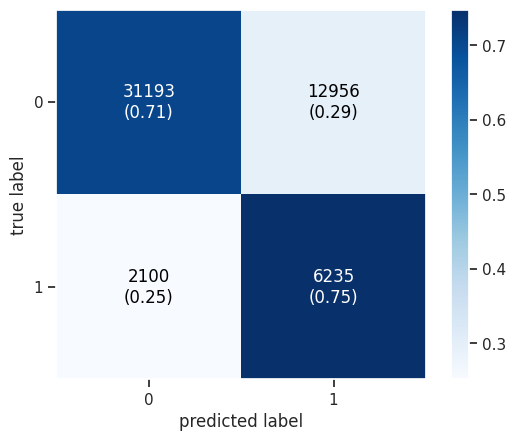

In [47]:
# 2015 Model
lg = LogisticRegression(max_iter = 1000)
lg.fit(X_train_2015_mini_LR , y_train_2015_mini_LR)

# make predictions on train set
y_pred_2015 = lg.predict(X_train_2015_mini_LR)
print("Train Data Accuracy:", accuracy_score(y_train_2015_mini, y_pred_2015))

# make predictions on validation set
y_pred_2015 = lg.predict(X_val_2015_LR)
print("Validation Data Accuracy:", accuracy_score(y_val_2015, y_pred_2015))

# make predictions on test set
y_pred_2015 = lg.predict(X_test_2015_LR)

# Evaluate the model
print("Test Data Accuracy:", accuracy_score(y_test_2015, y_pred_2015))
print("Test AUC Score:", roc_auc_score(y_test_2015, y_pred_2015))
print("Confusion Matrix:\n", confusion_matrix(y_test_2015, y_pred_2015))
print("Classification Report:\n", classification_report(y_test_2015, y_pred_2015, digits=4))

# calculating and plotting the confusion matrix
cm1 = confusion_matrix(y_test_2015, y_pred_2015)
plot_confusion_matrix(conf_mat = cm1,
                      show_absolute = True,
                      show_normed = True,
                      colorbar = True)
plt.show()

Test Data Accuracy: 0.7217687204878701
Test AUC Score: 0.7162885593491375
Confusion Matrix:
 [[31461 11958]
 [ 2596  6294]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9238    0.7246    0.8121     43419
           1     0.3448    0.7080    0.4638      8890

    accuracy                         0.7218     52309
   macro avg     0.6343    0.7163    0.6380     52309
weighted avg     0.8254    0.7218    0.7529     52309



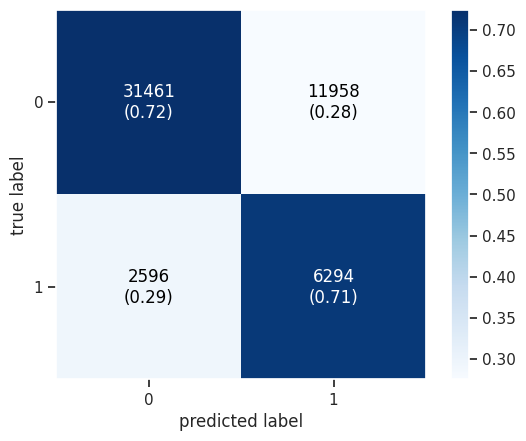

In [48]:
## Test 2015 Model with 2023 Data

# make predictions on test set
y_pred_2023 = lg.predict(X_test_2023_LR)

# Evaluate the model
print("Test Data Accuracy:", accuracy_score(y_test_2023, y_pred_2023))
print("Test AUC Score:", roc_auc_score(y_test_2023, y_pred_2023))
print("Confusion Matrix:\n", confusion_matrix(y_test_2023, y_pred_2023))
print("Classification Report:\n", classification_report(y_test_2023, y_pred_2023, digits=4))

# calculating and plotting the confusion matrix
cm1 = confusion_matrix(y_test_2023, y_pred_2023)
plot_confusion_matrix(conf_mat = cm1,
                      show_absolute = True,
                      show_normed = True,
                      colorbar = True)
plt.show()

Train Data Accuracy: 0.7193531740530216
Validation Data Accuracy: 0.7132615802252003
Test Data Accuracy: 0.7085969482694455
Test AUC Score: 0.7225740039438893
Confusion Matrix:
 [[61451 26117]
 [ 4420 12805]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9329    0.7018    0.8010     87568
           1     0.3290    0.7434    0.4561     17225

    accuracy                         0.7086    104793
   macro avg     0.6309    0.7226    0.6286    104793
weighted avg     0.8336    0.7086    0.7443    104793

              precision    recall  f1-score   support

           0       0.93      0.70      0.80     87568
           1       0.33      0.74      0.46     17225

    accuracy                           0.71    104793
   macro avg       0.63      0.72      0.63    104793
weighted avg       0.83      0.71      0.74    104793



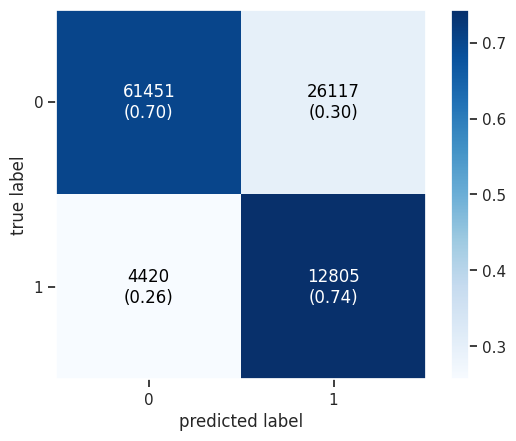

In [49]:
# Combined Model
lg.fit(X_combined_train_LR, y_combined_train_LR)


# make predictions on train set
y_combined_pred = lg.predict(X_train_2023_mini_LR)
print("Train Data Accuracy:", accuracy_score(y_train_2023_mini, y_combined_pred))

# make predictions on validation set
y_combined_pred = lg.predict(X_val_2023_LR)
print("Validation Data Accuracy:", accuracy_score(y_val_2023, y_combined_pred))

# make predictions on test set
y_combined_pred = lg.predict(X_combined_test_LR)

# Evaluate the model
print("Test Data Accuracy:", accuracy_score(y_combined_test, y_combined_pred))
print("Test AUC Score:", roc_auc_score(y_combined_test, y_combined_pred))
print("Confusion Matrix:\n", confusion_matrix(y_combined_test, y_combined_pred))
print("Classification Report:\n", classification_report(y_combined_test, y_combined_pred, digits=4))

matrix = classification_report(y_combined_test, y_combined_pred)
print(matrix)

# calculating and plotting the confusion matrix
cm1 = confusion_matrix(y_combined_test, y_combined_pred)
plot_confusion_matrix(conf_mat = cm1,
                      show_absolute = True,
                      show_normed=True,
                      colorbar=True)
plt.show()

Test Data Accuracy: 0.712898354011738
Test AUC Score: 0.718056912978464
Confusion Matrix:
 [[30838 12581]
 [ 2437  6453]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9268    0.7102    0.8042     43419
           1     0.3390    0.7259    0.4622      8890

    accuracy                         0.7129     52309
   macro avg     0.6329    0.7181    0.6332     52309
weighted avg     0.8269    0.7129    0.7461     52309



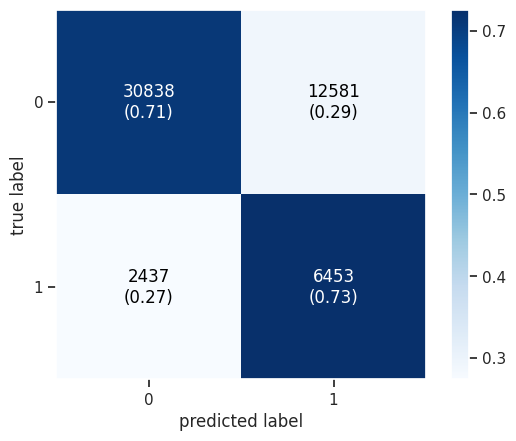

In [50]:
## Test Combined Model with 2023 Data

# make predictions on test set
y_pred_2023 = lg.predict(X_test_2023_LR)

# Evaluate the model
print("Test Data Accuracy:", accuracy_score(y_test_2023, y_pred_2023))
print("Test AUC Score:", roc_auc_score(y_test_2023, y_pred_2023))
print("Confusion Matrix:\n", confusion_matrix(y_test_2023, y_pred_2023))
print("Classification Report:\n", classification_report(y_test_2023, y_pred_2023, digits=4))

# calculating and plotting the confusion matrix
cm1 = confusion_matrix(y_test_2023, y_pred_2023)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

## 3. Logistic Regression in TensorFlow
- define function show_history to plot loss at each epoch and show final numbers
- build tensorflow model function
- train 2014 model
- apply 2014 model on 2023 data for prediction and accuracy
- train combined model

In [40]:
# Plot the loss at each epoch and show final numbers.
def show_history(history):
  plt.plot(history.history['loss'], color='black', label='train')
  plt.plot(history.history['val_loss'], color='red', label='val')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()
  print('final train acc: %.4f' %history.history['accuracy'][-1])
  print('final val acc:   %.4f' %history.history['val_accuracy'][-1])

In [41]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # binary logistic regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,        # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      activation='sigmoid',
      kernel_initializer=tf.ones_initializer(),  # initialize params to 1
      bias_initializer=tf.ones_initializer(),    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │              20 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20 (80.00 B)

 Trainable params: 20 (80.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
8279/8279 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.6000 - loss: 2.2886 - val_accuracy: 0.6575 - val_loss: 0.7358
Epoch 2/5
8279/8279 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.6557 - loss: 0.6822 - val_accuracy: 0.6749 - val_loss: 0.6586
Epoch 3/5
8279/8279 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.6713 - loss: 0.6347 - val_accuracy: 0.6886 - val_loss: 0.6234
Epoch 4/5
8279/8279 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6838 - loss: 0.6080 - val_accuracy: 0.6967 - val_loss: 0.6032
Epoch 5/5
8279/8279 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.6927 - loss: 0.5922 - val_accuracy: 0.7023 - val_loss: 0.5907


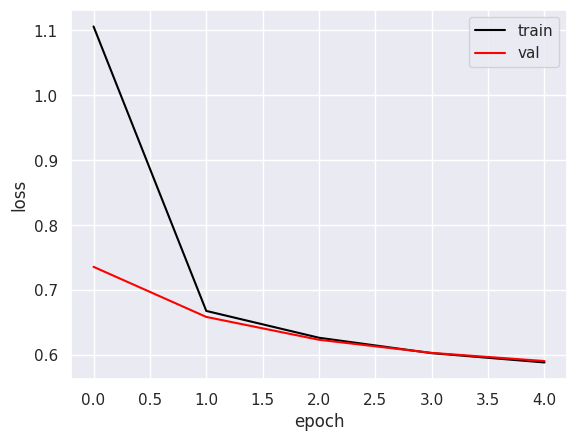

final train acc: 0.6957
final val acc:   0.7023
Aggregate accuracy on test dataset: 0.7063
Aggregate accuracy on 2023 dataset: 0.7248


In [42]:
## Train 2015 Model

model_2015_tf=build_model(num_features=X_train_2015_mini_LR.shape[1],learning_rate=0.001)
model_2015_tf.summary()

# Fit the model
model_2015_fit=model_2015_tf.fit(x=X_train_2015_mini_LR, y=y_train_2015_mini_LR, validation_data=[X_val_2015_LR, y_val_2015], epochs=5, batch_size=32)

show_history(model_2015_fit)

# Calculate aggregate accuracy on test datasets
loss_test,accuracy_test=model_2015_tf.evaluate(X_test_2015_LR, y_test_2015,verbose=0)
print(f"Aggregate accuracy on test dataset: {accuracy_test :.4f}")

## Apply 2015 model on 2023 test Data
loss_test, accuracy_test = model_2015_tf.evaluate(X_test_2023_LR, y_test_2023, verbose=0)
print(f"Aggregate accuracy on 2023 dataset: {accuracy_test :.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │              20 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20 (80.00 B)

 Trainable params: 20 (80.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
16393/16393 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.6127 - loss: 1.6531 - val_accuracy: 0.6671 - val_loss: 0.6658
Epoch 2/5
16393/16393 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.6697 - loss: 0.6335 - val_accuracy: 0.6899 - val_loss: 0.6102
Epoch 3/5
16393/16393 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.6910 - loss: 0.5945 - val_accuracy: 0.6996 - val_loss: 0.5898
Epoch 4/5
16393/16393 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - accuracy: 0.7010 - loss: 0.5788 - val_accuracy: 0.7045 - val_loss: 0.5797
Epoch 5/5
16393/16393 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step - accuracy: 0.7064 - loss: 0.5705 - val_accuracy: 0.7069 - val_loss: 0.5734


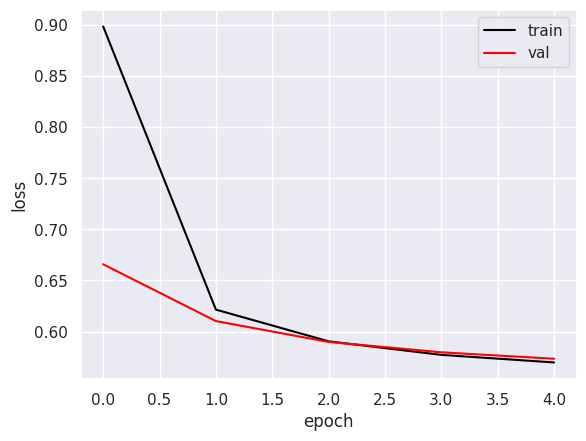

final train acc: 0.7075
final val acc:   0.7069
Aggregate accuracy on combined test dataset: 0.7079
Aggregate accuracy on 2023 test dataset: 0.7155


In [43]:
## Train Combined Model
model_combined_tf = build_model(num_features = X_combined_train_LR.shape[1], learning_rate=0.001)
model_combined_tf.summary()

# 3. Fit the model
model_combined_fit = model_combined_tf.fit(x = X_combined_train_LR, y = y_combined_train_LR, validation_data = [X_combined_val_LR, y_combined_val], epochs = 5, batch_size = 32)

show_history(model_combined_fit)

# Calculate aggregate accuracy on combined test data
loss_test,accuracy_test = model_combined_tf.evaluate(X_combined_test_LR, y_combined_test, verbose=0)
print(f"Aggregate accuracy on combined test dataset: {accuracy_test :.4f}")

# Calculate aggregate accuracy on 2023 test data
loss_test, accuracy_test = model_combined_tf.evaluate(X_test_2023_LR, y_test_2023, verbose=0)
print(f"Aggregate accuracy on 2023 test dataset: {accuracy_test :.4f}")

### 3a) Logistic Regression with TensorFlow: Hyperparameter Tuning - using keras tuner
- 2015 data
- Learning Rate Grid Search over [.0001, .0005, .001, .005, .01, .05, .1]

In [ ]:
import keras_tuner as kt

In [ ]:
def build_model_tuner(hp):
  """Build a TF linear regression model using Keras.

  Args:
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """

  num_features = X_train_2015_mini_LR.shape[1]

  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units = 1,
      input_shape = (num_features,),
      use_bias = True,
      activation = 'sigmoid',
      kernel_initializer = tf.keras.initializers.Constant(1),
      bias_initializer = tf.keras.initializers.Constant(1)
  ))

  # learning_rates are sampled from 0.0001 to .1 in a linear fashion
  learning_rate = hp.Choice('learning_rate', values=[1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1])
  optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)

  model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=["accuracy"])

  return model

# keras tuning set up
tuner = kt.RandomSearch(
    build_model_tuner,
    objective = 'val_accuracy',  # metric to minimize
    max_trials = 10,                       # number of hyperparameter sets to try
    executions_per_trial = 1,               # number of model evaluations per trial
    directory='logistic_model_tuning_2015'
)

/home/hyungjin_kim/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Perform Hyperparameter Search
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]

tuner.search(X_train_2015_mini_LR, y_train_2015_mini_LR, epochs = 50, validation_data = (X_val_2015_LR, y_val_2015), callbacks=callbacks,
             batch_size=kt.HyperParameters().Choice('batch_size', values=[32, 64, 128]))


Trial 7 Complete [00h 08m 01s]
val_accuracy: 0.7318039536476135

Best val_accuracy So Far: 0.8394749164581299
Total elapsed time: 00h 53m 03s


In [ ]:
# Get the Best Model and Hyperparameters
best_model_2015 = tuner.get_best_models(num_models = 1)[0]
best_lr_2015 = tuner.get_best_hyperparameters(1)[0].values['learning_rate']

print("Best Learning Rate: ", best_lr_2015)

# evaluate the best model
train_loss, train_accuracy = best_model_2015.evaluate(X_train_2015_mini_LR, y_train_2015_mini_LR)
print(f"Train Accuracy of the best logistic regression model: {train_accuracy * 100:.2f}%")

val_loss, val_accuracy = best_model_2015.evaluate(X_val_2015_LR, y_val_2015)
print(f"Validation Accuracy of the best logistic regression model: {val_accuracy * 100:.2f}%")

test_loss, test_accuracy = best_model_2015.evaluate(X_test_2015_LR, y_test_2015)
print(f"Test Accuracy of the best logistic regression model: {test_accuracy * 100:.2f}%")

# Display the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", best_hyperparameters.values)

/home/hyungjin_kim/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Learning Rate:  0.1
8287/8287 ━━━━━━━━━━━━━━━━━━━━ 5s 584us/step - accuracy: 0.7680 - loss: 0.6646
Train Accuracy of the best logistic regression model: 52.74%
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step - accuracy: 0.8373 - loss: 0.4820
Validation Accuracy of the best logistic regression model: 83.95%
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step - accuracy: 0.8415 - loss: 0.4723
Test Accuracy of the best logistic regression model: 84.37%
Best hyperparameters: {'learning_rate': 0.1}


In [ ]:
# weights for the trained model based on 2014 data
model_2015_wts = best_model_2015.get_weights()
print(model_2015_wts)

[array([[ 1.184212  ],
       [ 0.717592  ],
       [ 1.6553456 ],
       [-0.33353123],
       [-0.87891567],
       [-0.02755821],
       [-0.50599486],
       [-2.8658898 ],
       [-0.29155234],
       [-0.940878  ],
       [ 0.84182745],
       [-0.13828418],
       [ 0.12671658],
       [-0.03962223],
       [-0.29383463],
       [-0.22161084],
       [ 1.2100791 ],
       [-0.2041496 ],
       [-0.09845581]], dtype=float32), array([-5.2209506], dtype=float32)]


1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step
Confusion Matrix:
 [[43787   404]
 [ 7799   494]]


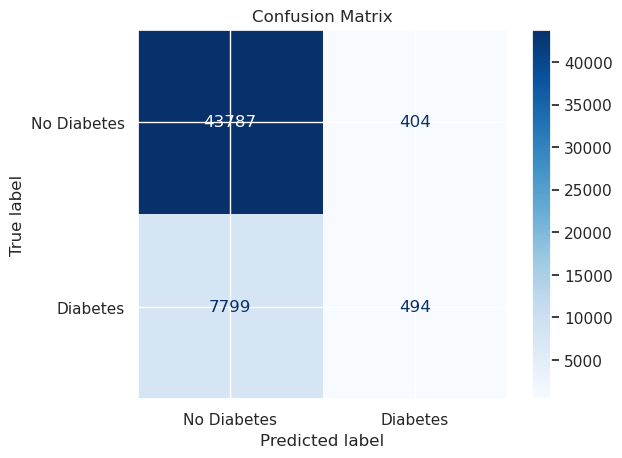

In [ ]:
# confusion matrix on 2015 test data
test_preds = best_model_2015.predict(X_test_2015_LR)
test_preds_lab = np.round(test_preds)

cm = confusion_matrix(y_test_2015, test_preds_lab)

print(f'Confusion Matrix:\n {cm}')

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No Diabetes', 'Diabetes'])
disp.plot(cmap='Blues', values_format = 'd')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
train_preds = best_model_2015.predict(X_train_2015_mini_LR)
train_preds_lab = np.round(train_preds)

val_preds = best_model_2015.predict(X_val_2015_LR)
val_preds_lab = np.round(val_preds)

from sklearn.metrics import accuracy_score, classification_report

print(f"Train Classification Report:\n{classification_report(y_train_2015_mini_LR, train_preds_lab)}\n")
print(f"Validation Classification Report:\n{classification_report(y_val_2015, val_preds_lab)}\n")
print(f"Test Classification Report:\n{classification_report(y_test_2015, test_preds_lab)}\n")


8287/8287 ━━━━━━━━━━━━━━━━━━━━ 4s 486us/step
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1s 450us/step
Train Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.99      0.68    132590
           1       0.88      0.06      0.12    132590

    accuracy                           0.53    265180
   macro avg       0.70      0.53      0.40    265180
weighted avg       0.70      0.53      0.40    265180


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     43975
           1       0.55      0.06      0.10      8509

    accuracy                           0.84     52484
   macro avg       0.70      0.52      0.51     52484
weighted avg       0.80      0.84      0.78     52484


Test Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     44191
           1       0.55      0.06      0.11      8293


In [ ]:
## Apply 2015 model on 2023 Data
loss_test, accuracy_test = best_model_2015.evaluate(X_test_2023_LR, y_test_2023,verbose=0)
print(f"Aggregate accuracy on 2023 test dataset (hyperparameter tuned model): {accuracy_test :.4f}")

Aggregate accuracy on 2023 test dataset (hyperparameter tuned model): 0.8301


1635/1635 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step
Confusion Matrix:
 [[43146   196]
 [ 8693   274]]


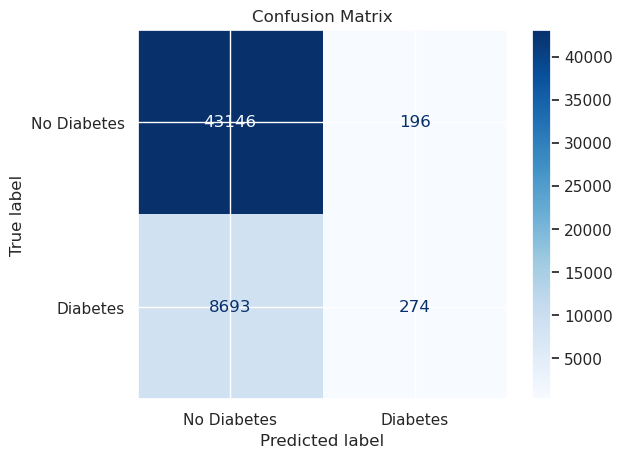

In [ ]:
# confusion matrix on 2023 test data
test_preds = best_model_2015.predict(X_test_2023_LR)
test_preds_lab = np.round(test_preds)

cm = confusion_matrix(y_test_2023, test_preds_lab)

print(f'Confusion Matrix:\n {cm}')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

### 3b) Logistic Regression with TensorFlow: Hyperparameter Tuning - using keras tuner
- 2023 data
- Learning Rate Grid Search over [.0001, .0005, .001, .005, .01, .05, .1]

In [ ]:
def build_model_tuner2023(hp):
  """Build a TF linear regression model using Keras.

  Args:
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """

  num_features = X_combined_train_LR.shape[1]

  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units = 1,
      input_shape = (num_features,),
      use_bias = True,
      activation= 'sigmoid',
      kernel_initializer = tf.keras.initializers.Constant(1),
      bias_initializer = tf.keras.initializers.Constant(1)
  ))

  # learning_rates are sampled from 0.0001 to .1 in a linear fashion
  learning_rate = hp.Choice('learning_rate', values=[1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1])
  optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)

  model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=["accuracy"])

  return model

# keras tuning set up
tuner = kt.RandomSearch(
    build_model_tuner2023,
    objective = 'val_accuracy',  # metric to minimize
    max_trials = 10,                       # number of hyperparameter sets to try
    executions_per_trial = 1,               # number of model evaluations per trial
    directory='logistic_model_tuning_2023'
)

/home/hyungjin_kim/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Perform Hyperparameter Search for combined data
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]

tuner.search(X_combined_train_LR, y_combined_train_LR, epochs = 50, validation_data = (X_combined_val_LR, y_combined_val), callbacks=callbacks,
             batch_size=kt.HyperParameters().Choice('batch_size', values=[32, 64, 128]))

# Get the Best Model and Hyperparameters
best_model_combined = tuner.get_best_models(num_models = 1)[0]
best_lr_combined = tuner.get_best_hyperparameters(1)[0].values['learning_rate']

print("Best Learning Rate: ", best_lr_combined)

# evaluate the best model
train_loss, train_accuracy = best_model_combined.evaluate(X_combined_train_LR, y_combined_train_LR)
print(f"Train Accuracy of the best logistic regression model: {train_accuracy * 100:.2f}%")

val_loss, val_accuracy = best_model_combined.evaluate(X_combined_val_LR, y_combined_val)
print(f"Validation Accuracy of the best logistic regression model: {val_accuracy * 100:.2f}%")

test_loss, test_accuracy = best_model_combined.evaluate(X_combined_test_LR, y_combined_test)
print(f"Test Accuracy of the best logistic regression model: {test_accuracy * 100:.2f}%")

# Display the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", best_hyperparameters.values)

Trial 7 Complete [00h 16m 23s]
val_accuracy: 0.7084347009658813

Best val_accuracy So Far: 0.8053877353668213
Total elapsed time: 01h 24m 23s


/home/hyungjin_kim/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Learning Rate:  0.05
16414/16414 ━━━━━━━━━━━━━━━━━━━━ 13s 773us/step - accuracy: 0.7381 - loss: 0.5092
Train Accuracy of the best logistic regression model: 66.54%
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 2s 735us/step - accuracy: 0.8022 - loss: 0.4218
Validation Accuracy of the best logistic regression model: 80.54%
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 3s 767us/step - accuracy: 0.8028 - loss: 0.4189
Test Accuracy of the best logistic regression model: 80.67%
Best hyperparameters: {'learning_rate': 0.05}


In [ ]:
# weights for the trained model based on combined data
model_combined_wts = best_model_combined.get_weights()
print(model_combined_wts)

[array([[ 0.733175  ],
       [ 0.61217314],
       [ 0.8938859 ],
       [-0.1613147 ],
       [-0.61244434],
       [-0.0100742 ],
       [-0.43459153],
       [-1.7870195 ],
       [-0.22657529],
       [-0.71863204],
       [ 0.5715205 ],
       [-0.0783824 ],
       [ 0.0334386 ],
       [ 0.07292909],
       [-0.13325414],
       [-0.16604055],
       [ 0.7551614 ],
       [-0.12847053],
       [-0.08869247]], dtype=float32), array([-2.8229203], dtype=float32)]


3275/3275 ━━━━━━━━━━━━━━━━━━━━ 2s 486us/step
Confusion Matrix:
 [[76970 10563]
 [ 9691  7569]]


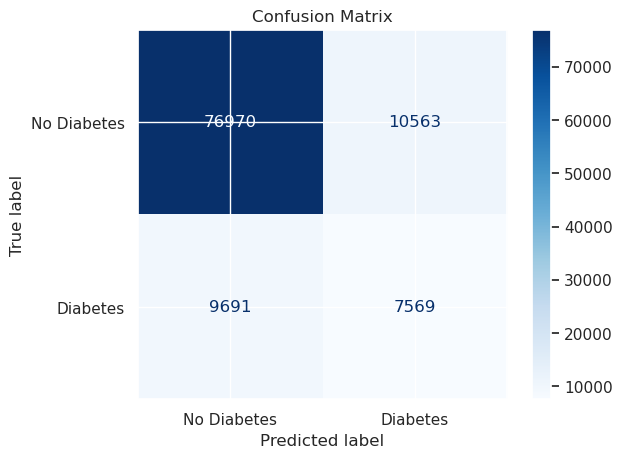

In [ ]:
# confusion matrix on combined test data
test_preds = best_model_combined.predict(X_combined_test_LR)
test_preds_lab = np.round(test_preds)

cm = confusion_matrix(y_combined_test, test_preds_lab)

print(f'Confusion Matrix:\n {cm}')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
train_preds = best_model_combined.predict(X_combined_train_LR)
train_preds_lab = np.round(train_preds)

val_preds = best_model_combined.predict(X_combined_val_LR)
val_preds_lab = np.round(val_preds)


print(f"Train Classification Report:\n{classification_report(y_combined_train_LR, train_preds_lab)}\n")
print(f"Validation Classification Report:\n{classification_report(y_combined_val, val_preds_lab)}\n")
print(f"Test Classification Report:\n{classification_report(y_combined_test, test_preds_lab)}\n")

16414/16414 ━━━━━━━━━━━━━━━━━━━━ 8s 471us/step
3275/3275 ━━━━━━━━━━━━━━━━━━━━ 2s 469us/step
Train Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.88      0.72    262620
           1       0.79      0.45      0.57    262620

    accuracy                           0.67    525240
   macro avg       0.70      0.67      0.65    525240
weighted avg       0.70      0.67      0.65    525240


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     87327
           1       0.42      0.44      0.43     17466

    accuracy                           0.81    104793
   macro avg       0.65      0.66      0.66    104793
weighted avg       0.81      0.81      0.81    104793


Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     87533
           1       0.42      0.44      0.43     1726

In [ ]:
## Apply combined-data model on 2023 Data
loss_test, accuracy_test = best_model_combined.evaluate(X_test_2023_LR, y_test_2023,verbose=0)
print(f"Aggregate accuracy on 2023 test data (hyperparameter tuned model): {accuracy_test :.4f}")

Aggregate accuracy on 2023 test data (hyperparameter tuned model): 0.8101


3275/3275 ━━━━━━━━━━━━━━━━━━━━ 2s 649us/step
Confusion Matrix:
 [[76970 10563]
 [ 9691  7569]]


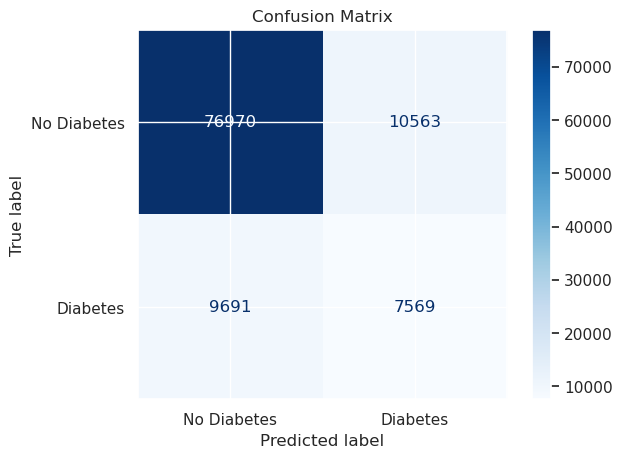

In [ ]:
# confusion matrix on combined test data
test_preds = best_model_combined.predict(X_combined_test_LR)
test_preds_lab = np.round(test_preds)

cm = confusion_matrix(y_combined_test, test_preds_lab)

print(f'Confusion Matrix:\n {cm}')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

1635/1635 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step
Confusion Matrix:
 [[38767  4575]
 [ 5357  3610]]


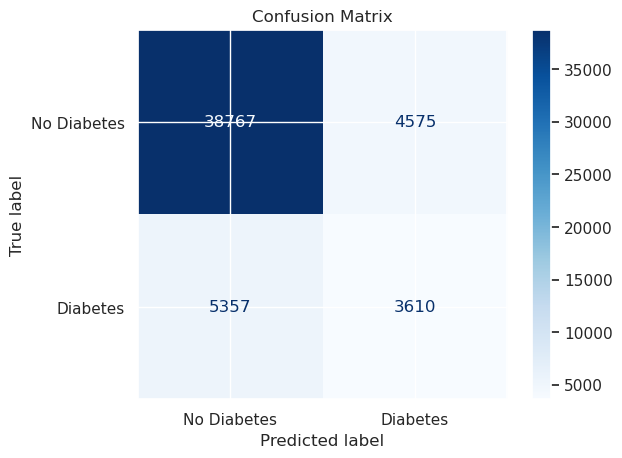

In [ ]:
# confusion matrix on 2023 test data
test_preds = best_model_combined.predict(X_test_2023_LR)
test_preds_lab = np.round(test_preds)

cm = confusion_matrix(y_test_2023, test_preds_lab)

print(f'Confusion Matrix:\n {cm}')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

## 4. Decision Tree

In [33]:
# 2015 data

# Dictionary to store models and their performance
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Function to train, evaluate and display results for each model
def train_and_evaluate(models, X_train, y_train, X_val, y_val):
    np.random.seed(1234)

    for model_name, model in models.items():
        print(f"Training {model_name}...")
        model.fit(X_train, y_train)

        # Make predictions on train set
        y_train_pred = model.predict(X_train)

        # Calculate accuracy and other metrics
        accuracy = accuracy_score(y_train, y_train_pred)
        auc_score = roc_auc_score(y_train, y_train_pred)
        print(f"\n{model_name} Accuracy on Train Set: {accuracy:.4f}")
        print(f"{model_name} AUC Score on Train Set: {auc_score:.4f}")
        print(f"{model_name} Classification Report:\n{classification_report(y_train, y_train_pred, digits =4)}\n")

        # Make predictions on validation set
        y_val_pred = model.predict(X_val)

        # Calculate accuracy and other metrics
        accuracy = accuracy_score(y_val, y_val_pred)
        auc_score = roc_auc_score(y_val, y_val_pred)
        print(f"\n{model_name} Accuracy on Validation Set: {accuracy:.4f}")
        print(f"{model_name} AUC Score on Validation Set: {auc_score:.4f}")
        print(f"{model_name} Classification Report:\n{classification_report(y_val, y_val_pred, digits=4)}\n")

    return models

# Train and evaluate models
trained_models = train_and_evaluate(models, X_train_2015_mini, y_train_2015_mini, X_val_2015, y_val_2015)

# Test set evaluation for final model accuracy
print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_test_pred = model.predict(X_test_2015)
    test_accuracy = accuracy_score(y_test_2015, y_test_pred)
    auc_score = roc_auc_score(y_test_2015, y_test_pred)
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} Test AUC Score: {auc_score:.4f}")
    print(f"{model_name} Test Classification Report:\n{classification_report(y_test_2015, y_test_pred, digits=4)}\n")

Training Decision Tree...

Decision Tree Accuracy on Train Set: 0.9211
Decision Tree AUC Score on Train Set: 0.9211
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0     0.9247    0.9168    0.9207    132453
           1     0.9175    0.9253    0.9214    132453

    accuracy                         0.9211    264906
   macro avg     0.9211    0.9211    0.9211    264906
weighted avg     0.9211    0.9211    0.9211    264906



Decision Tree Accuracy on Validation Set: 0.7425
Decision Tree AUC Score on Validation Set: 0.6183
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0     0.8827    0.8003    0.8395     44154
           1     0.2918    0.4363    0.3497      8330

    accuracy                         0.7425     52484
   macro avg     0.5873    0.6183    0.5946     52484
weighted avg     0.7889    0.7425    0.7617     52484


Testing on unseen data:
Decision Tree Test Accuracy: 0

In [34]:
# Apply 2015 model on 2023 test data

print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_pred = model.predict(X_test_2023)
    test_accuracy = accuracy_score(y_test_2023, y_pred)
    auc_score = roc_auc_score(y_test_2023, y_pred)
    print(f"{model_name} 2023 Data Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} 2023 Data Test AUC Score: {auc_score:.4f}")
    print(f"{model_name} 2023 Data Test Classification Report:\n{classification_report(y_test_2023, y_pred, digits= 4)}\n")

Testing on unseen data:
Decision Tree 2023 Data Test Accuracy: 0.7360
Decision Tree 2023 Data Test AUC Score: 0.6067
Decision Tree 2023 Data Test Classification Report:
              precision    recall  f1-score   support

           0     0.8693    0.8026    0.8346     43419
           1     0.2988    0.4108    0.3459      8890

    accuracy                         0.7360     52309
   macro avg     0.5841    0.6067    0.5903     52309
weighted avg     0.7724    0.7360    0.7516     52309




In [35]:
## Combined model
# Function to train, evaluate and display results for each model
def train_and_evaluate(models, X_combined_train, y_combined_train, X_combined_val, y_combined_val):
    np.random.seed(1234)

    for model_name, model in models.items():
        print(f"Training {model_name}...")
        model.fit(X_combined_train, y_combined_train)

        # Make predictions on training set
        y_combined_train_pred = model.predict(X_combined_train)

        # Calculate accuracy and other metrics
        accuracy = accuracy_score(y_combined_train, y_combined_train_pred)
        auc_score = roc_auc_score(y_combined_train, y_combined_train_pred)
        print(f"\n{model_name} Accuracy on combined data Training Set: {accuracy:.4f}")
        print(f"{model_name} AUC Score on combined data Training Set: {auc_score:.4f}")
        print(f"{model_name} Combined data Classification Report:\n{classification_report(y_combined_train, y_combined_train_pred, digits=4)}\n")

        # Make predictions on validation set
        y_combined_val_pred = model.predict(X_combined_val)

        # Calculate accuracy and other metrics
        accuracy = accuracy_score(y_combined_val, y_combined_val_pred)
        auc_score = roc_auc_score(y_combined_val, y_combined_val_pred)
        print(f"\n{model_name} Accuracy on combined data Validation Set: {accuracy:.4f}")
        print(f"{model_name} AUC Score on combined data Validation Set: {auc_score:.4f}")
        print(f"{model_name} Combined data Classification Report:\n{classification_report(y_combined_val, y_combined_val_pred, digits=4)}\n")

    return models

# Train and evaluate models
trained_models = train_and_evaluate(models, X_combined_train, y_combined_train, X_combined_val, y_combined_val)

# Test set evaluation for final model accuracy
print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_combined_test_pred = model.predict(X_combined_test)
    test_accuracy = accuracy_score(y_combined_test, y_combined_test_pred)
    auc_score = roc_auc_score(y_combined_test, y_combined_test_pred)
    print(f"{model_name} Combined data Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} Combined data Test AUC Score: {auc_score:.4f}")
    print(f"{model_name} Combined data Test Classification Report:\n{classification_report(y_combined_test, y_combined_test_pred, digits=4)}\n")

Training Decision Tree...

Decision Tree Accuracy on combined data Training Set: 0.8923
Decision Tree AUC Score on combined data Training Set: 0.8923
Decision Tree Combined data Classification Report:
              precision    recall  f1-score   support

           0     0.8953    0.8886    0.8919    262287
           1     0.8894    0.8960    0.8927    262287

    accuracy                         0.8923    524574
   macro avg     0.8923    0.8923    0.8923    524574
weighted avg     0.8923    0.8923    0.8923    524574



Decision Tree Accuracy on combined data Validation Set: 0.7301
Decision Tree AUC Score on combined data Validation Set: 0.6228
Decision Tree Combined data Classification Report:
              precision    recall  f1-score   support

           0     0.8815    0.7824    0.8290     87625
           1     0.2943    0.4632    0.3599     17168

    accuracy                         0.7301    104793
   macro avg     0.5879    0.6228    0.5944    104793
weighted avg     0.7

In [36]:
# Apply combined model on 2023 test data

print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_pred = model.predict(X_test_2023)
    test_accuracy = accuracy_score(y_test_2023, y_pred)
    auc_score = roc_auc_score(y_test_2023, y_pred)
    print(f"{model_name} 2023 Data Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} 2023 Data Test AUC Score: {auc_score:.4f}")
    print(f"{model_name} 2023 Data Test Classification Report:\n{classification_report(y_test_2023, y_pred, digits=4)}\n")

Testing on unseen data:
Decision Tree 2023 Data Test Accuracy: 0.7283
Decision Tree 2023 Data Test AUC Score: 0.6195
Decision Tree 2023 Data Test Classification Report:
              precision    recall  f1-score   support

           0     0.8754    0.7843    0.8273     43419
           1     0.3015    0.4547    0.3626      8890

    accuracy                         0.7283     52309
   macro avg     0.5884    0.6195    0.5950     52309
weighted avg     0.7778    0.7283    0.7484     52309




### 4a. Decision Tree Hyperparameter Tuning
- 2015 data

In [23]:
# Define the hyperparameter grid - 17 min to run
param_grid = {
    'criterion': ['gini', 'entropy'],              # Splitting criteria
    'max_depth': [3, 5, 10, None],                 # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],               # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 5, 10],             # Minimum samples required at a leaf node
    'max_features': [None, 'sqrt', 'log2'],        # Number of features to consider for best split
}

# Initialize the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,               # 5-fold cross-validation
    verbose=1,          # Display progress
    n_jobs=-1           # Use all available CPU cores
)

# Perform hyperparameter tuning on the training data
grid_search.fit(X_train_2015_mini, y_train_2015_mini)

# Display the best parameters and their corresponding score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Accuracy: 0.8215
Validation Accuracy with Best Model: 0.7435
Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84     44154
           1       0.29      0.44      0.35      8330

    accuracy                           0.74     52484
   macro avg       0.59      0.62      0.60     52484
weighted avg       0.79      0.74      0.76     52484

Test Accuracy with Best Model: 0.7403
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84     44149
           1       0.29      0.44      0.35      8335

    accuracy                           0.74     52484
   macro avg       0.59      0.62      0.59     52484
weighted a

Validation Accuracy with Best Model: 0.7435
AUC Score with Best Model: 0.6196
Classification Report on Validation Set:
              precision    recall  f1-score   support

           0     0.8831    0.8012    0.8402     44154
           1     0.2936    0.4379    0.3515      8330

    accuracy                         0.7435     52484
   macro avg     0.5883    0.6196    0.5958     52484
weighted avg     0.7896    0.7435    0.7626     52484

Test Accuracy with Best Model: 0.7403
AUC Score with Best Model: 0.6169
Classification Report on Test Set:
              precision    recall  f1-score   support

           0     0.8823    0.7978    0.8379     44149
           1     0.2893    0.4361    0.3479      8335

    accuracy                         0.7403     52484
   macro avg     0.5858    0.6169    0.5929     52484
weighted avg     0.7881    0.7403    0.7601     52484



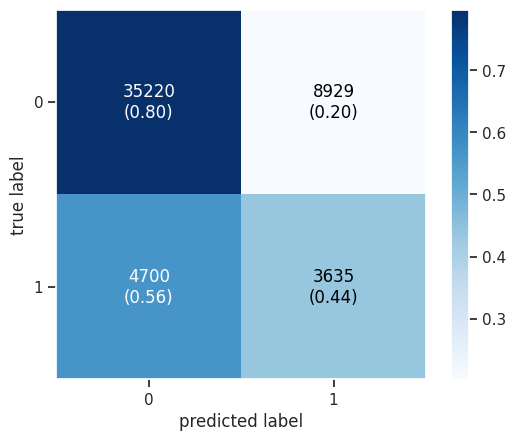

In [47]:
# 2015 val and test
# val set
y_val_pred = best_model.predict(X_val_2015)
val_accuracy = accuracy_score(y_val_2015, y_val_pred)
val_auc_score = roc_auc_score(y_val_2015, y_val_pred)
print(f"Validation Accuracy with Best Model: {val_accuracy:.4f}")
print(f"AUC Score with Best Model: {val_auc_score:.4f}")
print(f"Classification Report on Validation Set:\n{classification_report(y_val_2015, y_val_pred, digits = 4)}")

# Evaluate the best model on the test set
y_test_pred = best_model.predict(X_test_2015)
test_accuracy = accuracy_score(y_test_2015, y_test_pred)
test_auc_score = roc_auc_score(y_test_2015, y_test_pred)
print(f"Test Accuracy with Best Model: {test_accuracy:.4f}")
print(f"AUC Score with Best Model: {test_auc_score:.4f}")
print(f"Classification Report on Test Set:\n{classification_report(y_test_2015, y_test_pred, digits =4)}")

# Confusion matrix and plot on test set
cm1 = confusion_matrix(y_test_2015, y_test_pred)
plot_confusion_matrix(conf_mat=cm1, show_absolute=True, show_normed=True, colorbar=True)
plt.show()


Test Accuracy with Best Model: 0.7360
AUC Score with Best Model: 0.6088
Classification Report on Test Set:
              precision    recall  f1-score   support

           0     0.8702    0.8015    0.8345     43419
           1     0.3003    0.4160    0.3488      8890

    accuracy                         0.7360     52309
   macro avg     0.5852    0.6088    0.5916     52309
weighted avg     0.7733    0.7360    0.7519     52309



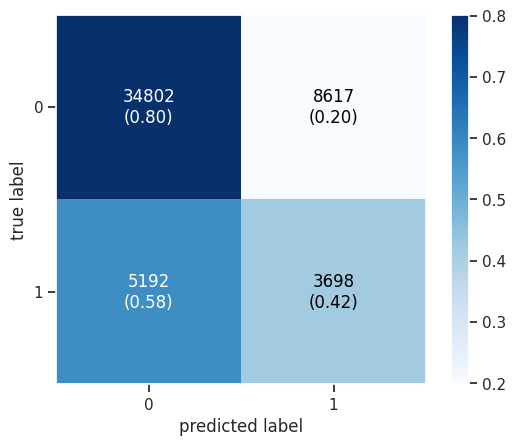

In [48]:
# Evaluate the best model on the test set 2023
y_test_pred = best_model.predict(X_test_2023)
test_accuracy = accuracy_score(y_test_2023, y_test_pred)
test_auc_score = roc_auc_score(y_test_2023, y_test_pred)
print(f"Test Accuracy with Best Model: {test_accuracy:.4f}")
print(f"AUC Score with Best Model: {test_auc_score:.4f}")
print(f"Classification Report on Test Set:\n{classification_report(y_test_2023, y_test_pred, digits =4)}")

# Confusion matrix and plot on test set
cm1 = confusion_matrix(y_test_2023, y_test_pred)
plot_confusion_matrix(conf_mat=cm1, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

### 4b. Decision Tree Hyperparameter Tuning
- Combined Data and 2023 data


Got same best parameters when running grid search on 2023 and combined data:

#### 2023 data grid search results
Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Best Cross-Validation Accuracy: 0.7999

Training Decision Tree (Best)...

Decision Tree (Best) Accuracy on Training Set: 0.9014

Decision Tree (Best) Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.89      0.90    130030
           1       0.90      0.91      0.90    130030

    accuracy                           0.90    260060



Decision Tree (Best) Accuracy on Validation Set: 0.7228

Decision Tree (Best) Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.78      0.82     43352
           1       0.30      0.45      0.36      8957

    accuracy                           0.72     52309



Testing on unseen data:

Decision Tree (Best) Test Accuracy: 0.7230

Decision Tree (Best) Test Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.78      0.82     43342
           1       0.30      0.46      0.36      8967

    accuracy                           0.72     52309


#### Combined Data Grid Search Results

Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Best Cross-Validation Accuracy: 0.7912

Training Decision Tree...

Decision Tree Accuracy on combined data Training Set: 0.8934

Decision Tree Combined data Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.89      0.89    262620
           1       0.89      0.90      0.89    262620

    accuracy                           0.89    525240



Decision Tree Accuracy on combined data Validation Set: 0.7273

Decision Tree Combined data Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.78      0.83     87327
           1       0.30      0.46      0.36     17466

    accuracy                           0.73    104793


Testing on unseen data:

Decision Tree Combined data Test Accuracy: 0.7294

Decision Tree Combined data Test Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.78      0.83     87533
           1       0.29      0.46      0.36     17260

    accuracy                           0.73    104793

In [ ]:
# grid search for 2023 data

# Define the hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],               # Splitting criteria
    'max_depth': [3, 5, 10, None],                  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],                # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 5, 10],              # Minimum samples required at a leaf node
    'max_features': [None, 'sqrt', 'log2'],         # Number of features to consider for the best split
}

# Initialize the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,               # 5-fold cross-validation
    verbose=1,          # Display progress
    n_jobs=-1           # Use all available CPU cores
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_2023_mini, y_train_2023_mini)

# Display the best parameters and their corresponding score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Use the best estimator from GridSearchCV
best_dt_model = grid_search.best_estimator_

# Dictionary to store models
models = {
    "Decision Tree (Best)": best_dt_model
}

# Function to train, evaluate, and display results for each model
def train_and_evaluate(models, X_train, y_train, X_val, y_val):
    np.random.seed(1234)

    for model_name, model in models.items():
        print(f"Training {model_name}...")
        model.fit(X_train, y_train)

        # Make predictions on training set
        y_train_pred = model.predict(X_train)

        # Calculate accuracy and other metrics
        accuracy = accuracy_score(y_train, y_train_pred)
        print(f"\n{model_name} Accuracy on Training Set: {accuracy:.4f}")
        print(f"{model_name} Classification Report:\n{classification_report(y_train, y_train_pred)}\n")

        # Make predictions on validation set
        y_val_pred = model.predict(X_val)

        # Calculate accuracy and other metrics
        accuracy = accuracy_score(y_val, y_val_pred)
        print(f"\n{model_name} Accuracy on Validation Set: {accuracy:.4f}")
        print(f"{model_name} Classification Report:\n{classification_report(y_val, y_val_pred)}\n")

    return models

# Train and evaluate models
trained_models = train_and_evaluate(models, X_train_2023_mini, y_train_2023_mini, X_val_2023, y_val_2023)

# Test set evaluation for final model accuracy
print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_test_pred = model.predict(X_test_2023)
    test_accuracy = accuracy_score(y_test_2023, y_test_pred)
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} Test Classification Report:\n{classification_report(y_test_2023, y_test_pred)}\n")


In [ ]:
# grid search for combined data

# Define the hyperparameter grid for the Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy'],               # Splitting criteria
    'max_depth': [3, 5, 10, None],                  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],                # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 5, 10],              # Minimum samples required at a leaf node
    'max_features': [None, 'sqrt', 'log2'],         # Number of features to consider for best split
}

# Initialize the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,               # 5-fold cross-validation
    verbose=1,          # Display progress
    n_jobs=-1           # Use all available CPU cores
)

# Fit GridSearchCV on the combined training data
grid_search.fit(X_combined_train, y_combined_train)

# Display the best parameters and their corresponding score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Use the best estimator from GridSearchCV
best_dt_model = grid_search.best_estimator_

# Function to train, evaluate, and display results for models
def train_and_evaluate(models, X_combined_train, y_combined_train, X_combined_val, y_combined_val):
    np.random.seed(1234)

    for model_name, model in models.items():
        print(f"Training {model_name}...")
        model.fit(X_combined_train, y_combined_train)

        # Make predictions on training set
        y_combined_train_pred = model.predict(X_combined_train)

        # Calculate accuracy and other metrics
        train_accuracy = accuracy_score(y_combined_train, y_combined_train_pred)
        print(f"\n{model_name} Accuracy on combined data Training Set: {train_accuracy:.4f}")
        print(f"{model_name} Combined data Classification Report:\n{classification_report(y_combined_train, y_combined_train_pred)}\n")

        # Make predictions on validation set
        y_combined_val_pred = model.predict(X_combined_val)

        # Calculate accuracy and other metrics
        val_accuracy = accuracy_score(y_combined_val, y_combined_val_pred)
        print(f"\n{model_name} Accuracy on combined data Validation Set: {val_accuracy:.4f}")
        print(f"{model_name} Combined data Classification Report:\n{classification_report(y_combined_val, y_combined_val_pred)}\n")

    return models

# Define models dictionary with the best Decision Tree model
models = {
    'Decision Tree': best_dt_model
}

# Train and evaluate models on combined training and validation sets
trained_models = train_and_evaluate(models, X_combined_train, y_combined_train, X_combined_val, y_combined_val)

# Test set evaluation for final model accuracy
print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_combined_test_pred = model.predict(X_combined_test)
    test_accuracy = accuracy_score(y_combined_test, y_combined_test_pred)
    print(f"{model_name} Combined data Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} Combined data Test Classification Report:\n{classification_report(y_combined_test, y_combined_test_pred)}\n")


In [59]:
# manual tuning for combined model to show results:

# use features from grid search: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
# iteration 2: 2 min samples leaf
 #'min_samples_split': [2, 5, 10],     # Minimum samples to split an internal node
  # 'min_samples_leaf': [1, 2, 5, 10],

# 2015 data

# Dictionary to store models and their performance
models = {
    "Decision Tree": DecisionTreeClassifier(
        random_state=42,
        criterion='entropy',
        max_depth=None,
        max_features=None,
        min_samples_leaf=1,
        min_samples_split=2,
        )
}

# Function to train, evaluate and display results for each model
def train_and_evaluate(models, X_train, y_train, X_val, y_val):
    np.random.seed(1234)

    for model_name, model in models.items():
        print(f"Training {model_name}...")
        model.fit(X_train, y_train)

        # Make predictions on train set
        y_train_pred = model.predict(X_train)

        # Calculate accuracy and other metrics
        accuracy = accuracy_score(y_train, y_train_pred)
        auc_score = roc_auc_score(y_train, y_train_pred)
        print(f"\n{model_name} Accuracy on Train Set: {accuracy:.4f}")
        print(f"{model_name} AUC Score on Train Set: {auc_score:.4f}")
        print(f"{model_name} Classification Report:\n{classification_report(y_train, y_train_pred, digits =4)}\n")

        # Make predictions on validation set
        y_val_pred = model.predict(X_val)

        # Calculate accuracy and other metrics
        accuracy = accuracy_score(y_val, y_val_pred)
        auc_score = roc_auc_score(y_val, y_val_pred)
        print(f"\n{model_name} Accuracy on Validation Set: {accuracy:.4f}")
        print(f"{model_name} AUC Score on Validation Set: {auc_score:.4f}")
        print(f"{model_name} Classification Report:\n{classification_report(y_val, y_val_pred, digits=4)}\n")

    return models

# Train and evaluate models
trained_models = train_and_evaluate(models, X_train_2015_mini, y_train_2015_mini, X_val_2015, y_val_2015)

# Test set evaluation for final model accuracy
print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_test_pred = model.predict(X_test_2015)
    test_accuracy = accuracy_score(y_test_2015, y_test_pred)
    auc_score = roc_auc_score(y_test_2015, y_test_pred)
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} Test AUC Score: {auc_score:.4f}")
    print(f"{model_name} Test Classification Report:\n{classification_report(y_test_2015, y_test_pred, digits=4)}\n")

Training Decision Tree...

Decision Tree Accuracy on Train Set: 0.9211
Decision Tree AUC Score on Train Set: 0.9211
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0     0.9247    0.9168    0.9207    132453
           1     0.9175    0.9253    0.9214    132453

    accuracy                         0.9211    264906
   macro avg     0.9211    0.9211    0.9211    264906
weighted avg     0.9211    0.9211    0.9211    264906



Decision Tree Accuracy on Validation Set: 0.7435
Decision Tree AUC Score on Validation Set: 0.6196
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0     0.8831    0.8012    0.8402     44154
           1     0.2936    0.4379    0.3515      8330

    accuracy                         0.7435     52484
   macro avg     0.5883    0.6196    0.5958     52484
weighted avg     0.7896    0.7435    0.7626     52484


Testing on unseen data:
Decision Tree Test Accuracy: 0

In [60]:
# Apply 2015 model on 2023 test data

print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_pred = model.predict(X_test_2023)
    test_accuracy = accuracy_score(y_test_2023, y_pred)
    auc_score = roc_auc_score(y_test_2023, y_pred)
    print(f"{model_name} 2023 Data Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} 2023 Data Test AUC Score: {auc_score:.4f}")
    print(f"{model_name} 2023 Data Test Classification Report:\n{classification_report(y_test_2023, y_pred, digits= 4)}\n")

Testing on unseen data:
Decision Tree 2023 Data Test Accuracy: 0.7360
Decision Tree 2023 Data Test AUC Score: 0.6088
Decision Tree 2023 Data Test Classification Report:
              precision    recall  f1-score   support

           0     0.8702    0.8015    0.8345     43419
           1     0.3003    0.4160    0.3488      8890

    accuracy                         0.7360     52309
   macro avg     0.5852    0.6088    0.5916     52309
weighted avg     0.7733    0.7360    0.7519     52309




In [61]:
## Combined model
# Function to train, evaluate and display results for each model
def train_and_evaluate(models, X_combined_train, y_combined_train, X_combined_val, y_combined_val):
    np.random.seed(1234)

    for model_name, model in models.items():
        print(f"Training {model_name}...")
        model.fit(X_combined_train, y_combined_train)

        # Make predictions on training set
        y_combined_train_pred = model.predict(X_combined_train)

        # Calculate accuracy and other metrics
        accuracy = accuracy_score(y_combined_train, y_combined_train_pred)
        auc_score = roc_auc_score(y_combined_train, y_combined_train_pred)
        print(f"\n{model_name} Accuracy on combined data Training Set: {accuracy:.4f}")
        print(f"{model_name} AUC Score on combined data Training Set: {auc_score:.4f}")
        print(f"{model_name} Combined data Classification Report:\n{classification_report(y_combined_train, y_combined_train_pred, digits=4)}\n")

        # Make predictions on validation set
        y_combined_val_pred = model.predict(X_combined_val)

        # Calculate accuracy and other metrics
        accuracy = accuracy_score(y_combined_val, y_combined_val_pred)
        auc_score = roc_auc_score(y_combined_val, y_combined_val_pred)
        print(f"\n{model_name} Accuracy on combined data Validation Set: {accuracy:.4f}")
        print(f"{model_name} AUC Score on combined data Validation Set: {auc_score:.4f}")
        print(f"{model_name} Combined data Classification Report:\n{classification_report(y_combined_val, y_combined_val_pred, digits=4)}\n")

    return models

# Train and evaluate models
trained_models = train_and_evaluate(models, X_combined_train, y_combined_train, X_combined_val, y_combined_val)

# Test set evaluation for final model accuracy
print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_combined_test_pred = model.predict(X_combined_test)
    test_accuracy = accuracy_score(y_combined_test, y_combined_test_pred)
    auc_score = roc_auc_score(y_combined_test, y_combined_test_pred)
    print(f"{model_name} Combined data Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} Combined data Test AUC Score: {auc_score:.4f}")
    print(f"{model_name} Combined data Test Classification Report:\n{classification_report(y_combined_test, y_combined_test_pred, digits=4)}\n")

Training Decision Tree...

Decision Tree Accuracy on combined data Training Set: 0.8923
Decision Tree AUC Score on combined data Training Set: 0.8923
Decision Tree Combined data Classification Report:
              precision    recall  f1-score   support

           0     0.8953    0.8886    0.8919    262287
           1     0.8894    0.8960    0.8927    262287

    accuracy                         0.8923    524574
   macro avg     0.8923    0.8923    0.8923    524574
weighted avg     0.8923    0.8923    0.8923    524574



Decision Tree Accuracy on combined data Validation Set: 0.7311
Decision Tree AUC Score on combined data Validation Set: 0.6245
Decision Tree Combined data Classification Report:
              precision    recall  f1-score   support

           0     0.8821    0.7831    0.8296     87625
           1     0.2961    0.4659    0.3621     17168

    accuracy                         0.7311    104793
   macro avg     0.5891    0.6245    0.5959    104793
weighted avg     0.7

In [62]:
# Apply combined model on 2023 test data

print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_pred = model.predict(X_test_2023)
    test_accuracy = accuracy_score(y_test_2023, y_pred)
    auc_score = roc_auc_score(y_test_2023, y_pred)
    print(f"{model_name} 2023 Data Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} 2023 Data Test AUC Score: {auc_score:.4f}")
    print(f"{model_name} 2023 Data Test Classification Report:\n{classification_report(y_test_2023, y_pred, digits=4)}\n")

Testing on unseen data:
Decision Tree 2023 Data Test Accuracy: 0.7296
Decision Tree 2023 Data Test AUC Score: 0.6236
Decision Tree 2023 Data Test Classification Report:
              precision    recall  f1-score   support

           0     0.8770    0.7842    0.8280     43419
           1     0.3052    0.4630    0.3679      8890

    accuracy                         0.7296     52309
   macro avg     0.5911    0.6236    0.5979     52309
weighted avg     0.7798    0.7296    0.7498     52309




## 5. Random Forest

Train Data Accuracy: 0.7552528066559459
Validation Data Accuracy: 0.7084635317430074
Test Data Accuracy: 0.7110357442268119
Test AUC Score: 0.7288227982617026
Confusion Matrix:
 [[31026 13123]
 [ 2043  6292]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9382    0.7028    0.8036     44149
           1     0.3241    0.7549    0.4535      8335

    accuracy                         0.7110     52484
   macro avg     0.6311    0.7288    0.6285     52484
weighted avg     0.8407    0.7110    0.7480     52484



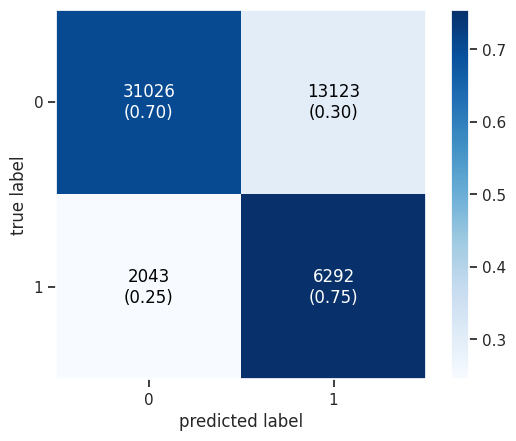

In [70]:
# 2015 Model
rf = RandomForestClassifier(max_depth=12 ,n_estimators =10, random_state=42)

# fitting the model on the train data
rf_model=rf.fit(X_train_2015_mini, y_train_2015_mini)


y_pred_train=rf_model.predict(X_train_2015_mini)
# make predicitons on val set
y_pred_val=rf_model.predict(X_val_2015)
# make predictions on test set
y_pred_test=rf_model.predict(X_test_2015)

# Evaluate the model
print("Train Data Accuracy:", accuracy_score(y_train_2015_mini, y_pred_train))
print("Validation Data Accuracy:", accuracy_score(y_val_2015, y_pred_val))
print("Test Data Accuracy:", accuracy_score(y_test_2015, y_pred_test))
print("Test AUC Score:", roc_auc_score(y_test_2015, y_pred_test))

print("Confusion Matrix:\n", confusion_matrix(y_test_2015, y_pred_test))
print("Classification Report:\n", classification_report(y_test_2015, y_pred_test, digits=4))

# calculating and plotting the confusion matrix
cm1 = confusion_matrix(y_test_2015,y_pred_test)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Test Data Accuracy: 0.7083675849280239
Test AUC Score: 0.7205160568049978
Confusion Matrix:
 [[30485 12934]
 [ 2321  6569]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9293    0.7021    0.7999     43419
           1     0.3368    0.7389    0.4627      8890

    accuracy                         0.7084     52309
   macro avg     0.6330    0.7205    0.6313     52309
weighted avg     0.8286    0.7084    0.7426     52309



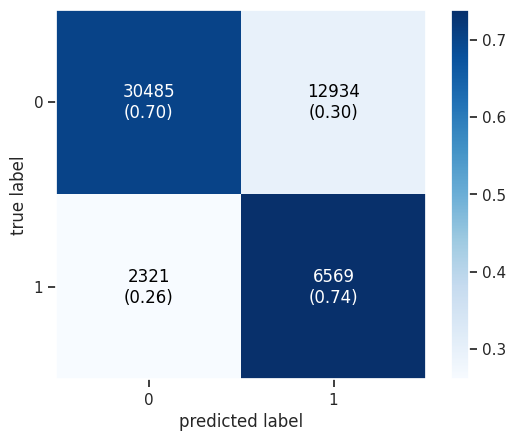

In [72]:
## Apply 2015 model on 2023 data

# make predictions on test set
y_pred_test =rf_model.predict(X_test_2023)
# Evaluate the model
print("Test Data Accuracy:", accuracy_score(y_test_2023, y_pred_test))
print("Test AUC Score:", roc_auc_score(y_test_2023, y_pred_test))

# Evaluate the model on test
print("Confusion Matrix:\n", confusion_matrix(y_test_2023, y_pred_test))
print("Classification Report:\n", classification_report(y_test_2023, y_pred_test, digits=4))

# calculating and plotting the confusion matrix
cm1 = confusion_matrix(y_test_2023,y_pred_test)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Train Data Accuracy: 0.7452084929866901
Validation Data Accuracy: 0.7038351798307139
Test Data Accuracy: 0.7062017501168971
Test AUC Score: 0.7257810598512768
Confusion Matrix:
 [[61001 26567]
 [ 4221 13004]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9353    0.6966    0.7985     87568
           1     0.3286    0.7549    0.4579     17225

    accuracy                         0.7062    104793
   macro avg     0.6320    0.7258    0.6282    104793
weighted avg     0.8356    0.7062    0.7425    104793



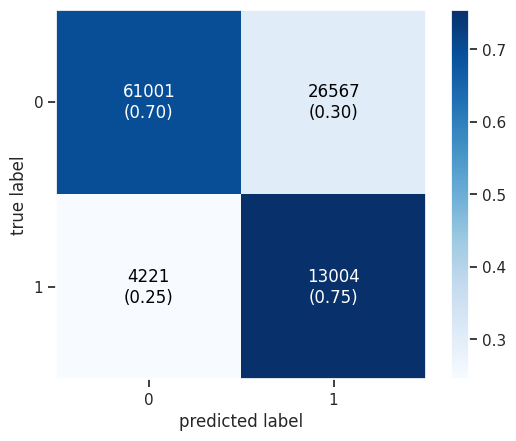

In [71]:
## Combined data
# fitting the model on the train data
rf_combined_model=rf.fit(X_combined_train, y_combined_train)

# make predictions on train, validation, and test set
y_combined_train_pred=rf_combined_model.predict(X_combined_train)
y_combined_val_pred=rf_combined_model.predict(X_combined_val)
y_combined_pred=rf_combined_model.predict(X_combined_test)

# Evaluate the model
print("Train Data Accuracy:", accuracy_score(y_combined_train, y_combined_train_pred))
print("Validation Data Accuracy:", accuracy_score(y_combined_val, y_combined_val_pred))
print("Test Data Accuracy:", accuracy_score(y_combined_test, y_combined_pred))
print("Test AUC Score:", roc_auc_score(y_combined_test, y_combined_pred))
print("Confusion Matrix:\n", confusion_matrix(y_combined_test, y_combined_pred))
print("Classification Report:\n", classification_report(y_combined_test, y_combined_pred, digits=4))

# calculating and plotting the confusion matrix
cm1 = confusion_matrix(y_combined_test,y_combined_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Test Data Accuracy: 0.7083675849280239
Test AUC Score: 0.7205160568049978
Confusion Matrix:
 [[30485 12934]
 [ 2321  6569]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9293    0.7021    0.7999     43419
           1     0.3368    0.7389    0.4627      8890

    accuracy                         0.7084     52309
   macro avg     0.6330    0.7205    0.6313     52309
weighted avg     0.8286    0.7084    0.7426     52309

              precision    recall  f1-score   support

           0       0.93      0.70      0.80     43419
           1       0.34      0.74      0.46      8890

    accuracy                           0.71     52309
   macro avg       0.63      0.72      0.63     52309
weighted avg       0.83      0.71      0.74     52309



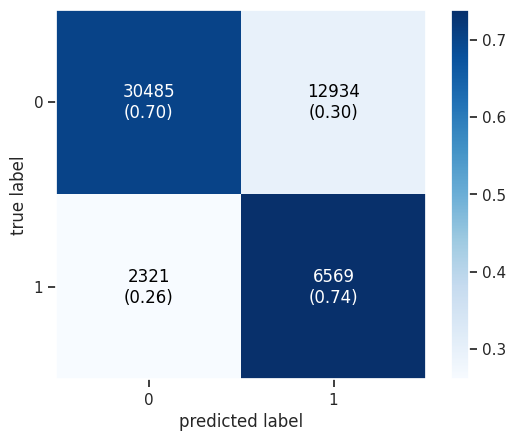

In [44]:
## Apply combined model on 2023 data
# make predictions on test set
y_pred=rf_combined_model.predict(X_test_2023)

# Evaluate the model
print("Test Data Accuracy:", accuracy_score(y_test_2023, y_pred))
print("Test AUC Score:", roc_auc_score(y_test_2023, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_2023, y_pred))
print("Classification Report:\n", classification_report(y_test_2023, y_pred, digits=4))


matrix = classification_report(y_test_2023,y_pred )
print(matrix)

# calculating and plotting the confusion matrix
cm1 = confusion_matrix(y_test_2023,y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

### 5a. Random Forest Hyperparameter Tuning - Grid Search

- Grid search results for 2015 model:

Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}

Best Accuracy: 0.8363942405116395

Test Accuracy: 0.7654523283286335

Confusion Matrix:

 [[36419  7772]

 [ 4538  3755]]

Classification Report:

               precision    recall  f1-score   support

           0       0.89      0.82      0.86     44191
           1       0.33      0.45      0.38      8293

    accuracy                           0.77     52484

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_2015_mini, y_train_2015_mini)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Using the best estimator for predictions
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_2015)

# Evaluate the performance
print("Test Accuracy:", accuracy_score(y_test_2015, y_pred))
print("Test AUC Score:", roc_auc_score(y_test_2015, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_2015, y_pred))
print("Classification Report:\n", classification_report(y_test_2015, y_pred, digits=4))


Train Data Accuracy: 0.920737922130869
Validation Data Accuracy: 0.7674719914640652
Test Data Accuracy: 0.7652427406447679
Test AUC Score: 0.6417222501274282
Confusion Matrix:
 [[36323  7826]
 [ 4495  3840]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8899    0.8227    0.8550     44149
           1     0.3292    0.4607    0.3840      8335

    accuracy                         0.7652     52484
   macro avg     0.6095    0.6417    0.6195     52484
weighted avg     0.8008    0.7652    0.7802     52484



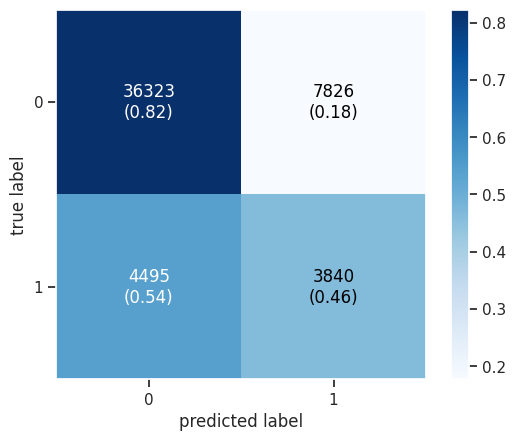

In [68]:
# manually set the model with parameters found in grid search

# {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}
# 2015 Model
rf = RandomForestClassifier(max_depth=None,
                            n_estimators =100,
                            min_samples_split=5,
                            min_samples_leaf=1,
                            bootstrap=False,
                            random_state=42)

# fitting the model on the train data
rf_model=rf.fit(X_train_2015_mini, y_train_2015_mini)


y_pred_train=rf_model.predict(X_train_2015_mini)
# make predicitons on val set
y_pred_val=rf_model.predict(X_val_2015)
# make predictions on test set
y_pred_test=rf_model.predict(X_test_2015)

# Evaluate the model
print("Train Data Accuracy:", accuracy_score(y_train_2015_mini, y_pred_train))
print("Validation Data Accuracy:", accuracy_score(y_val_2015, y_pred_val))
print("Test Data Accuracy:", accuracy_score(y_test_2015, y_pred_test))
print("Test AUC Score:", roc_auc_score(y_test_2015, y_pred_test))

print("Confusion Matrix:\n", confusion_matrix(y_test_2015, y_pred_test))
print("Classification Report:\n", classification_report(y_test_2015, y_pred_test, digits=4))

# calculating and plotting the confusion matrix
cm1 = confusion_matrix(y_test_2015,y_pred_test)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()


Test Data Accuracy: 0.758951614444933
Test AUC Score: 0.625258221669296
Confusion Matrix:
 [[35942  7477]
 [ 5132  3758]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8751    0.8278    0.8508     43419
           1     0.3345    0.4227    0.3735      8890

    accuracy                         0.7590     52309
   macro avg     0.6048    0.6253    0.6121     52309
weighted avg     0.7832    0.7590    0.7697     52309



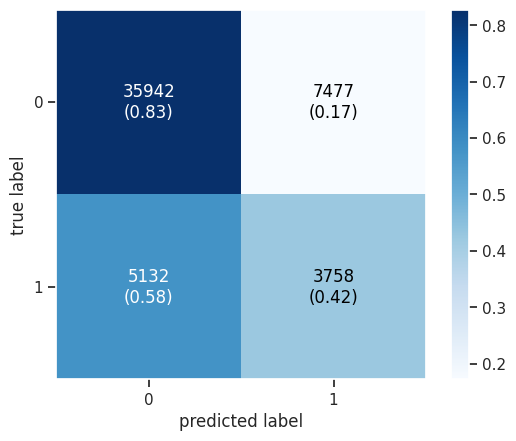

In [64]:
## Apply 2015 model on 2023 data

# make predictions on test set
y_pred_test =rf_model.predict(X_test_2023)
# Evaluate the model
print("Test Data Accuracy:", accuracy_score(y_test_2023, y_pred_test))
print("Test AUC Score:", roc_auc_score(y_test_2023, y_pred_test))

# Evaluate the model on test
print("Confusion Matrix:\n", confusion_matrix(y_test_2023, y_pred_test))
print("Classification Report:\n", classification_report(y_test_2023, y_pred_test, digits=4))

# calculating and plotting the confusion matrix
cm1 = confusion_matrix(y_test_2023,y_pred_test)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

### 5b. Random Forest Hyperparameter Tuning - Grid Search
- Combined model

#### 2023 data grid search results:

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

Best Cross-Validation Accuracy: 0.7711

Train Accuracy: 0.8225717142197955

Validation Accuracy: 0.7174673574337113

Test Accuracy: 0.7198952379131698

Classification Report:

               precision    recall  f1-score   support

           0       0.92      0.73      0.81     43342
           1       0.34      0.69      0.46      8967

    accuracy                           0.72     52309


#### Combined data grid search results:

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


Best Cross-Validation Accuracy: 0.7705

Test Data Accuracy (2023): 0.7220554780248141

Confusion Matrix (2023):

 [[31549 11793]

 [ 2746  6221]]

Classification Report (2023):

               precision    recall  f1-score   support

           0       0.92      0.73      0.81     43342
           1       0.35      0.69      0.46      8967

    accuracy                           0.72     52309


In [ ]:
# for 2023 data grid search
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

# Simplified hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# RandomizedSearchCV with 20 iterations
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,              # Sample 20 random combinations
    scoring='accuracy',
    cv=3,                   # 3-fold cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit on training data (subset for faster execution)
X_train_sample = X_train_2023_mini.sample(frac=0.5, random_state=42)  # 50% data subset
y_train_sample = y_train_2023_mini.loc[X_train_sample.index]

random_search.fit(X_train_sample, y_train_sample)

# Best parameters
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {random_search.best_score_:.4f}")

# Train the best model
best_rf_model = random_search.best_estimator_
best_rf_model.fit(X_train_2023_mini, y_train_2023_mini)

# Evaluate the model
y_pred_train = best_rf_model.predict(X_train_2023_mini)
y_pred_val = best_rf_model.predict(X_val_2023)
y_pred_test = best_rf_model.predict(X_test_2023)

print("Train Accuracy:", accuracy_score(y_train_2023_mini, y_pred_train))
print("Validation Accuracy:", accuracy_score(y_val_2023, y_pred_val))
print("Test Accuracy:", accuracy_score(y_test_2023, y_pred_test))

print("Classification Report:\n", classification_report(y_test_2023, y_pred_test))

# Confusion matrix
cm = confusion_matrix(y_test_2023, y_pred_test)
plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, colorbar=True)
plt.title("Confusion Matrix for Random Forest")
plt.show()


In [ ]:
# for combined data grid search

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

# Simplified hyperparameter grid for faster tuning
param_grid = {
    'n_estimators': [50, 100],                 # Reduce options for the number of trees
    'max_depth': [10, 20],                     # Limit tree depth
    'min_samples_split': [2, 5],               # Fewer split options
    'min_samples_leaf': [1, 2],                # Fewer leaf options
    'max_features': ['sqrt'],                  # Commonly used feature selection
    'bootstrap': [True]                        # Fix bootstrap to one value
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Use RandomizedSearchCV for faster hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,              # Limit to 10 random combinations
    scoring='accuracy',
    cv=3,                   # Reduce cross-validation folds to 3
    verbose=1,              # Display progress
    n_jobs=-1,              # Utilize all available CPU cores
    random_state=42
)

# Fit RandomizedSearchCV on the combined training data
random_search.fit(X_combined_train, y_combined_train)

# Display the best parameters and their corresponding score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {random_search.best_score_:.4f}")

# Train the best model on the combined training data
best_rf_model = random_search.best_estimator_
best_rf_model.fit(X_combined_train, y_combined_train)

# Apply the combined model on the 2023 test data
y_pred = best_rf_model.predict(X_test_2023)

# Evaluate the model on the 2023 test data
print("Test Data Accuracy (2023):", accuracy_score(y_test_2023, y_pred))
print("Confusion Matrix (2023):\n", confusion_matrix(y_test_2023, y_pred))
print("Classification Report (2023):\n", classification_report(y_test_2023, y_pred))

# Plot the confusion matrix
cm1 = confusion_matrix(y_test_2023, y_pred)
plot_confusion_matrix(conf_mat=cm1, show_absolute=True, show_normed=True, colorbar=True)
plt.title("Confusion Matrix for Random Forest (2023 Data)")
plt.show()


Train Data Accuracy: 0.8063476268362519
Validation Data Accuracy: 0.720095807926102
Test Data Accuracy: 0.7214794881337494
Test AUC Score: 0.7165015220516497
Confusion Matrix:
 [[63392 24176]
 [ 5011 12214]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9267    0.7239    0.8129     87568
           1     0.3356    0.7091    0.4556     17225

    accuracy                         0.7215    104793
   macro avg     0.6312    0.7165    0.6342    104793
weighted avg     0.8296    0.7215    0.7541    104793



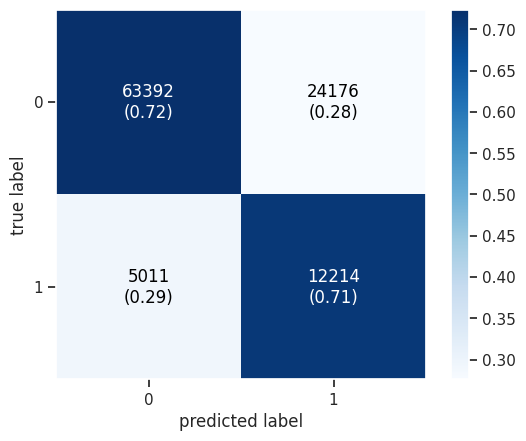

In [19]:
## Combined data - manually using parameters from grid search to show results:
# Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

rf = RandomForestClassifier(max_depth=20,
                            n_estimators =100,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            max_features='sqrt',
                            bootstrap=True,
                            random_state=42)

# fitting the model on the train data
rf_combined_model=rf.fit(X_combined_train, y_combined_train)

# make predictions on train, validation, and test set
y_combined_train_pred=rf_combined_model.predict(X_combined_train)
y_combined_val_pred=rf_combined_model.predict(X_combined_val)
y_combined_pred=rf_combined_model.predict(X_combined_test)

# Evaluate the model
print("Train Data Accuracy:", accuracy_score(y_combined_train, y_combined_train_pred))
print("Validation Data Accuracy:", accuracy_score(y_combined_val, y_combined_val_pred))
print("Test Data Accuracy:", accuracy_score(y_combined_test, y_combined_pred))
print("Test AUC Score:", roc_auc_score(y_combined_test, y_combined_pred))
print("Confusion Matrix:\n", confusion_matrix(y_combined_test, y_combined_pred))
print("Classification Report:\n", classification_report(y_combined_test, y_combined_pred, digits=4))

# calculating and plotting the confusion matrix
cm1 = confusion_matrix(y_combined_test,y_combined_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

Test Data Accuracy: 0.7232216253417194
Test AUC Score: 0.7115281157463967
Confusion Matrix:
 [[31663 11756]
 [ 2722  6168]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9208    0.7292    0.8139     43419
           1     0.3441    0.6938    0.4601      8890

    accuracy                         0.7232     52309
   macro avg     0.6325    0.7115    0.6370     52309
weighted avg     0.8228    0.7232    0.7538     52309

              precision    recall  f1-score   support

           0       0.92      0.73      0.81     43419
           1       0.34      0.69      0.46      8890

    accuracy                           0.72     52309
   macro avg       0.63      0.71      0.64     52309
weighted avg       0.82      0.72      0.75     52309



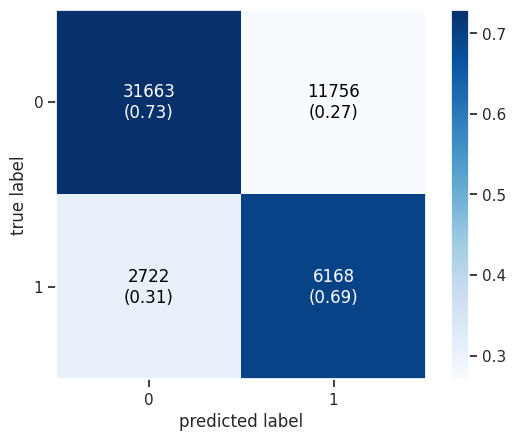

In [21]:
## Apply combined model on 2023 data
# make predictions on test set
y_pred=rf_combined_model.predict(X_test_2023)

# Evaluate the model
print("Test Data Accuracy:", accuracy_score(y_test_2023, y_pred))
print("Test AUC Score:", roc_auc_score(y_test_2023, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_2023, y_pred))
print("Classification Report:\n", classification_report(y_test_2023, y_pred, digits=4))


matrix = classification_report(y_test_2023,y_pred )
print(matrix)

# calculating and plotting the confusion matrix
cm1 = confusion_matrix(y_test_2023,y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

## 6. Gaussian Naive Bayes

Training Gaussian Naive Bayes...

Gaussian Naive Bayes Accuracy on Train Set: 0.7148

Gaussian Naive Bayes Accuracy on Validation Set: 0.6609
Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0     0.9424    0.6358    0.7593     44154
           1     0.2914    0.7940    0.4264      8330

    accuracy                         0.6609     52484
   macro avg     0.6169    0.7149    0.5928     52484
weighted avg     0.8391    0.6609    0.7065     52484


Testing on unseen data:
Gaussian Naive Bayes Test Accuracy: 0.6673
Gaussian Naive Bayes Test AUC Score: 0.7225
Gaussian Naive Bayes Test Classification Report:
              precision    recall  f1-score   support

           0     0.9453    0.6416    0.7644     44149
           1     0.2973    0.8034    0.4340      8335

    accuracy                         0.6673     52484
   macro avg     0.6213    0.7225    0.5992     52484
weighted avg     0.8424    0.6673    0.7119     52484


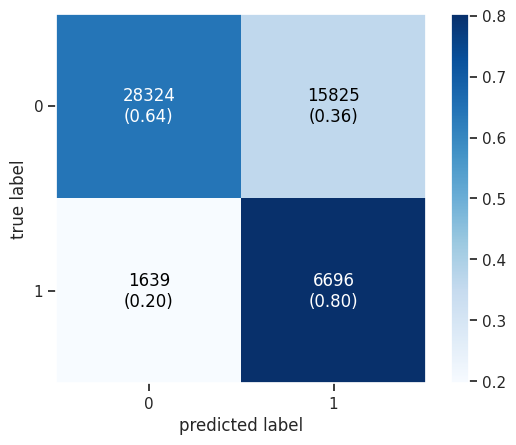

In [36]:
# 2015 data

# Dictionary to store models and their performance
models = {
    "Gaussian Naive Bayes": GaussianNB()
}

# Function to train, evaluate and display results for each model
def train_and_evaluate(models, X_train, y_train, X_val, y_val):
    np.random.seed(1234)

    for model_name, model in models.items():
        print(f"Training {model_name}...")
        model.fit(X_train, y_train)

        # make predictions on training set
        y_train_pred = model.predict(X_train)
        accuracy_train = accuracy_score(y_train, y_train_pred)
        print(f"\n{model_name} Accuracy on Train Set: {accuracy_train:.4f}")

        # Make predictions on validation set
        y_val_pred = model.predict(X_val)

        # Calculate accuracy and other metrics
        accuracy = accuracy_score(y_val, y_val_pred)
        print(f"\n{model_name} Accuracy on Validation Set: {accuracy:.4f}")
        print(f"{model_name} Classification Report:\n{classification_report(y_val, y_val_pred, digits =4)}\n")

    return models

# Train and evaluate models
trained_models = train_and_evaluate(models, X_train_2015_mini_LR, y_train_2015_mini_LR, X_val_2015_LR, y_val_2015)

# Test set evaluation for final model accuracy
print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_test_pred = model.predict(X_test_2015_LR)
    test_accuracy = accuracy_score(y_test_2015, y_test_pred)
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} Test AUC Score: {roc_auc_score(y_test_2015, y_test_pred):.4f}")
    print(f"{model_name} Test Classification Report:\n{classification_report(y_test_2015, y_test_pred, digits=4)}\n")

    # calculating and plotting the confusion matrix
    cm1 = confusion_matrix(y_test_2015,y_test_pred)
    plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                            show_normed=True,
                            colorbar=True)
    plt.show()

Testing on unseen data:
Gaussian Naive Bayes 2023 Data Test Accuracy: 0.6770
Gaussian Naive Bayes 2023 Data Test AUC Score: 0.7094
Gaussian Naive Bayes 2023 Data Test Classification Report:
              precision    recall  f1-score   support

           0     0.9303    0.6603    0.7724     43419
           1     0.3138    0.7585    0.4439      8890

    accuracy                         0.6770     52309
   macro avg     0.6220    0.7094    0.6082     52309
weighted avg     0.8255    0.6770    0.7166     52309




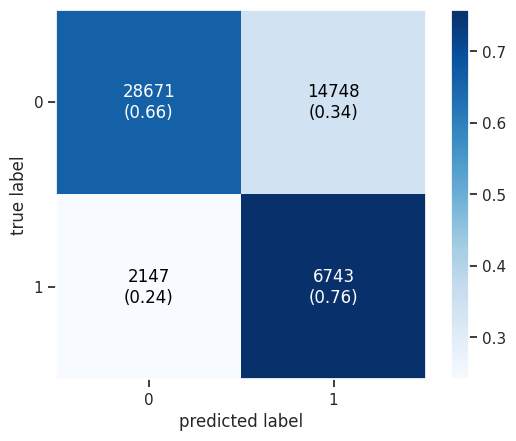

In [37]:
# Apply 2015 model on 2023 test data

print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_test_pred = model.predict(X_test_2023_LR)
    test_accuracy = accuracy_score(y_test_2023, y_test_pred)
    print(f"{model_name} 2023 Data Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} 2023 Data Test AUC Score: {roc_auc_score(y_test_2023, y_test_pred):.4f}")
    print(f"{model_name} 2023 Data Test Classification Report:\n{classification_report(y_test_2023, y_test_pred, digits=4)}\n")

    # calculating and plotting the confusion matrix
    cm1 = confusion_matrix(y_test_2023,y_test_pred)
    plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                            show_normed=True,
                            colorbar=True)

Training Gaussian Naive Bayes...

Gaussian Naive Bayes Accuracy on Train Set: 0.7096

Gaussian Naive Bayes Accuracy on combined data Validation Set: 0.6554
Gaussian Naive Bayes Combined data Classification Report:
              precision    recall  f1-score   support

           0     0.9385    0.6291    0.7533     87625
           1     0.2943    0.7895    0.4288     17168

    accuracy                         0.6554    104793
   macro avg     0.6164    0.7093    0.5910    104793
weighted avg     0.8329    0.6554    0.7001    104793


Testing on unseen data:
Gaussian Naive Bayes Combined data Test Accuracy: 0.6575
Gaussian Naive Bayes Combined data Test AUC Score: 0.7129
Gaussian Naive Bayes Combined data Test Classification Report:
              precision    recall  f1-score   support

           0     0.9400    0.6304    0.7546     87568
           1     0.2974    0.7954    0.4329     17225

    accuracy                         0.6575    104793
   macro avg     0.6187    0.7129    0

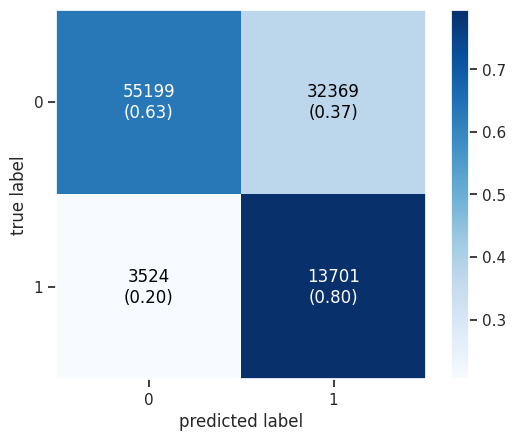

In [38]:
## Combined model
# Function to train, evaluate and display results for each model
def train_and_evaluate(models, X_combined_train, y_combined_train, X_combined_val, y_combined_val):
    np.random.seed(1234)

    for model_name, model in models.items():
        print(f"Training {model_name}...")
        model.fit(X_combined_train, y_combined_train)

        # Make predictions on train set
        y_combined_train_pred = model.predict(X_combined_train)
        accuracy_train = accuracy_score(y_combined_train, y_combined_train_pred)
        print(f"\n{model_name} Accuracy on Train Set: {accuracy_train:.4f}")

        # Make predictions on validation set
        y_combined_val_pred = model.predict(X_combined_val)

        # Calculate accuracy and other metrics
        accuracy = accuracy_score(y_combined_val, y_combined_val_pred)
        print(f"\n{model_name} Accuracy on combined data Validation Set: {accuracy:.4f}")
        print(f"{model_name} Combined data Classification Report:\n{classification_report(y_combined_val, y_combined_val_pred, digits=4)}\n")

    return models

# Train and evaluate models
trained_models = train_and_evaluate(models, X_combined_train_LR, y_combined_train_LR, X_combined_val_LR, y_combined_val)

# Test set evaluation for final model accuracy
print("Testing on unseen data:")
for model_name, model in trained_models.items():

    y_combined_test_pred = model.predict(X_combined_test_LR)
    test_accuracy = accuracy_score(y_combined_test, y_combined_test_pred)
    print(f"{model_name} Combined data Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} Combined data Test AUC Score: {roc_auc_score(y_combined_test, y_combined_test_pred):.4f}")
    print(f"{model_name} Combined data Test Classification Report:\n{classification_report(y_combined_test, y_combined_test_pred, digits=4)}\n")

    # calculating and plotting the confusion matrix
    cm1 = confusion_matrix(y_combined_test,y_combined_test_pred)
    plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                            show_normed=True,
                            colorbar=True)



Testing on unseen data:
Gaussian Naive Bayes 2023 Data Test Accuracy: 0.6632
Gaussian Naive Bayes 2023 Data Test AUC Score: 0.7075
Gaussian Naive Bayes 2023 Data Test Classification Report:
              precision    recall  f1-score   support

           0     0.9328    0.6404    0.7594     43419
           1     0.3061    0.7747    0.4388      8890

    accuracy                         0.6632     52309
   macro avg     0.6194    0.7075    0.5991     52309
weighted avg     0.8263    0.6632    0.7049     52309




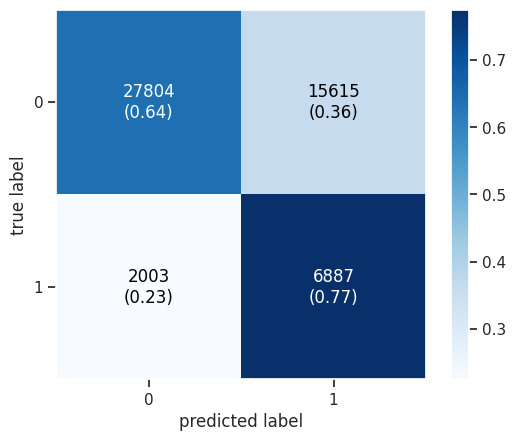

In [39]:
# Apply combined model on 2023 test data

print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_test_pred = model.predict(X_test_2023_LR)
    test_accuracy = accuracy_score(y_test_2023, y_test_pred)
    print(f"{model_name} 2023 Data Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} 2023 Data Test AUC Score: {roc_auc_score(y_test_2023, y_test_pred):.4f}")
    print(f"{model_name} 2023 Data Test Classification Report:\n{classification_report(y_test_2023, y_test_pred, digits=4)}\n")

    # calculating and plotting the confusion matrix
    cm1 = confusion_matrix(y_test_2023,y_test_pred)
    plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                            show_normed=True,
                            colorbar=True)


## 7. Neural Network

In [29]:
# 2015 data

# Dictionary to store models and their performance
models = {
    "Neural Network": MLPClassifier(max_iter=500, # default is 200, this takes 13 min to run
                                    random_state=42)
}

# Function to train, evaluate and display results for each model
def train_and_evaluate(models, X_train, y_train, X_val, y_val):
    np.random.seed(1234)

    for model_name, model in models.items():
        print(f"Training {model_name}...")
        model.fit(X_train, y_train)

        # Make predictions on train set
        y_train_pred = model.predict(X_train)

        # Calculate accuracy and other metrics
        accuracy_train = accuracy_score(y_train, y_train_pred)
        print(f"\n{model_name} Accuracy on Train Set: {accuracy_train:.4f}")

        # Make predictions on validation set
        y_val_pred = model.predict(X_val)

        # Calculate accuracy and other metrics
        accuracy = accuracy_score(y_val, y_val_pred)
        print(f"\n{model_name} Accuracy on Validation Set: {accuracy:.4f}")
        print(f"{model_name} Classification Report:\n{classification_report(y_val, y_val_pred)}\n")

    return models

# Train and evaluate models
trained_models = train_and_evaluate(models, X_train_2015_mini, y_train_2015_mini, X_val_2015, y_val_2015)

# Test set evaluation for final model accuracy
print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_test_pred = model.predict(X_test_2015)
    test_accuracy = accuracy_score(y_test_2015, y_test_pred)
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} Test Classification Report:\n{classification_report(y_test_2015, y_test_pred)}\n")

Training Neural Network...

Neural Network Accuracy on Train Set: 0.8158

Neural Network Accuracy on Validation Set: 0.7627
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85     44154
           1       0.34      0.50      0.40      8330

    accuracy                           0.76     52484
   macro avg       0.62      0.66      0.63     52484
weighted avg       0.81      0.76      0.78     52484


Testing on unseen data:
Neural Network Test Accuracy: 0.7629
Neural Network Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85     44149
           1       0.34      0.50      0.40      8335

    accuracy                           0.76     52484
   macro avg       0.62      0.66      0.63     52484
weighted avg       0.81      0.76      0.78     52484




In [30]:
# Apply 2015 model on 2023 test data

print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_pred = model.predict(X_test_2023)
    test_accuracy = accuracy_score(y_test_2023, y_pred)
    print(f"{model_name} 2023 Data Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} 2023 Data Test Classification Report:\n{classification_report(y_test_2023, y_pred)}\n")

Testing on unseen data:
Neural Network 2023 Data Test Accuracy: 0.7575
Neural Network 2023 Data Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.85     43419
           1       0.35      0.48      0.40      8890

    accuracy                           0.76     52309
   macro avg       0.62      0.65      0.63     52309
weighted avg       0.79      0.76      0.77     52309




In [31]:
## Combined model
# Function to train, evaluate and display results for each model
def train_and_evaluate(models, X_combined_train, y_combined_train, X_combined_val, y_combined_val):
    np.random.seed(1234)

    for model_name, model in models.items():
        print(f"Training {model_name}...")
        model.fit(X_combined_train, y_combined_train)

        #make predictions on training set
        y_combined_train_pred = model.predict(X_combined_train)

        # Calculate accuracy and other metrics
        accuracy_train = accuracy_score(y_combined_train, y_combined_train_pred)
        print(f"\n{model_name} Accuracy on Combined Data Training Set: {accuracy_train:.4f}")

        # Make predictions on validation set
        y_combined_val_pred = model.predict(X_combined_val)

        # Calculate accuracy and other metrics
        accuracy = accuracy_score(y_combined_val, y_combined_val_pred)
        print(f"\n{model_name} Accuracy on Combined Data Validation Set: {accuracy:.4f}")
        print(f"{model_name} Combined data Classification Report:\n{classification_report(y_combined_val, y_combined_val_pred)}\n")

    return models

# Train and evaluate models
trained_models = train_and_evaluate(models, X_combined_train, y_combined_train, X_combined_val, y_combined_val)

# Test set evaluation for final model accuracy
print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_combined_test_pred = model.predict(X_combined_test)
    test_accuracy = accuracy_score(y_combined_test, y_combined_test_pred)
    print(f"{model_name} Combined data Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} Combined data Test Classification Report:\n{classification_report(y_combined_test, y_combined_test_pred)}\n")

Training Neural Network...

Neural Network Accuracy on Combined Data Training Set: 0.7918

Neural Network Accuracy on Combined Data Validation Set: 0.7749
Neural Network Combined data Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86     87625
           1       0.36      0.49      0.42     17168

    accuracy                           0.77    104793
   macro avg       0.63      0.66      0.64    104793
weighted avg       0.81      0.77      0.79    104793


Testing on unseen data:
Neural Network Combined data Test Accuracy: 0.7746
Neural Network Combined data Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86     87568
           1       0.36      0.50      0.42     17225

    accuracy                           0.77    104793
   macro avg       0.63      0.66      0.64    104793
weighted avg       0.81      0.77      0.79    104793




In [32]:
# Apply combined model on 2023 test data

print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_pred = model.predict(X_test_2023)
    test_accuracy = accuracy_score(y_test_2023, y_pred)
    print(f"{model_name} 2023 Data Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} 2023 Data Test Classification Report:\n{classification_report(y_test_2023, y_pred)}\n")

Testing on unseen data:
Neural Network 2023 Data Test Accuracy: 0.7715
Neural Network 2023 Data Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86     43419
           1       0.37      0.49      0.42      8890

    accuracy                           0.77     52309
   macro avg       0.63      0.66      0.64     52309
weighted avg       0.80      0.77      0.78     52309




### 7a. Neural Network Hyperparameter Tuning

- 2015 model

- Iteration 1: **Hidden layer** tuning: (50,) , activator relu, solver adam, alpah .001, LR .001
- Iteration 2: **Learning Rate**: (50,) hidden layer, activ relu, solver adam, alpha .001, LR .1
- Iteration 3: **alpha**: (50,) hidden layer, activ relu, solver adam, alpha .01, LR .1
- Iteration 4: **solver and LR and alpha**: solver sgd, LR .1 and .08, alpha .001 and .01 - none performed better
- Iteration 5: **LR and alpha** learning rates .05 and .08, alpha .001, .01



- 'hidden_layer_sizes': [(50,), (100,), (100, 50)],
- 'solver': ['adam', 'sgd'],
- 'alpha': [0.0001, 0.001, 0.01, 0.1],
- 'learning_rate_init': [0.001, 0.01, 0.1]

Training Neural Network 1...

Neural Network 1 Accuracy on Train Set: 0.7862

Neural Network 1 Accuracy on Validation Set: 0.7618
Neural Network 1 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.79      0.85     44154
           1       0.35      0.59      0.44      8330

    accuracy                           0.76     52484
   macro avg       0.63      0.69      0.65     52484
weighted avg       0.82      0.76      0.78     52484


Training Neural Network 2...

Neural Network 2 Accuracy on Train Set: 0.7866

Neural Network 2 Accuracy on Validation Set: 0.7428
Neural Network 2 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.76      0.83     44154
           1       0.34      0.65      0.45      8330

    accuracy                           0.74     52484
   macro avg       0.63      0.71      0.64     52484
weighted avg       0.83      0.74      0.77     52484




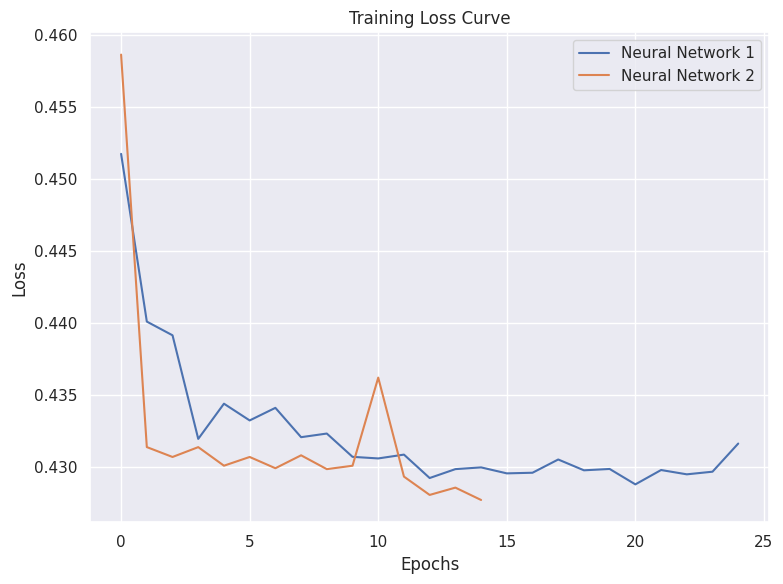

Testing on unseen data:
Neural Network 1 Test Accuracy: 0.7636
Test AUC Score: 0.696493099395931
Neural Network 1 Test Classification Report:
              precision    recall  f1-score   support

           0     0.9129    0.7948    0.8497     44149
           1     0.3550    0.5982    0.4456      8335

    accuracy                         0.7636     52484
   macro avg     0.6339    0.6965    0.6477     52484
weighted avg     0.8243    0.7636    0.7856     52484


Neural Network 2 Test Accuracy: 0.7435
Test AUC Score: 0.7058331820464601
Neural Network 2 Test Classification Report:
              precision    recall  f1-score   support

           0     0.9202    0.7610    0.8331     44149
           1     0.3395    0.6506    0.4462      8335

    accuracy                         0.7435     52484
   macro avg     0.6299    0.7058    0.6396     52484
weighted avg     0.8280    0.7435    0.7717     52484


Testing on unseen data:
Neural Network 1 2023 Data Test Accuracy: 0.7618
Neural Net

In [73]:
# 2015 data -- 11min

# Dictionary to store models and their performance
models = {
        "Neural Network 1": MLPClassifier(max_iter=500, # default is 200
                                    early_stopping=True,
                                    hidden_layer_sizes=(50,),
                                    activation='relu',
                                    solver='adam',
                                    alpha=0.001,
                                    learning_rate_init=0.08,
                                    random_state=42),
            "Neural Network 2": MLPClassifier(max_iter=500, # default is 200
                                    early_stopping=True,
                                    hidden_layer_sizes=(50,),
                                    activation='relu',
                                    solver='adam',
                                    alpha=0.01,
                                    learning_rate_init=0.05,
                                    random_state=42),
}

# Function to train, evaluate, and plot results
def train_and_evaluate(models, X_train, y_train, X_val, y_val):
    np.random.seed(1234)

    history = {}

    for model_name, model in models.items():
        print(f"Training {model_name}...")

        # Train model
        model.fit(X_train, y_train)

        # Save training history
        history[model_name] = {
            'loss': model.loss_curve_
        }

        # Evaluate train accuracy
        y_train_pred = model.predict(X_train)
        accuracy_train = accuracy_score(y_train, y_train_pred)
        print(f"\n{model_name} Accuracy on Train Set: {accuracy_train:.4f}")

        # Evaluate validation accuracy
        y_val_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_val_pred)
        print(f"\n{model_name} Accuracy on Validation Set: {accuracy:.4f}")
        print(f"{model_name} Classification Report:\n{classification_report(y_val, y_val_pred)}\n")

    # Plot training and validation curves
    plot_training_curves(history)
    return models


# Function to plot training curves
def plot_training_curves(history):
    fig, ax = plt.subplots(figsize=(8, 6))

    for model_name, metrics in history.items():
        # Plot Loss Curve
        ax.plot(metrics['loss'], label=f'{model_name}')

    ax.set_title('Training Loss Curve')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

    plt.tight_layout()
    plt.show()



# Train and evaluate models
trained_models = train_and_evaluate(models, X_train_2015_mini, y_train_2015_mini, X_val_2015, y_val_2015)

# Test set evaluation for final model accuracy
print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_test_pred = model.predict(X_test_2015)
    test_accuracy = accuracy_score(y_test_2015, y_test_pred)
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
    print("Test AUC Score:", roc_auc_score(y_test_2015, y_test_pred))
    print(f"{model_name} Test Classification Report:\n{classification_report(y_test_2015, y_test_pred, digits=4)}\n")


# Apply 2015 model on 2023 test data

print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_pred = model.predict(X_test_2023)
    test_accuracy = accuracy_score(y_test_2023, y_pred)
    print(f"{model_name} 2023 Data Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} 2023 Data Test AUC Score:", roc_auc_score(y_test_2023, y_pred))
    print(f"{model_name} 2023 Data Test Classification Report:\n{classification_report(y_test_2023, y_pred, digits=4)}\n")

Training Neural Network 1...

Neural Network 1 Accuracy on Train Set: 0.7786

Neural Network 1 Accuracy on Validation Set: 0.7551
Neural Network 1 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84     87625
           1       0.35      0.57      0.43     17168

    accuracy                           0.76    104793
   macro avg       0.63      0.68      0.64    104793
weighted avg       0.81      0.76      0.78    104793


Training Neural Network 2...

Neural Network 2 Accuracy on Train Set: 0.7790

Neural Network 2 Accuracy on Validation Set: 0.7416
Neural Network 2 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.76      0.83     87625
           1       0.34      0.64      0.45     17168

    accuracy                           0.74    104793
   macro avg       0.63      0.70      0.64    104793
weighted avg       0.82      0.74      0.77    104793




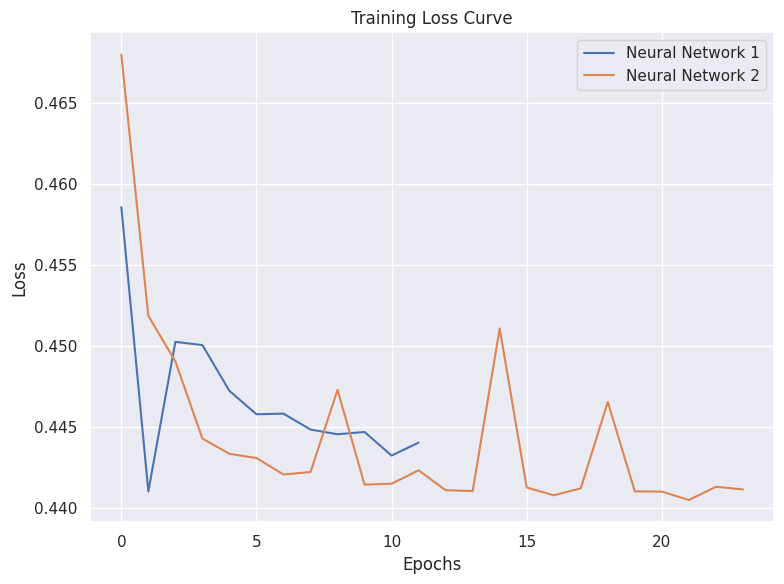

Testing on unseen data:
Neural Network 1 Combined data Test Accuracy: 0.7542
Neural Network 1 Combined data Test AUC Score: 0.6819772752345131
Neural Network 1 Combined data Test Classification Report:
              precision    recall  f1-score   support

           0     0.9041    0.7896    0.8430     87568
           1     0.3494    0.5743    0.4345     17225

    accuracy                         0.7542    104793
   macro avg     0.6268    0.6820    0.6387    104793
weighted avg     0.8129    0.7542    0.7758    104793


Neural Network 2 Combined data Test Accuracy: 0.7404
Neural Network 2 Combined data Test AUC Score: 0.7015564917312778
Neural Network 2 Combined data Test Classification Report:
              precision    recall  f1-score   support

           0     0.9155    0.7595    0.8302     87568
           1     0.3448    0.6437    0.4491     17225

    accuracy                         0.7404    104793
   macro avg     0.6302    0.7016    0.6396    104793
weighted avg     0.8

In [74]:
# Train and evaluate models - 16 min
trained_models = train_and_evaluate(models, X_combined_train, y_combined_train, X_combined_val, y_combined_val)

# Test set evaluation for final model accuracy
print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_combined_test_pred = model.predict(X_combined_test)
    test_accuracy = accuracy_score(y_combined_test, y_combined_test_pred)
    print(f"{model_name} Combined data Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} Combined data Test AUC Score:", roc_auc_score(y_combined_test, y_combined_test_pred))
    print(f"{model_name} Combined data Test Classification Report:\n{classification_report(y_combined_test, y_combined_test_pred, digits=4)}\n")

In [75]:
# Apply combined model on 2023 test data

print("Testing on unseen data:")
for model_name, model in trained_models.items():
    y_pred = model.predict(X_test_2023)
    test_accuracy = accuracy_score(y_test_2023, y_pred)
    print(f"{model_name} 2023 Data Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} 2023 Data Test AUC Score:", roc_auc_score(y_test_2023, y_pred))
    print(f"{model_name} 2023 Data Test Classification Report:\n{classification_report(y_test_2023, y_pred, digits=4)}\n")

Testing on unseen data:
Neural Network 1 2023 Data Test Accuracy: 0.7555
Neural Network 1 2023 Data Test AUC Score: 0.6808043051655784
Neural Network 1 2023 Data Test Classification Report:
              precision    recall  f1-score   support

           0     0.8997    0.7939    0.8435     43419
           1     0.3606    0.5677    0.4411      8890

    accuracy                         0.7555     52309
   macro avg     0.6301    0.6808    0.6423     52309
weighted avg     0.8081    0.7555    0.7751     52309


Neural Network 2 2023 Data Test Accuracy: 0.7392
Neural Network 2 2023 Data Test AUC Score: 0.6971482072134061
Neural Network 2 2023 Data Test Classification Report:
              precision    recall  f1-score   support

           0     0.9102    0.7609    0.8289     43419
           1     0.3517    0.6334    0.4522      8890

    accuracy                         0.7392     52309
   macro avg     0.6309    0.6971    0.6406     52309
weighted avg     0.8153    0.7392    0.7649 

## 8. Neural Network with TensorFlow

In [76]:
print(X_train_2015_mini.columns)

Index(['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'HvyAlcoholConsump',
       'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex', 'BMI_class',
       'GenHlth_1', 'GenHlth_2', 'GenHlth_3', 'GenHlth_4', 'GenHlth_5',
       'MentHlth_class_0', 'MentHlth_class_1', 'MentHlth_class_2',
       'PhysHlth_class_0', 'PhysHlth_class_1', 'PhysHlth_class_2', 'Age_1',
       'Age_2', 'Age_3', 'Age_4', 'Age_5', 'Age_6', 'Age_7', 'Age_8', 'Age_9',
       'Age_10', 'Age_11', 'Age_12', 'Age_13', 'Education_1', 'Education_2',
       'Education_3', 'Education_4', 'Education_5', 'Education_6', 'Income_1',
       'Income_2', 'Income_3', 'Income_4', 'Income_5', 'Income_6', 'Income_7',
       'Income_8'],
      dtype='object')


In [77]:
import tensorflow as tf

def build_model():
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Input layers (dtype=int64)
    highBP = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='HighBP')
    highChol = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='HighChol')
    smoker = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Smoker')
    stroke = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Stroke')
    heartDiseaseorAttack = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='HeartDiseaseorAttack')
    physActivity = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='PhysActivity')
    diffWalk = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='DiffWalk')
    sex = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Sex')
    bmi_class = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='BMI_class')
    genHlth_2 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='GenHlth_2')
    genHlth_3 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='GenHlth_3')
    genHlth_4 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='GenHlth_4')
    genHlth_5 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='GenHlth_5')
    age_2 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_2')
    age_3 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_3')
    age_4 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_4')
    age_5 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_5')
    age_6 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_6')
    age_7 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_7')
    age_8 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_8')
    age_9 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_9')
    age_10 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_10')
    age_11 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_11')
    age_12 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_12')
    age_13 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_13')
    education_2 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Education_2')
    education_3 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Education_3')
    education_4 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Education_4')
    education_5 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Education_5')
    education_6 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Education_6')
    income_2 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Income_2')
    income_3 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Income_3')
    income_4 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Income_4')
    income_5 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Income_5')
    income_6 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Income_6')
    income_7 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Income_7')
    income_8 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Income_8')
    physHlth_class_1 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='PhysHlth_class_1')
    physHlth_class_2 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='PhysHlth_class_2')

    # Cast inputs to float32
    inputs = [highBP, highChol, smoker, stroke, heartDiseaseorAttack, physActivity, diffWalk, sex,
              bmi_class, genHlth_2, genHlth_3, genHlth_4, genHlth_5, age_2, age_3, age_4, age_5,
              age_6, age_7, age_8, age_9, age_10, age_11, age_12, age_13, education_2, education_3,
              education_4, education_5, education_6, income_2, income_3, income_4, income_5, income_6,
              income_7, income_8, physHlth_class_1, physHlth_class_2]

    casted_inputs = [tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32))(inp) for inp in inputs]

    # Concatenate all inputs
    features = tf.keras.layers.Concatenate()(casted_inputs)

    # Hidden layers
    dense = tf.keras.layers.Dense(units=12, activation='tanh', name='hidden1')(features)

    # Output layer
    diabetes = tf.keras.layers.Dense(units=1, activation='sigmoid', name='diabetes')(dense)

    # Model definition
    model = tf.keras.Model(inputs=inputs, outputs=diabetes, name='DiabetesModel')

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.857461 to fit



Model: "DiabetesModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ HighBP (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ HighChol (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Smoker (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Stroke (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ HeartDiseaseorAttack      │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ PhysActivity (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DiffWalk (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Sex (InputLayer)          │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ BMI_class (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GenHlth_2 (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GenHlth_3 (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GenHlth_4 (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GenHlth_5 (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_2 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_3 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_4 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_5 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_6 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_7 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├──────────────────────

 Total params: 493 (1.93 KB)

 Trainable params: 493 (1.93 KB)

 Non-trainable params: 0 (0.00 B)

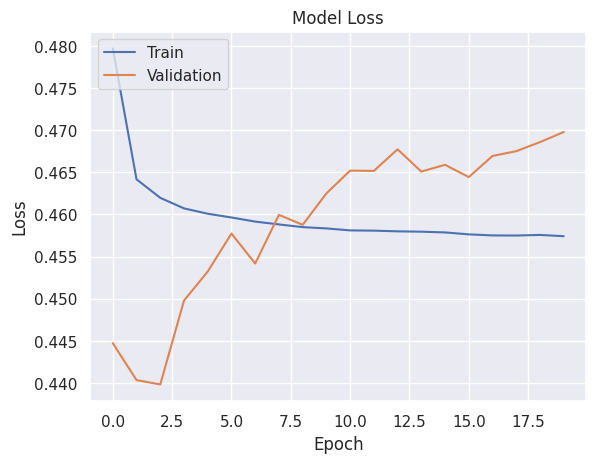

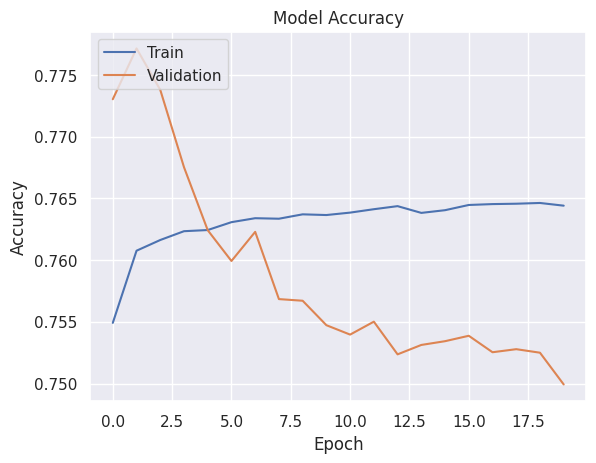

In [78]:
model_2015 = build_model() # 5 min to run

# Plot the model architecture
tf.keras.utils.plot_model(model_2015, show_shapes=True, show_layer_names=True)

# Convert inputs to numpy
X_train_np = {col: X_train_2015_mini[[col]].to_numpy() for col in X_train_2015_mini.columns}
X_val_np = {col: X_val_2015[[col]].to_numpy() for col in X_val_2015.columns}

# Model Summary
model_2015.summary()

# Fit the model
history_2015 = model_2015.fit(
    x=X_train_np,
    y=y_train_2015_mini.to_numpy(),  # Ensure target is numpy array
    epochs=20,
    batch_size=64,
    validation_data=(X_val_np, y_val_2015.to_numpy()),
    verbose=0
)

# Show training history
#show_history(history_2015)
#import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history_2015.history['loss'])
plt.plot(history_2015.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy if available
if 'accuracy' in history_2015.history:
    plt.plot(history_2015.history['accuracy'])
    plt.plot(history_2015.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()



1641/1641 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
Test Data Accuracy: 0.7494283972258212
AUC Score: 0.7039537839787589
Confusion Matrix:
 [[34021 10128]
 [ 3023  5312]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9184    0.7706    0.8380     44149
           1     0.3440    0.6373    0.4469      8335

    accuracy                         0.7494     52484
   macro avg     0.6312    0.7040    0.6424     52484
weighted avg     0.8272    0.7494    0.7759     52484



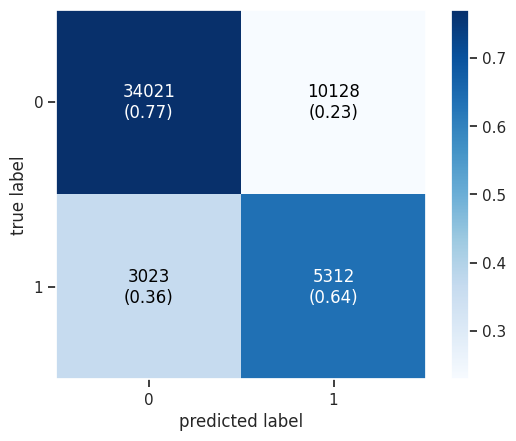

In [79]:
# Test on 2015
# Convert test inputs to numpy arrays
X_test_np = {col: X_test_2015[[col]].to_numpy() for col in X_test_2015.columns}

# Predict probabilities and convert to binary predictions
y_2015_pred = model_2015.predict(X_test_np)
y_2015_pred_binary = (y_2015_pred > 0.5).astype(int)

# Ensure y_test is a numpy array
y_test_np = y_test_2015.to_numpy().ravel()

# Evaluate the model
print("Test Data Accuracy:", accuracy_score(y_test_np, y_2015_pred_binary))
print("AUC Score:", roc_auc_score(y_test_np, y_2015_pred_binary))
print("Confusion Matrix:\n", confusion_matrix(y_test_np, y_2015_pred_binary))
print("Classification Report:\n", classification_report(y_test_np, y_2015_pred_binary, digits = 4))

# Confusion matrix and plot
cm1 = confusion_matrix(y_test_np, y_2015_pred_binary)
plot_confusion_matrix(conf_mat=cm1, show_absolute=True, show_normed=True, colorbar=True)
plt.show()


1635/1635 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
Test Data Accuracy: 0.7370242214532872
AUC Score: 0.6888911747566827
Confusion Matrix:
 [[33077 10342]
 [ 3414  5476]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9064    0.7618    0.8279     43419
           1     0.3462    0.6160    0.4433      8890

    accuracy                         0.7370     52309
   macro avg     0.6263    0.6889    0.6356     52309
weighted avg     0.8112    0.7370    0.7625     52309



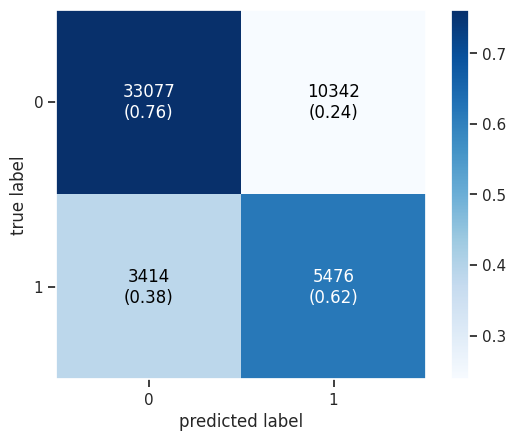

In [80]:
## Apply 2015 Model on 2023 test data
# Convert the input data to numpy arrays (similar to how it's done in the training code)
df_2023_X_np = {col: X_test_2023[[col]].to_numpy() for col in X_test_2023.columns}

# Predict probabilities using the model
df_2023_y_pred = model_2015.predict(df_2023_X_np)

# If it's binary classification, binarize the probabilities
df_2023_y_pred = (df_2023_y_pred > 0.5).astype(int)  # Binarize predictions

# Convert df_2023_y to a numpy array if it is a DataFrame
df_2023_y_np = y_test_2023.to_numpy().ravel()  # Flatten to ensure it's a 1D array

# Evaluate the model
print("Test Data Accuracy:", accuracy_score(df_2023_y_np, df_2023_y_pred))
print("AUC Score:", roc_auc_score(df_2023_y_np, df_2023_y_pred))
print("Confusion Matrix:\n", confusion_matrix(df_2023_y_np, df_2023_y_pred))
print("Classification Report:\n", classification_report(df_2023_y_np, df_2023_y_pred, digits=4))

# Confusion matrix and plot
cm1 = confusion_matrix(df_2023_y_np, df_2023_y_pred)
plot_confusion_matrix(conf_mat=cm1, show_absolute=True, show_normed=True, colorbar=True)
plt.show()


In [81]:
print(X_combined_train.shape)
print(y_combined_train.shape)

(524574, 51)
(524574,)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.857461 to fit



Model: "DiabetesModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ HighBP (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ HighChol (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Smoker (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Stroke (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ HeartDiseaseorAttack      │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ PhysActivity (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DiffWalk (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Sex (InputLayer)          │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ BMI_class (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GenHlth_2 (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GenHlth_3 (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GenHlth_4 (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GenHlth_5 (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_2 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_3 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_4 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_5 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_6 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_7 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├──────────────────────

 Total params: 493 (1.93 KB)

 Trainable params: 493 (1.93 KB)

 Non-trainable params: 0 (0.00 B)

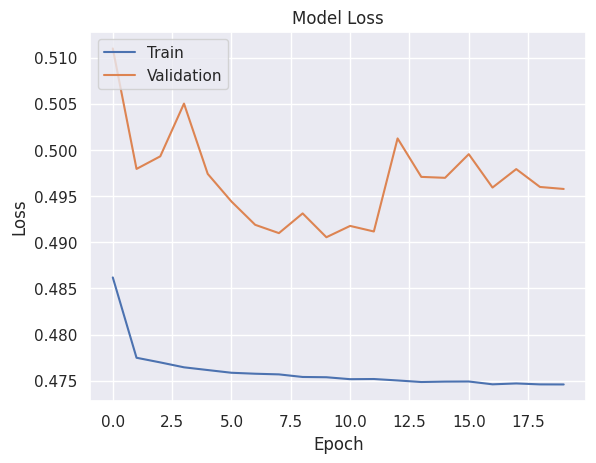

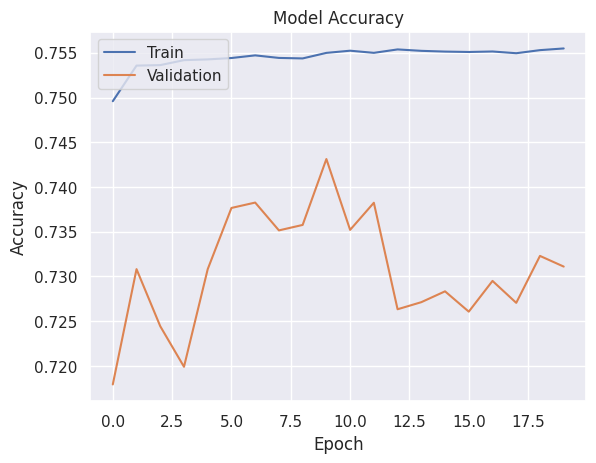

In [82]:
# Step 1: Build the model (same as before)
model_combined = build_model()

# Plot the model architecture
tf.keras.utils.plot_model(model_combined, show_shapes=True, show_layer_names=True)

# Step 2: Convert inputs to numpy (ensuring column names match)
X_combined_train_np = {col: X_combined_train[[col]].to_numpy() for col in X_combined_train.columns}
X_combined_val_np = {col: X_combined_val[[col]].to_numpy() for col in X_combined_val.columns}


# Step 3: Model Summary (optional)
model_combined.summary()

# Step 4: Fit the model
history_combined = model_combined.fit(
    x=X_combined_train_np,   # Pass the training features
    y=y_combined_train.to_numpy(),  # Ensure target is numpy array
    epochs=20,
    batch_size=64,
    validation_data=(X_combined_val_np, y_combined_val.to_numpy()),  # Validation data
    verbose=0  # Set to 1 for more verbose output
)

# Show training history
#show_history(history_combined)
#import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history_combined.history['loss'])
plt.plot(history_combined.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy if available
if 'accuracy' in history_combined.history:
    plt.plot(history_combined.history['accuracy'])
    plt.plot(history_combined.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


3275/3275 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step
Test Data Accuracy: 0.7301919021308675
AUC Score: 0.7077239768813627
Confusion Matrix:
 [[64905 22663]
 [ 5611 11614]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9204    0.7412    0.8211     87568
           1     0.3388    0.6743    0.4510     17225

    accuracy                         0.7302    104793
   macro avg     0.6296    0.7077    0.6361    104793
weighted avg     0.8248    0.7302    0.7603    104793



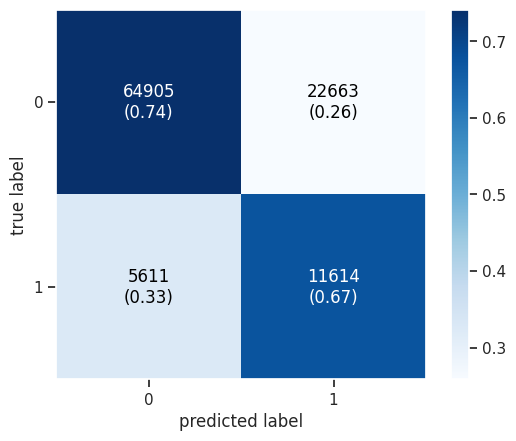

In [83]:
# Convert test inputs to numpy arrays
X_combined_test_np = {col: X_combined_test[[col]].to_numpy() for col in X_combined_test.columns}

# Predict probabilities and convert to binary predictions
y_combined_pred = model_combined.predict(X_combined_test_np)
y_combined_pred_binary = (y_combined_pred > 0.5).astype(int)

# Ensure y_test is a numpy array
y_combined_test_np = y_combined_test.to_numpy().ravel()

print("Test Data Accuracy:", accuracy_score(y_combined_test_np, y_combined_pred_binary))
print("AUC Score:", roc_auc_score(y_combined_test_np, y_combined_pred_binary))
print("Confusion Matrix:\n", confusion_matrix(y_combined_test_np, y_combined_pred_binary))
print("Classification Report:\n", classification_report(y_combined_test_np, y_combined_pred_binary, digits=4))

# Confusion matrix and plot
cm1 = confusion_matrix(y_combined_test_np, y_combined_pred_binary)
plot_confusion_matrix(conf_mat=cm1, show_absolute=True, show_normed=True, colorbar=True)
plt.show()


1635/1635 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step
Test Data Accuracy: 0.7267009501233057
AUC Score: 0.7019054266803675
Confusion Matrix:
 [[32107 11312]
 [ 2984  5906]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9150    0.7395    0.8179     43419
           1     0.3430    0.6643    0.4524      8890

    accuracy                         0.7267     52309
   macro avg     0.6290    0.7019    0.6352     52309
weighted avg     0.8178    0.7267    0.7558     52309



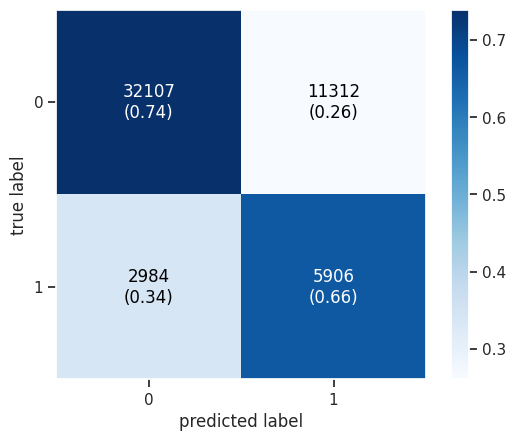

In [84]:
## Apply combined Model on 2023 test data
# Convert the input data to numpy arrays (similar to how it's done in the training code)
df_2023_X_np = {col: X_test_2023[[col]].to_numpy() for col in X_test_2023.columns}

# Predict probabilities using the model
df_2023_y_pred = model_combined.predict(df_2023_X_np)

# If it's binary classification, binarize the probabilities
df_2023_y_pred = (df_2023_y_pred > 0.5).astype(int)  # Binarize predictions

# Convert df_2023_y to a numpy array if it is a DataFrame
df_2023_y_np = y_test_2023.to_numpy().ravel()  # Flatten to ensure it's a 1D array

# Evaluate the model
print("Test Data Accuracy:", accuracy_score(df_2023_y_np, df_2023_y_pred))
print("AUC Score:", roc_auc_score(df_2023_y_np, df_2023_y_pred))
print("Confusion Matrix:\n", confusion_matrix(df_2023_y_np, df_2023_y_pred))
print("Classification Report:\n", classification_report(df_2023_y_np, df_2023_y_pred, digits=4))

# Confusion matrix and plot
cm1 = confusion_matrix(df_2023_y_np, df_2023_y_pred)
plot_confusion_matrix(conf_mat=cm1, show_absolute=True, show_normed=True, colorbar=True)
plt.show()


### 8a. Neural Network with TF: Hyperparameter Tuning

Trying:
- 1-3 hidden layers, 4-6 if more complex
- units per hidden layer: 8, 16, 32, 64, 128
- learning rates: .0001, .001, .01, .1, .02
- optimizer: adam, sgd

In [22]:
import tensorflow as tf

def build_model(num_hidden_layers=1, units_per_layer=12, activation_function='relu',
                learning_rate=0.02, optimizer='adam'):
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Input layers (dtype=int64)
    highBP = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='HighBP')
    highChol = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='HighChol')
    smoker = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Smoker')
    stroke = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Stroke')
    heartDiseaseorAttack = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='HeartDiseaseorAttack')
    physActivity = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='PhysActivity')
    diffWalk = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='DiffWalk')
    sex = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Sex')
    bmi_class = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='BMI_class')
    genHlth_2 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='GenHlth_2')
    genHlth_3 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='GenHlth_3')
    genHlth_4 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='GenHlth_4')
    genHlth_5 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='GenHlth_5')
    age_2 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_2')
    age_3 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_3')
    age_4 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_4')
    age_5 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_5')
    age_6 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_6')
    age_7 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_7')
    age_8 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_8')
    age_9 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_9')
    age_10 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_10')
    age_11 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_11')
    age_12 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_12')
    age_13 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Age_13')
    education_2 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Education_2')
    education_3 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Education_3')
    education_4 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Education_4')
    education_5 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Education_5')
    education_6 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Education_6')
    income_2 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Income_2')
    income_3 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Income_3')
    income_4 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Income_4')
    income_5 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Income_5')
    income_6 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Income_6')
    income_7 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Income_7')
    income_8 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='Income_8')
    physHlth_class_1 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='PhysHlth_class_1')
    physHlth_class_2 = tf.keras.layers.Input(shape=(1,), dtype=tf.int64, name='PhysHlth_class_2')

    # Cast inputs to float32
    inputs = [highBP, highChol, smoker, stroke, heartDiseaseorAttack, physActivity, diffWalk, sex,
              bmi_class, genHlth_2, genHlth_3, genHlth_4, genHlth_5, age_2, age_3, age_4, age_5,
              age_6, age_7, age_8, age_9, age_10, age_11, age_12, age_13, education_2, education_3,
              education_4, education_5, education_6, income_2, income_3, income_4, income_5, income_6,
              income_7, income_8, physHlth_class_1, physHlth_class_2]

    casted_inputs = [tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32))(inp) for inp in inputs]

    # Concatenate all inputs
    features = tf.keras.layers.Concatenate()(casted_inputs)

    # Add hidden layers dynamically based on `num_hidden_layers`
    hidden = features
    for i in range(num_hidden_layers):
        hidden = tf.keras.layers.Dense(units=units_per_layer, activation='relu', name=f'hidden_{i+1}')(hidden)

    # Output layer
    diabetes = tf.keras.layers.Dense(units=1, activation='sigmoid', name='diabetes')(hidden)

    # Model definition
    model = tf.keras.Model(inputs=inputs, outputs=diabetes, name='DiabetesModel')

    # Select optimizer with tunable learning rate
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.857461 to fit



Model: "DiabetesModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ HighBP (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ HighChol (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Smoker (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Stroke (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ HeartDiseaseorAttack      │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ PhysActivity (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DiffWalk (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Sex (InputLayer)          │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ BMI_class (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GenHlth_2 (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GenHlth_3 (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GenHlth_4 (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GenHlth_5 (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_2 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_3 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_4 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_5 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_6 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_7 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├──────────────────────

 Total params: 206 (824.00 B)

 Trainable params: 206 (824.00 B)

 Non-trainable params: 0 (0.00 B)

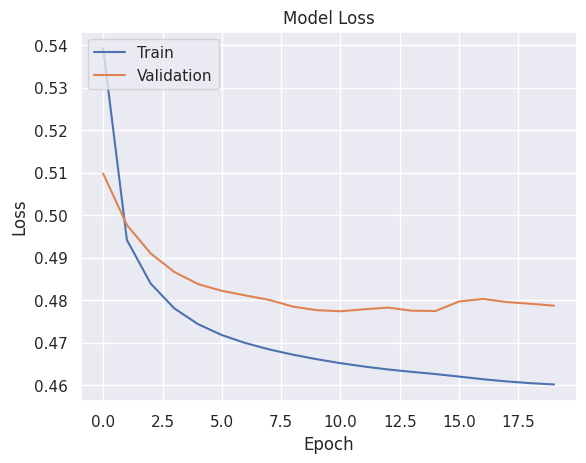

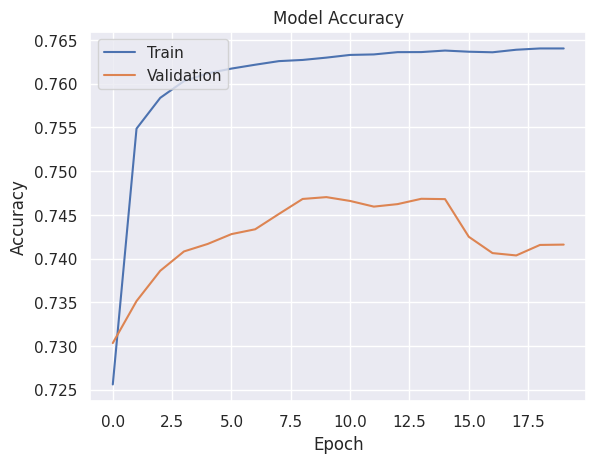

In [23]:
# train 2015 model

model_2015 = build_model(num_hidden_layers=1, # dropped from 2 as val error rising
                         units_per_layer=5, # changed from 8, 10
                         activation_function='relu',
                         learning_rate=0.0005, # changed from .001, .005, .0005 now
                         optimizer='adam')

# Plot the model architecture
tf.keras.utils.plot_model(model_2015, show_shapes=True, show_layer_names=True)

# Convert inputs to numpy
X_train_np = {col: X_train_2015_mini[[col]].to_numpy() for col in X_train_2015_mini.columns}
X_val_np = {col: X_val_2015[[col]].to_numpy() for col in X_val_2015.columns}

# Model Summary
model_2015.summary()

# Fit the model
history_2015 = model_2015.fit(
    x=X_train_np,
    y=y_train_2015_mini.to_numpy(),  # Ensure target is numpy array
    epochs=20,
    batch_size=64,
    validation_data=(X_val_np, y_val_2015.to_numpy()),
    verbose=0
)

# Show training history
#show_history(history_2015)
#import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history_2015.history['loss'])
plt.plot(history_2015.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy if available
if 'accuracy' in history_2015.history:
    plt.plot(history_2015.history['accuracy'])
    plt.plot(history_2015.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step
Test Data Accuracy: 0.7429502324517948
AUC Score: 0.7136314226203209
Confusion Matrix:
 [[33403 10746]
 [ 2745  5590]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9241    0.7566    0.8320     44149
           1     0.3422    0.6707    0.4532      8335

    accuracy                         0.7430     52484
   macro avg     0.6331    0.7136    0.6426     52484
weighted avg     0.8317    0.7430    0.7718     52484



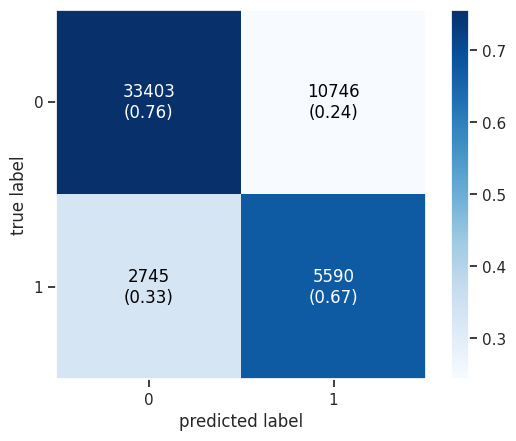

In [24]:
# Test on 2015
# Convert test inputs to numpy arrays
X_test_np = {col: X_test_2015[[col]].to_numpy() for col in X_test_2015.columns}

# Predict probabilities and convert to binary predictions
y_2015_pred = model_2015.predict(X_test_np)
y_2015_pred_binary = (y_2015_pred > 0.5).astype(int)

# Ensure y_test is a numpy array
y_test_np = y_test_2015.to_numpy().ravel()

# Evaluate the model
print("Test Data Accuracy:", accuracy_score(y_test_np, y_2015_pred_binary))
print("AUC Score:", roc_auc_score(y_test_np, y_2015_pred_binary))
print("Confusion Matrix:\n", confusion_matrix(y_test_np, y_2015_pred_binary))
print("Classification Report:\n", classification_report(y_test_np, y_2015_pred_binary, digits = 4))

# Confusion matrix and plot
cm1 = confusion_matrix(y_test_np, y_2015_pred_binary)
plot_confusion_matrix(conf_mat=cm1, show_absolute=True, show_normed=True, colorbar=True)
plt.show()


1635/1635 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step
Test Data Accuracy: 0.7311743676996311
AUC Score: 0.7004404630620648
Confusion Matrix:
 [[32434 10985]
 [ 3077  5813]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9134    0.7470    0.8218     43419
           1     0.3461    0.6539    0.4526      8890

    accuracy                         0.7312     52309
   macro avg     0.6297    0.7004    0.6372     52309
weighted avg     0.8169    0.7312    0.7591     52309



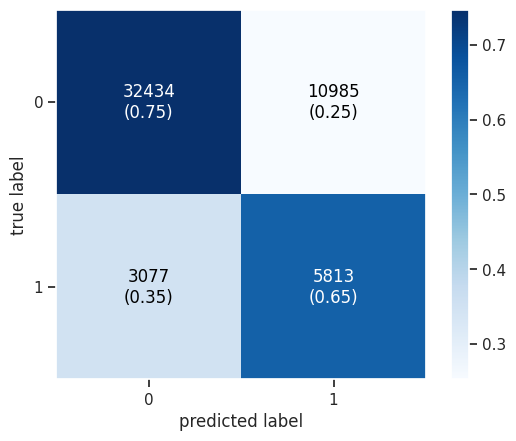

In [25]:
## Apply 2015 Model on 2023 test data
# Convert the input data to numpy arrays (similar to how it's done in the training code)
df_2023_X_np = {col: X_test_2023[[col]].to_numpy() for col in X_test_2023.columns}

# Predict probabilities using the model
df_2023_y_pred = model_2015.predict(df_2023_X_np)

# If it's binary classification, binarize the probabilities
df_2023_y_pred = (df_2023_y_pred > 0.5).astype(int)  # Binarize predictions

# Convert df_2023_y to a numpy array if it is a DataFrame
df_2023_y_np = y_test_2023.to_numpy().ravel()  # Flatten to ensure it's a 1D array

# Evaluate the model
print("Test Data Accuracy:", accuracy_score(df_2023_y_np, df_2023_y_pred))
print("AUC Score:", roc_auc_score(df_2023_y_np, df_2023_y_pred))
print("Confusion Matrix:\n", confusion_matrix(df_2023_y_np, df_2023_y_pred))
print("Classification Report:\n", classification_report(df_2023_y_np, df_2023_y_pred, digits=4))

# Confusion matrix and plot
cm1 = confusion_matrix(df_2023_y_np, df_2023_y_pred)
plot_confusion_matrix(conf_mat=cm1, show_absolute=True, show_normed=True, colorbar=True)
plt.show()


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.857461 to fit



Model: "DiabetesModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ HighBP (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ HighChol (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Smoker (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Stroke (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ HeartDiseaseorAttack      │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ PhysActivity (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ DiffWalk (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Sex (InputLayer)          │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ BMI_class (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GenHlth_2 (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GenHlth_3 (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GenHlth_4 (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GenHlth_5 (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_2 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_3 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_4 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_5 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_6 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Age_7 (InputLayer)        │ (None, 1)              │              0 │ -                      │
├──────────────────────

 Total params: 206 (824.00 B)

 Trainable params: 206 (824.00 B)

 Non-trainable params: 0 (0.00 B)

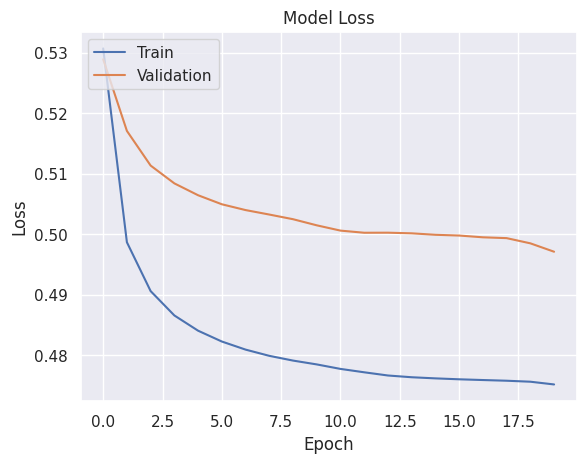

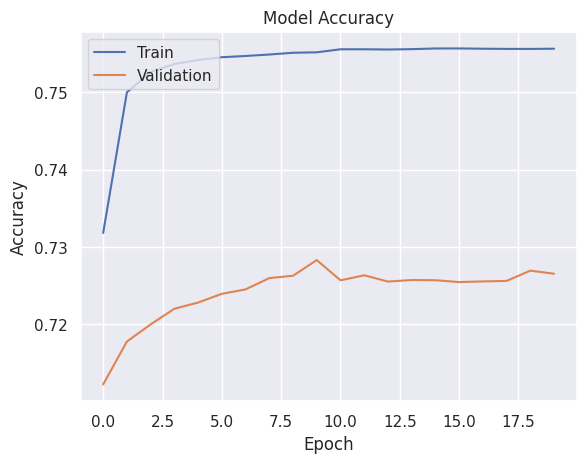

In [26]:
# Step 1: Build the model (same as before)
model_combined = build_model(num_hidden_layers=1,
                         units_per_layer=5,
                         activation_function='relu',
                         learning_rate=0.0005,
                         optimizer='adam') # fill in with hyperparameters

# Plot the model architecture
tf.keras.utils.plot_model(model_combined, show_shapes=True, show_layer_names=True)

# Step 2: Convert inputs to numpy (ensuring column names match)
X_combined_train_np = {col: X_combined_train[[col]].to_numpy() for col in X_combined_train.columns}
X_combined_val_np = {col: X_combined_val[[col]].to_numpy() for col in X_combined_val.columns}


# Step 3: Model Summary (optional)
model_combined.summary()

# Step 4: Fit the model
history_combined = model_combined.fit(
    x=X_combined_train_np,   # Pass the training features
    y=y_combined_train.to_numpy(),  # Ensure target is numpy array
    epochs=20,
    batch_size=64,
    validation_data=(X_combined_val_np, y_combined_val.to_numpy()),  # Validation data
    verbose=0  # Set to 1 for more verbose output
)

# Show training history
#show_history(history_combined)
#import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history_combined.history['loss'])
plt.plot(history_combined.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy if available
if 'accuracy' in history_combined.history:
    plt.plot(history_combined.history['accuracy'])
    plt.plot(history_combined.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


3275/3275 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step
Test Data Accuracy: 0.7271955187846516
AUC Score: 0.7140689715205693
Confusion Matrix:
 [[64242 23326]
 [ 5262 11963]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9243    0.7336    0.8180     87568
           1     0.3390    0.6945    0.4556     17225

    accuracy                         0.7272    104793
   macro avg     0.6316    0.7141    0.6368    104793
weighted avg     0.8281    0.7272    0.7584    104793



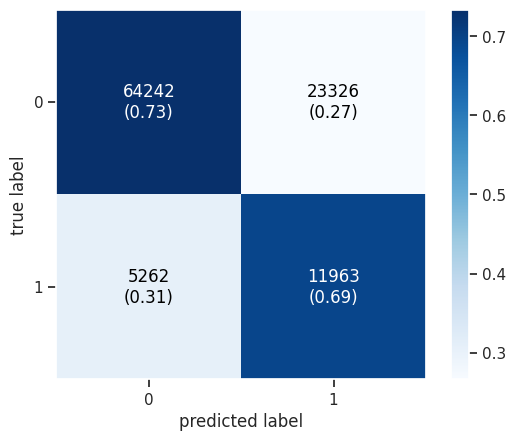

In [27]:
# combined model test

# Convert test inputs to numpy arrays
X_combined_test_np = {col: X_combined_test[[col]].to_numpy() for col in X_combined_test.columns}

# Predict probabilities and convert to binary predictions
y_combined_pred = model_combined.predict(X_combined_test_np)
y_combined_pred_binary = (y_combined_pred > 0.5).astype(int)

# Ensure y_test is a numpy array
y_combined_test_np = y_combined_test.to_numpy().ravel()

print("Test Data Accuracy:", accuracy_score(y_combined_test_np, y_combined_pred_binary))
print("AUC Score:", roc_auc_score(y_combined_test_np, y_combined_pred_binary))
print("Confusion Matrix:\n", confusion_matrix(y_combined_test_np, y_combined_pred_binary))
print("Classification Report:\n", classification_report(y_combined_test_np, y_combined_pred_binary, digits=4))

# Confusion matrix and plot
cm1 = confusion_matrix(y_combined_test_np, y_combined_pred_binary)
plot_confusion_matrix(conf_mat=cm1, show_absolute=True, show_normed=True, colorbar=True)
plt.show()


1635/1635 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step
Test Data Accuracy: 0.7216540174730925
AUC Score: 0.7089736468286589
Confusion Matrix:
 [[31617 11802]
 [ 2758  6132]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9198    0.7282    0.8128     43419
           1     0.3419    0.6898    0.4572      8890

    accuracy                         0.7217     52309
   macro avg     0.6308    0.7090    0.6350     52309
weighted avg     0.8216    0.7217    0.7524     52309



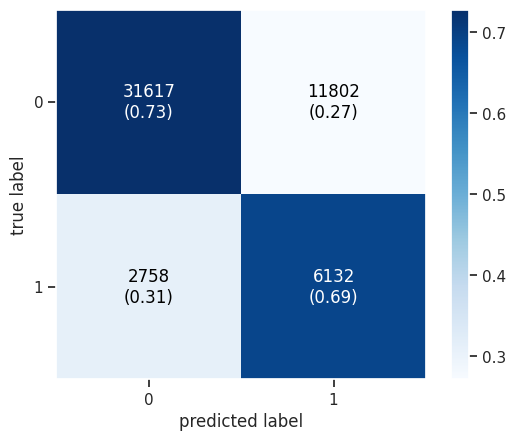

In [28]:
## Apply combined Model on 2023 test data
# Convert the input data to numpy arrays (similar to how it's done in the training code)
df_2023_X_np = {col: X_test_2023[[col]].to_numpy() for col in X_test_2023.columns}

# Predict probabilities using the model
df_2023_y_pred = model_combined.predict(df_2023_X_np)

# If it's binary classification, binarize the probabilities
df_2023_y_pred = (df_2023_y_pred > 0.5).astype(int)  # Binarize predictions

# Convert df_2023_y to a numpy array if it is a DataFrame
df_2023_y_np = y_test_2023.to_numpy().ravel()  # Flatten to ensure it's a 1D array

# Evaluate the model
print("Test Data Accuracy:", accuracy_score(df_2023_y_np, df_2023_y_pred))
print("AUC Score:", roc_auc_score(df_2023_y_np, df_2023_y_pred))
print("Confusion Matrix:\n", confusion_matrix(df_2023_y_np, df_2023_y_pred))
print("Classification Report:\n", classification_report(df_2023_y_np, df_2023_y_pred, digits=4))

# Confusion matrix and plot
cm1 = confusion_matrix(df_2023_y_np, df_2023_y_pred)
plot_confusion_matrix(conf_mat=cm1, show_absolute=True, show_normed=True, colorbar=True)
plt.show()
